# Motion artefact removal

This work is based on the excellent tutorials created by the MNE and MNE-NIRS developers:

- **MNE**: [Tutorials](https://mne.tools/stable/auto_tutorials/index.html)
- **MNE-NIRS**: [Examples](https://mne.tools/mne-nirs/stable/auto_examples/index.html)


## Table of Contents
* [Pre-processing](#chapter_1)
    * [Load python modules](#section_1_1)
    * [Import data](#section_1_2)
        * [Import snirf data](#sub_section_1_2_1)
        * [Add info to raw intensity data](#sub_section_1_2_2)
    * [Auxiliary hardware algorithms](#section_1_3)
        * [Accelerometer-based motion artifact removal algorithm](#sub_section_1_3_1)
        * [Active noise cancelation](#sub_section_1_3_2)
    * [Signal processing methods](#section_1_4)
        * [Wavelet filtering](#sub_section_1_4_1)
        * [Kurtosis-based wavelet filtering](#sub_section_1_4_2)
        * [Spline interpolation](#sub_section_1_4_3)
        * [Principal component analysis](#sub_section_1_4_4)
        * [Independent component analysis](#sub_section_1_4_5) 
        * [Temporal derivative distribution repair](#sub_section_1_4_6)
        * [Correlation-based signal improvement](#sub_section_1_4_7)
    <!-- * [Epoching](#section_1_4) 
        * [Define the range of epochs, the rejection criteria, baseline correction and extract the epochs](#sub_section_1_4_1)
        * [Topographic representation of activity](#sub_section_1_4_2)
        * [View consistency of responses across trials](#sub_section_1_4_3)
        * [View consistency of responses across channels](#sub_section_1_4_4)
        * [Plot standard fNIRS response image](#sub_section_1_4_5)
        * [Topographic representation of activity](#sub_section_1_4_6)
        * [Compare tapping of left and right hands](#sub_section_1_4_7)
* [Statistical analysis](#chapter_2)
    * [Statistical summary](#section_2_1) 
        * [Sub Section 2.1.1](#sub_section_2_1_1)
        * [Sub Section 2.1.2](#sub_section_2_1_2)
    * [Statistical comparison of conditions](#section_2_2) 
    * [Traditional Statistics](#section_2_3) -->

## Pre-processing <a class="anchor" id="chapter_1"></a>

---
### Load python modules <a class="anchor" id="section_1_1"></a>

In [1]:
# Import the needed modules 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mne
import mne_nirs
import pywt
import scipy
import dabest
from itertools import compress
from mne.preprocessing.nirs import scalp_coupling_index, optical_density, temporal_derivative_distribution_repair, beer_lambert_law, _validate_nirs_info, source_detector_distances
from mne_nirs.preprocessing import peak_power, scalp_coupling_index_windowed, quantify_mayer_fooof
from mne_nirs.visualisation import plot_timechannel_quality_metric
from mne_nirs.channels import get_short_channels, get_long_channels, picks_pair_to_idx
from mne_nirs.signal_enhancement import short_channel_regression
from mne_nirs.experimental_design import make_first_level_design_matrix
from mne.preprocessing import ICA, corrmap
from scipy.stats import norm, ttest_1samp, kurtosis, pearsonr
from scipy.signal import wiener
from scipy.interpolate import CubicSpline
from fooof import FOOOF
from csaps import csaps
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler

C:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,
C:\Users\fabia\AppData\Local\Temp\ipykernel_1672\1002167252.py:22: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF


In [2]:
# Write own fucntions
def reorder(raw_initial):
    """
    Input: raw object
    Function: reorders the channels to match the MNE standard
    """
    raw = raw_initial.copy()
    channel_names = raw.ch_names
    channel_names_ordered = []
    for i in range(0, int(len(channel_names)/2)):
        channel_names_ordered.append(channel_names[i])
        channel_names_ordered.append(channel_names[(i + int(len(channel_names)/2))])
    raw_ordered = raw.reorder_channels(channel_names_ordered)
    return raw_ordered

def add_info(raw_intensity, first_name, last_name, age, sex, EHI, annotations, duration_annotation, duration_rest, N_control):
    """
    Input: raw object, first name, last name, age, sex, EHI, annotations, duration of annotation, duration of baseline period, # of control trials
    Function: Returns raw object with added subject info and random allocated control trials within the baseline period
    """
    raw = raw_intensity.copy()
    
    # Add subject info
    raw.info["subject_info"] = {'first_name' : first_name, 'last_name' : last_name, 'age' : age, 'sex' : sex, 'EHI' : EHI}
    
    # attribute meaningful names to trigger codes. Include information about the duration of each stimulus (10 seconds). 
    raw.annotations.set_durations(duration_annotation)
    raw.annotations.rename(annotations)
    
    events, event_dict = mne.events_from_annotations(raw)
    
    # Define begin and end of rest period
    begin_rest = np.ceil(events[np.where(events[:,2] == event_dict['Baseline'])[0][0],0]/raw.info['sfreq'])
    end_rest = begin_rest + duration_rest - duration_annotation 
    
    # Remove start indicator of rest period
    raw.annotations.delete(np.nonzero(raw.annotations.description == "Baseline"))
    
    # Define indices of random selected control trials
    indices = np.random.choice(np.arange(begin_rest, end_rest), N_control, replace = False).astype(int)
    raw.annotations.append(indices, [duration_annotation]*N_control, ["Baseline"]*N_control)
    
    return raw

def crop(raw_input, t_before = 10, t_after = 60):
    """
    Input: raw object, time interval length before first event and time interval length after last event that should be included in the recording
    Function: crops raw object to a recording starting 't_before' s (default 10 s) before the first annotated event and ending 't_after' s (default 60 s) after the last event 
    """
    raw = raw_input.copy()
    end_rec = raw.get_data().shape[1]/raw.info['sfreq']
    t_start = events[0,0]/raw.info['sfreq'] - t_before
    t_end = events[-1,0]/raw.info['sfreq'] + t_after
    if t_start < 10:
        t_start = 0
    if t_end > end_rec:
        t_end = end_rec
    raw.crop(t_start, t_end)
    return raw

def get_indices(array, target_array):
    """
    Input: complete array of channel names, array of channels names to be removed
    Function: gives back indices of desired channels
    """
    lst = list(array)
    indices = list(np.arange(0, len(array)))
    for target in target_array:
        if target in lst:
            indices.remove(lst.index(target))
    return indices

def ch_names_L_R(raw):
    """
    Input: raw object
    Function: Separate list of channel names in 2 lists for the left and right hemisphere respectively
    """
    left, right = [], []
    for ch in raw.ch_names:
        if (int(ch[1]) % 2) == 0:
            right.append(ch)
        else:
            left.append(ch)
    return left, right

def scale_up_spectra(spectra, freqs):
    """
    Input: spectra, freqs
    Function: FOOOF requires the frequency values to be higher than the fNIRS data permits, 
    so we scale the values up by 10 here, and then will scale
    the frequency values down by 10 later.
    """
    freqs = freqs * 10
    return spectra, freqs

def get_IMU_data(filename, plot = False):
    """
    Extract IMU data from text file.
    Input: filename with .txt, plot (bool)
    Output: Three dataframes containing the complete IMU data, the accelerometer data and the gyroscope data respectively
    """
    
    # Read .txt file and convert to dataframe
    df = pd.read_csv(filename, sep=';', header=None, names=["time", "battery", "channels", "gyroX", "gyroY", "gyroZ", "accX", "accY", "accZ", "marker", "_"])

    # Select IMU data
    data = df.drop(0)
    markers = data["marker"].astype(float)
    IMU_data = data.drop(columns =['time', 'battery', 'channels', 'marker', '_']).astype(float)

    gyro_data = IMU_data.drop(columns = ['accX', 'accY', 'accZ'])
    acc_data = IMU_data.drop(columns = ["gyroX", "gyroY", "gyroZ"])
    
    if plot: 
        %matplotlib inline
        gyro_data.plot(title='Gyroscope data', grid = True, xlabel = 'samples', ylabel = 'dps')
        acc_data.plot(title='Accelerometer data', grid = True, xlabel = 'samples', ylabel = 'm/s^2')

    return IMU_data, acc_data, gyro_data

In [3]:
# Set plot characteristics
%matplotlib inline
sns.set_theme() # nicer plots
# Load external plots?
plot = False

### Import data <a class="anchor" id="section_1_2"></a>

#### Import snirf data <a class="anchor" id="sub_section_1_2_1"></a>

In [4]:
filename = 'FTT1.snirf'

In [5]:
# Read snirf data
raw = mne.io.read_raw_snirf(filename, optode_frame='unknown', preload=False, verbose=None)

Loading C:\Users\fabia\fNIRS data analysis\Notebooks Master Thesis - Fabian Duren\FTT analysis\FTT1\FTT1.snirf


In [6]:
# Reorder channels (Due to non-uniformity between mne_nirs and .snirf data)
raw_intensity = reorder(raw)

#### Add info to raw intensity data <a class="anchor" id="sub_section_1_2_2"></a>

In [7]:
# Use self-written function to add info about the subject and the recording
annotations = {"1": "Baseline", "2": "Grasping/Right", "3": "Grasping/Left"}
raw_intensity = add_info(raw_intensity, 'Subject', '1', 26, 'male', 'right', annotations, 10, 60, 10)

Used Annotations descriptions: ['Baseline', 'Grasping/Left', 'Grasping/Right']


In [8]:
# Look at characteristics
raw_intensity

<RawSNIRF | FTT1.snirf, 52 x 4394 (852.2 s), ~52 kB, data not loaded>

Used Annotations descriptions: ['Baseline', 'Grasping/Left', 'Grasping/Right']


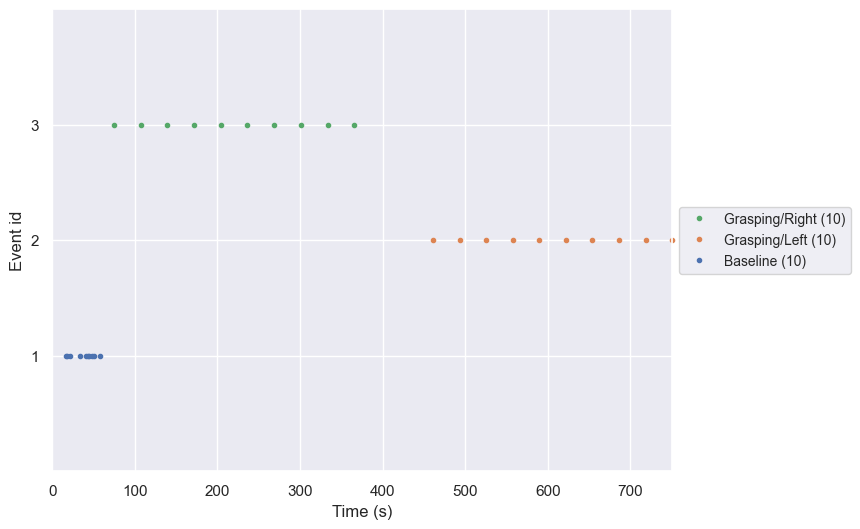

In [9]:
# Look at segments
events, event_dict = mne.events_from_annotations(raw_intensity)
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)
mne.viz.plot_events(events, event_id=event_dict, sfreq=raw_intensity.info['sfreq']);

In [10]:
# As a table
raw_intensity.annotations.to_data_frame()

onset  duration     description
0  2024-02-15 13:12:53.000      10.0        Baseline
1  2024-02-15 13:12:54.000      10.0        Baseline
2  2024-02-15 13:12:57.000      10.0        Baseline
3  2024-02-15 13:13:10.000      10.0        Baseline
4  2024-02-15 13:13:17.000      10.0        Baseline
5  2024-02-15 13:13:19.000      10.0        Baseline
6  2024-02-15 13:13:20.000      10.0        Baseline
7  2024-02-15 13:13:24.000      10.0        Baseline
8  2024-02-15 13:13:27.000      10.0        Baseline
9  2024-02-15 13:13:34.000      10.0        Baseline
10 2024-02-15 13:13:50.884      10.0  Grasping/Right
11 2024-02-15 13:14:23.476      10.0  Grasping/Right
12 2024-02-15 13:14:55.486      10.0  Grasping/Right
13 2024-02-15 13:15:27.496      10.0  Grasping/Right
14 2024-02-15 13:15:59.894      10.0  Grasping/Right
15 2024-02-15 13:16:31.904      10.0  Grasping/Right
16 2024-02-15 13:17:04.496      10.0  Grasping/Right
17 2024-02-15 13:17:36.700      10.0  Grasping/Right
18 2024-02-15 13:18:09.486      10.0  Grasping/Right
19 2024-02-15 13:18:40.720      10.0  Grasping/Right
20 2024-02-15 13:20:16.944      10.0   Grasping/Left
21 2024-02-15 13:20:49.536      10.0   Grasping/Left
22 2024-02-15 13:21:21.352      10.0   Grasping/Left
23 2024-02-15 13:21:53.750      10.0   Grasping/Left
24 2024-02-15 13:22:25.760      10.0   Grasping/Left
25 2024-02-15 13:22:57.576      10.0   Grasping/Left
26 2024-02-15 13:23:29.974      10.0   Grasping/Left
27 2024-02-15 13:24:01.984      10.0   Grasping/Left
28 2024-02-15 13:24:34.382      10.0   Grasping/Left
29 2024-02-15 13:25:06.586      10.0   Grasping/Left

---
> *Remark:*
- 26 channels * 2 wavelengths = 52 channels
- sample frequency = 5.15 Hz
- LPF = 2.58 Hz -  What filter?
- 10 random selected control segments within the baseline recording period
- 10 left and 10 right hand grasping segments
---

The quality of a fNIRS recording can be assessed by a visual inspection of the signals. On the one hand there can be features present in the signals which indicate a good signal quality, such as certain physiological components, and on the other hand there can be features present which indicate bad signal quality in one or more channels, such as MAs.

##### Validate that the location of sources-detector pairs and channels are in the expected locations

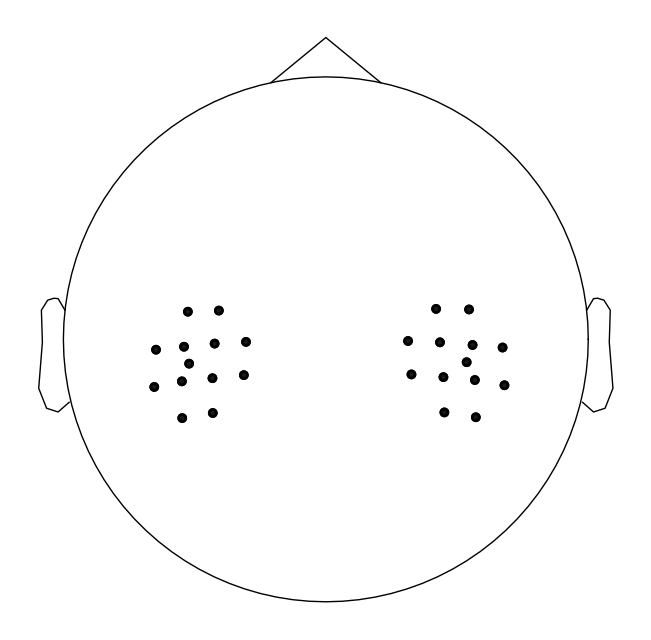

In [11]:
# Plot channels in 2D using build-in function of mne_nirs
sns.reset_defaults() # Turn of sns to be able to also plot contour of head
# dots = Center of channels
%matplotlib inline
raw_intensity.plot_sensors();

In [12]:
sns.set_theme()
if plot:
    # Plot channels in 3D
    subjects_dir = mne.datasets.sample.data_path() / "subjects"
    mne.datasets.fetch_fsaverage(subjects_dir=subjects_dir)

    brain = mne.viz.Brain("fsaverage", subjects_dir=subjects_dir, alpha=0.5, cortex="low_contrast")
    brain.add_head()
    
    identity_trans = mne.transforms.Transform("head", "mri") #transformed coord
    brain.add_sensors(raw_intensity.info, trans=identity_trans, fnirs=["channels", "pairs", "sources", "detectors"])

    # Add ROI (Primary motor cortex (precentral gyrus))
    brain.add_label("BA4a", hemi = "lh", borders=False, color='blue')
    brain.add_label("BA4a", hemi = "rh", borders=False, color='blue')
    brain.add_label("BA4p", hemi = "lh", borders=False, color='blue')
    brain.add_label("BA4p", hemi = "rh", borders=False, color='blue')


    brain.show_view(azimuth=90, elevation=90, distance=500)

---
> *Remark:*
- 24 long channels and 2 short channels
- 8 sources, 10 detectors and 2 short channel sources
- montage located above sensorimotor cortex
---

##### Visual inspection of the raw light intensity data

In [13]:
# Plot raw data with build-in plot function of mne_nirs
if plot:
    %matplotlib qt
    raw_intensity.plot(duration=300, show_scrollbars = True, clipping = None);

---
> *Remark:*
- Physiological components: abc
- Extrinsic components: abc
---

##### Visual inspection of the the optical density 

The OD or the attenuation of incident light, can be calculated as the logarithmic ratio of the input light intensity ($I_{in}$) and the detected light intensity ($I_{out}$):
$$OD_\lambda = \log \left(\frac{I_{in}}{I_{out}}\right)$$

In [14]:
# Convert raw intensity data to OD with build-in function of mne_nirs
raw_od = optical_density(raw_intensity)

Reading 0 ... 4393  =      0.000 ...   852.242 secs...


In [15]:
# Plot OD
if plot:
    %matplotlib qt
    raw_od.plot(duration=300, show_scrollbars = True, clipping = None);

---
> *Remark:*
- Physiological components: abc
- Extrinsic components: abc
---

##### Visual inspection of the haemoglobin concentration

By solving the Beer-Lambert law for two measurement wavelengths on either side of the isosbestic point - the point where the HbR and HbO spectra cross, the unknows can be eliminated from the equation. Small changes of attenuation for both wavelengths, due to changes in  HbR and HbO concentrations, can be detected with the following formula:
$$ \Delta OD_\lambda = \log \left(\frac{I_{rest}}{I_{test}}\right) \ \approx \epsilon_\lambda^{HbR} \cdot \Delta c^{HbR} \cdot L + \epsilon_\lambda^{HbO} \cdot \Delta c^{HbO} \cdot L $$
From the two resulting equations, one for each wavelength, the chromophore concentrations can be found:
$$ [HbO] = \frac{a_{HbO}^{\lambda_2} \cdot \Delta A_{\lambda_1} - a_{HbR}^{\lambda_1} \cdot \Delta A_{\lambda_2}}{L \cdot (a_{HbO}^{\lambda_1} \cdot a_{HbR}^{\lambda_2} - a_{HbO}^{\lambda_2} \cdot a_{HbR}^{\lambda_1})} $$
$$ [HbR] = \frac{a_{HbO}^{\lambda_1} \cdot \Delta A_{\lambda_2} - a_{HbR}^{\lambda_2} \cdot \Delta A_{\lambda_1}}{L \cdot (a_{HbO}^{\lambda_1} \cdot a_{HbR}^{\lambda_2} - a_{HbO}^{\lambda_2} \cdot a_{HbR}^{\lambda_1})}$$

In [16]:
# Convert OD to haemoglobin concentration with build-in function of mne_nirs
# Constant ppf value: PPF = DPF/PVC
raw_haemo = beer_lambert_law(raw_od, ppf=6) # ppf=6 is more inline with the community expectations and makes our results easier compared to the majority of the existing literature.

In [17]:
# Plot concentrations
if plot:
    %matplotlib qt
    raw_haemo.plot(duration=300, show_scrollbars = True, clipping = None);

---
> *Remark:*
- abc
---

### Auxiliary hardware algorithms <a class="anchor" id="section_1_3"></a>

Two distinct approaches to MA correction algorithms are observed (Brigadoi et al., 2014). Some methods necessitate an additional measure of the MA (auxiliary hardware algorithms), such as a short-separation fNIRS channel or an accelerometer, to facilitate its removal. Conversely, others rely on inherent changes in the data's amplitude and frequency caused by the artifact, serving as post-processing techniques. The absence of a need for an additional measure allows this group to be adaptable across a wide range of experimental paradigms, rendering it the most versatile solution. Among these approaches are principal component analysis (PCA), Kalman filtering, correlation-based signal improvement (CBSI), wavelet filtering (WF) and spline interpolation.

In [18]:
# Load data with movement artefacts
raw_MA = mne.io.read_raw_snirf('romane_vorwald ma_22_20240508-133500.snirf', optode_frame='unknown', preload=False, verbose=None)
raw_MA_intensity = reorder(raw_MA)
annotations_MA = {"1": "practice/Vertical", "2": "practice/Horizontal", "3": "practice/Random", "4": "test/Vertical", "5": "test/Horizontal", "6": "test/Random", "7": "Baseline"}  
raw_MA_intensity = add_info(raw_MA_intensity, 'Romane', 'vorwald', 22, 'female', 'left', annotations_MA, 10, 120, 10)

# Look at segments
events_MA, event_dict_MA = mne.events_from_annotations(raw_MA_intensity)
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)
mne.viz.plot_events(events_MA, event_id=event_dict_MA, sfreq=raw_MA_intensity.info['sfreq']);

# Convert raw intensity data to OD
raw_MA_od = optical_density(raw_MA_intensity)
test = raw_MA_od.copy()
%matplotlib qt
raw_MA_od.plot(duration=100, show_scrollbars = True, clipping = None);

FileNotFoundError: fname does not exist: "C:\Users\fabia\fNIRS data analysis\Notebooks Master Thesis - Fabian Duren\FTT analysis\FTT1\romane_vorwald ma_22_20240508-133500.snirf"

Channels marked as bad:
none


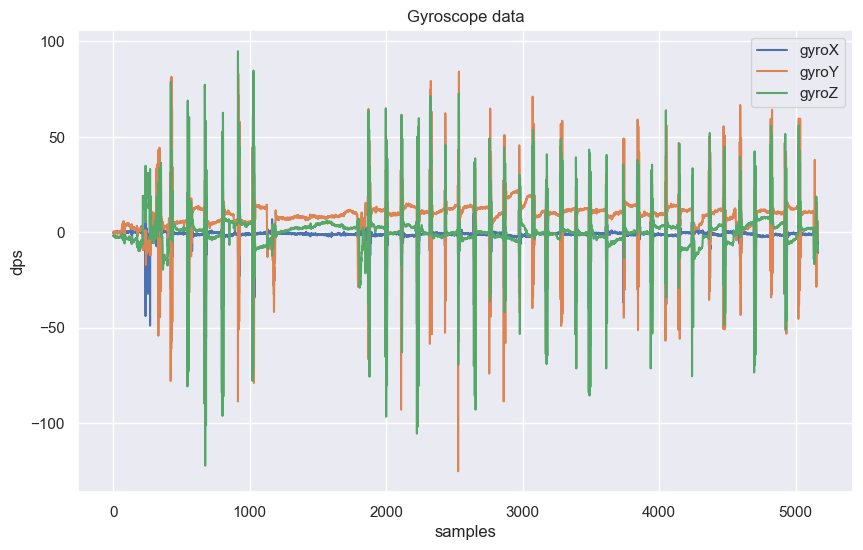

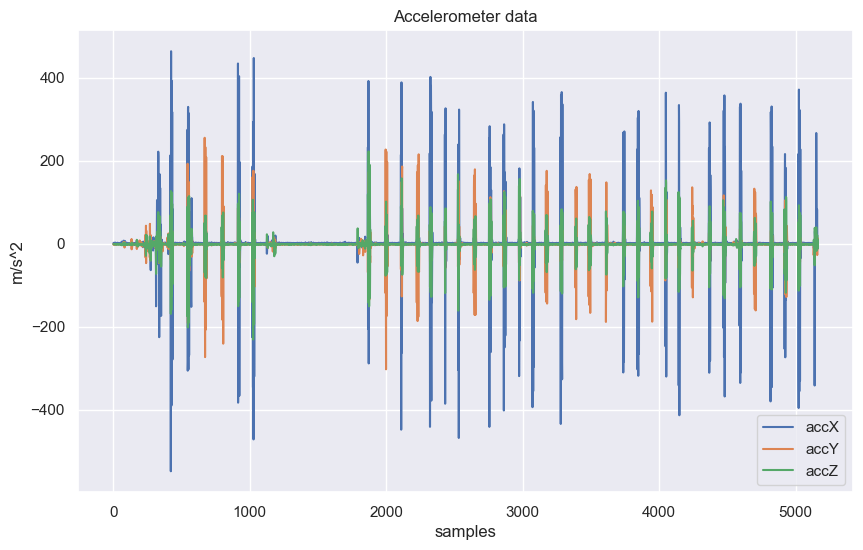

In [19]:
IMU_data, acc_df, gyro_df = get_IMU_data('romane_vorwald ma_22_20240508-133500.txt', plot = True)

#### Accelerometer-based motion artifact removal algorithm <a class="anchor" id="sub_section_1_3_1"></a>

Virtanen and colleagues (2011) introduced the accelerometer-based motion artifact removal algorithm (ABAMAR), which corrects baseline changes offline using accelerometer data from the x- and y-axes.

Motion events are detected when there is a significant change in one of the accelerometer signals between consecutive samples, exceeding a predetermined threshold. Virtanen et al. established a minimum threshold for accelerometer signal change at 1.3 g/s based on visual inspection. They also defined that motion detected within 20 s of a preceding event is part of that event, with a minimum event duration of 1 second. 

For each channel, the mean NIRS amplitude ($\overline{A}$) over 15 s is evaluated as a baseline before and after each motion event. A baseline shift is identified when the absolute difference between $\overline{A_{before}}$ and $\overline{A_{after}}$ exceeds 2.6 times the standard deviation of amplitude before the motion event, corresponding to the 99th percentile around the mean. 

Baseline shifts are removed if detected during a motion event on at least two NIRS detector channels, or at both light wavelengths on any single channel. This is achieved by multiplying the amplitude values after the motion event by $\frac{\overline{A_{before}}}{\overline{A_{after}}}$ and setting the amplitude values during the motion event to $\overline{A_{before}}$. 

In [20]:
# Define help functions
def f1(x):
    if x >= 0:
        result = 1
    else: 
        result = 0
    return result

def f2(x):
    if x > 0:
        result = 1
    else: 
        result = 0
    return result

def flag_ME(a_x, a_y, n, fs):
    DeltaT = 1/fs
    cond_1 = f1(np.abs(a_x[n]-a_x[n-1]) - 1.3*DeltaT)
    cond_2 = f1(np.abs(a_y[n]-a_y[n-1]) - 1.3*DeltaT)
    result = cond_1 or cond_2
    return result

def find_ME(a_x, a_y, fs, plot = False):
    ME_times = []
    for n in range(1, len(a_x)):
        score = flag_ME(a_x, a_y, n, fs)
        if score:
            ME_times.append(n/fs)
    ME_intervals = []
    for i in range(len(ME_times)):
        if i  == 0:
            ME_intervals.append(ME_times[i])
        elif (ME_times[i] - ME_times[i-1]) > 5: # Put shorter as MA are clode to each other, orgininal 20 s
            if ME_times[i-1] != ME_intervals[-1]:
                ME_intervals.append(ME_times[i-1])
            ME_intervals.append(ME_times[i])
    ME_intervals.append(ME_times[-1])

    ME_start = []
    for T_start in ME_intervals[::2]:
        ME_start.append(T_start)
    
    ME_duration = []
    for i in range(len(ME_intervals[::2])):
        T_m = ME_intervals[1::2][i] - ME_intervals[::2][i]
        if T_m >= 1: # (*)
            ME_duration.append(T_m)
        else:
            ME_start.pop(i)
            

    flagged = np.ones_like(a_x)*(-1)
    k = -1
    for i in range(len(ME_start)):
        s_start = round(ME_start[i]*fs)
        s_end = round((ME_start[i]+ME_duration[i])*fs) + 1
        k += 1
        flagged[s_start:s_end] = k
        
    if plot:
        t = np.arange(len(a_x))/fs
        ymin = np.min(np.concatenate([a_x, a_y]))
        ymax = np.max(np.concatenate([a_x, a_y]))
        plt.figure(figsize=(12,6))
        plt.plot(t, a_x, label = 'acc X')
        plt.plot(t, a_y, label = 'acc Y')
        plt.plot(ME_times, len(ME_times)*[ymax/4], 'x', color = 'y', label = 'ME')
        plt.vlines(ME_intervals, ymin, ymax, 'g', label = 'ME interval')
        plt.plot(t, flagged)
        #plt.vlines(ME_times, ymin, ymax)
        plt.legend()
        plt.xlabel('time (s)')
        plt.ylabel('g')
        plt.show()
    
    return flagged, ME_start

def avg_before(Z, T_start, fs):
    T_before = T_start - 1 # lower value than original code
    smin = round((T_before-3)*fs)
    if smin < 0:
        smin = 0
    smax = round(T_before*fs)
    if smax > len(Z[0]):
        smax = len(Z[0])
    return np.mean(Z[:,smin:smax], axis = -1)

def avg_after(Z, T_start, fs):
    T_after = T_start + 1
    smin = round(T_after*fs)
    if smin < 0:
        smin = 0
    smax = round((T_after+3)*fs)
    if smax > len(Z[0]):
        smax = len(Z[0])
    return np.mean(Z[:,smin:smax], axis = -1)

def std_before(Z, T_start, fs):
    T_before = T_start - 1 
    smin = round((T_before-3)*fs)
    if smin < 0:
        smin = 0
    smax = round(T_before*fs)
    if smax > len(Z[0]):
        smax = len(Z[0])
    return np.std(Z[:,smin:smax], axis = -1)
    

def flag_BS(Z, T_start, fs):
    return np.where((np.abs(avg_before(Z, T_start, fs) - avg_after(Z, T_start, fs)) - 2.6*std_before(Z, T_start, fs)) >= 0, 1, 0)

def N_ch(Z, T_start, fs):
    result = np.sum(flag_BS(Z, T_start, fs))
    return result

def N_wv(Z, T_start, fs):
    cond1 = flag_BS(Z[1::2], T_start, fs) > 0
    cond2 = flag_BS(Z[::2], T_start, fs) > 0
    result = np.sum(np.where(np.logical_and(cond1, cond2), 1, 0))
    return result
    
def flag_corr(Z, a_x, a_y, n, fs):
    result = 0
    flagged, ME_start = find_ME(a_x, a_y, fs, plot = False)
    if flagged[n] >= 0:
        T_start = ME_start[int(flagged[n])]
        cond1 = f1(N_ch(Z, T_start, fs) - 2)
        cond2 = f1(N_wv(Z, T_start, fs))
        if cond1 or cond2:
            result = 1           
    return result

In [21]:
# Define ABAMAR
def ABAMAR(Z, a_x, a_y, fs, plot = True):
    Z_new = Z.copy()
    flagged, ME_start = find_ME(a_x, a_y, fs)
    n_MA = -1
    for n in range(len(a_x)):   
        if flag_corr(Z, a_x, a_y, n, fs):
            T_start = ME_start[int(flagged[n])]
            Z_new[:,n] = avg_before(Z, T_start, fs)
            n_MA = int(flagged[n])
        elif n_MA >= 0:  
            Z_new[:,n] = avg_before(Z, T_start, fs)/avg_after(Z, T_start, fs)*Z[:,n]
        # the amplitude baseline preceding the event is imposed on all channels and wavelengths by multiplying 
        # amplitude values after Tm by A_before/A_after. Amplitude values between Tbefore and Tafter are set to 
        # A_before to remove any transient motion artifact
    # -->  A_before/A_after still to complete
    if plot:
        for i in range(len(Z)):
            t = np.arange(len(Z[i]))/fs
            plt.plot(t, Z[i], label = 'old')
            plt.plot(t, Z_new[i], '--', label = 'new')
            plt.legend()
            plt.xlabel('time (s)')
            plt.title('Channel ' + str(i))
            plt.show()
    return Z_new

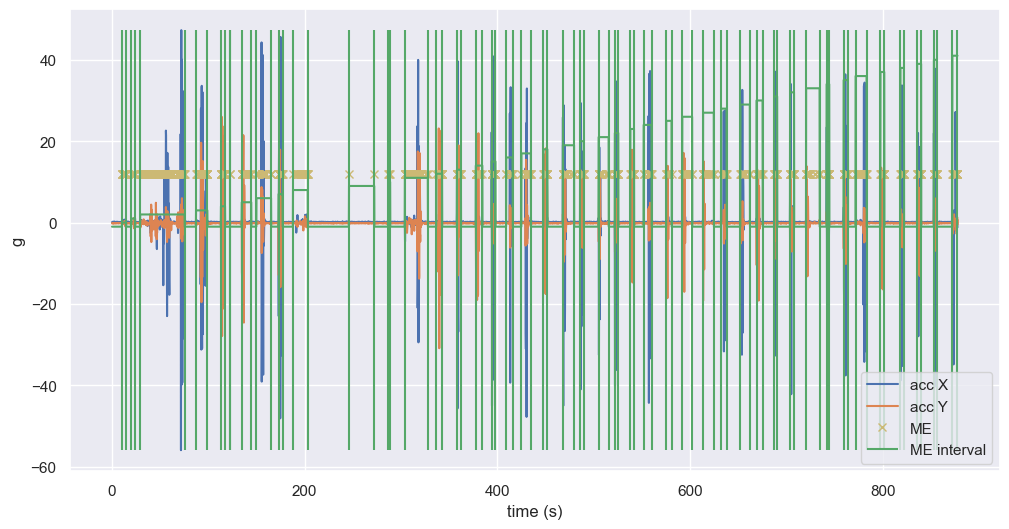

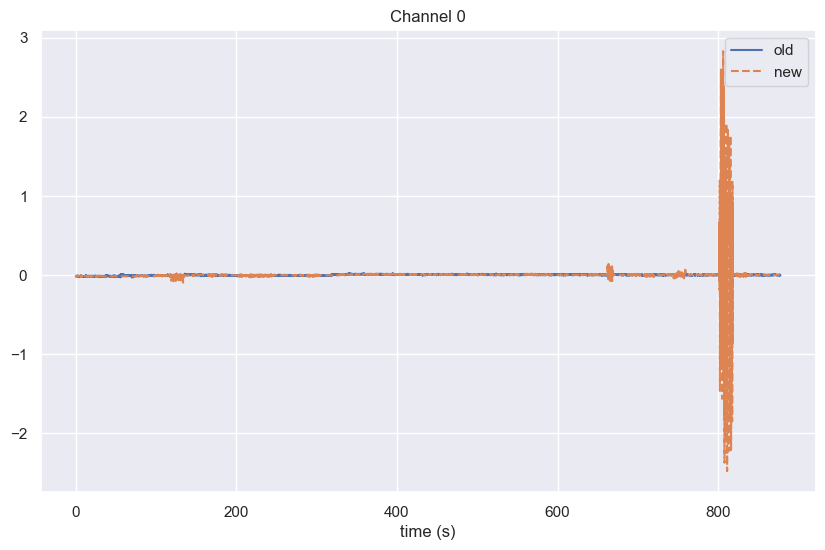

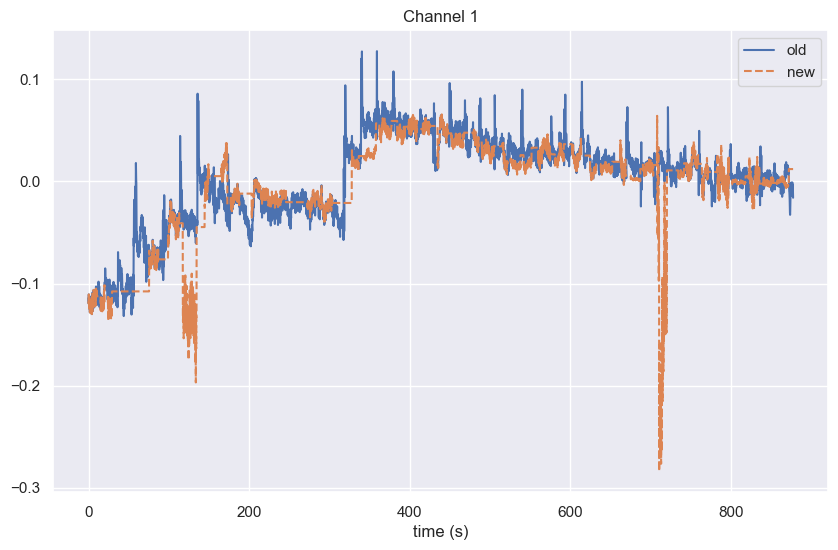

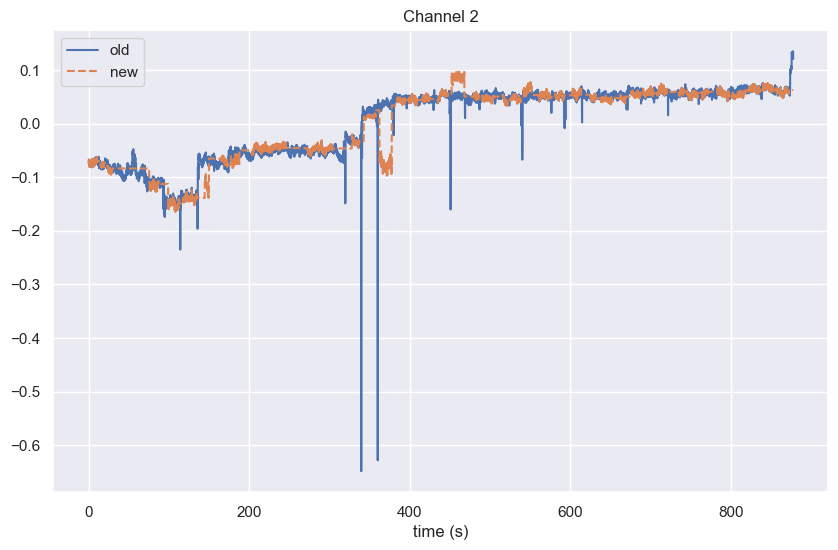

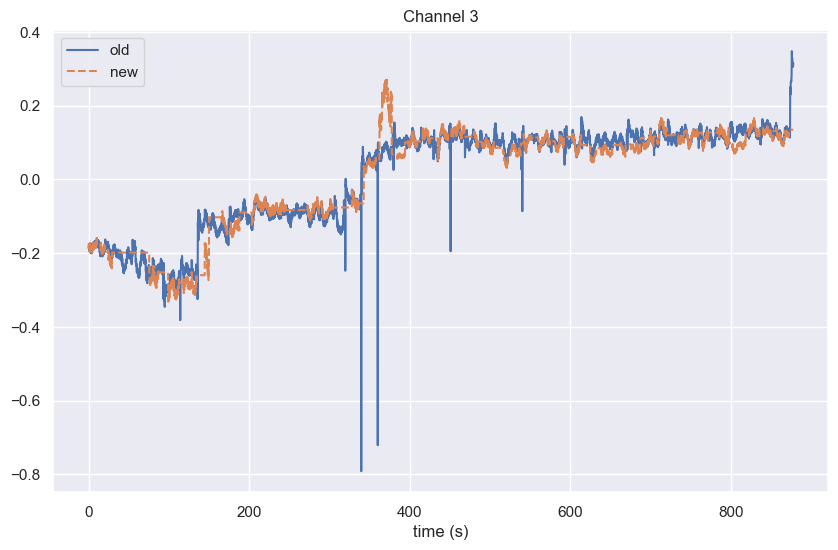

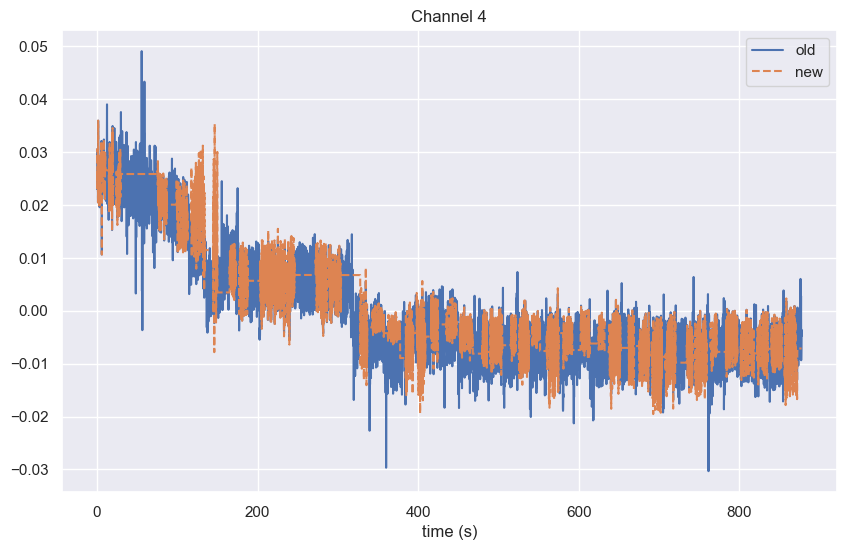

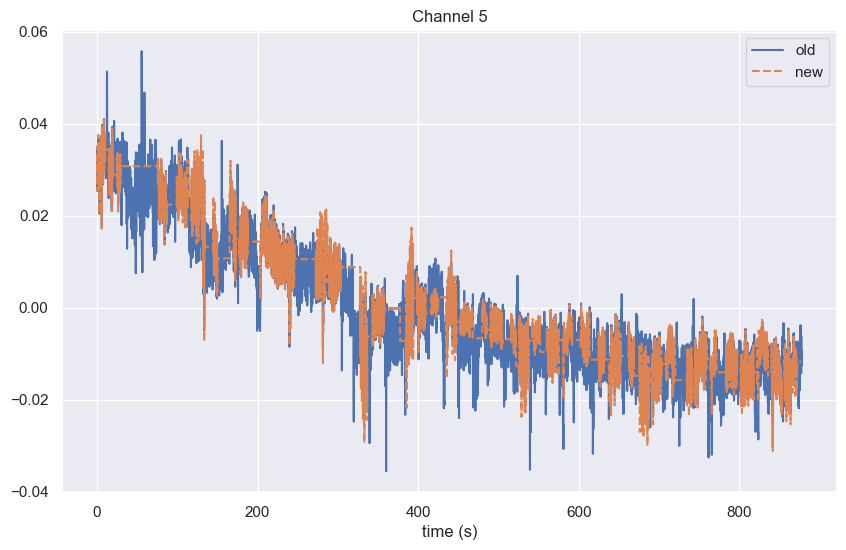

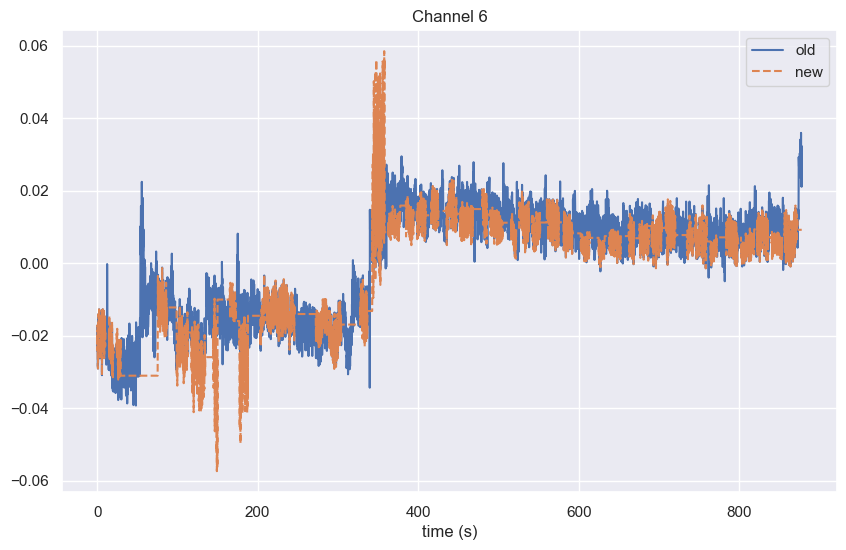

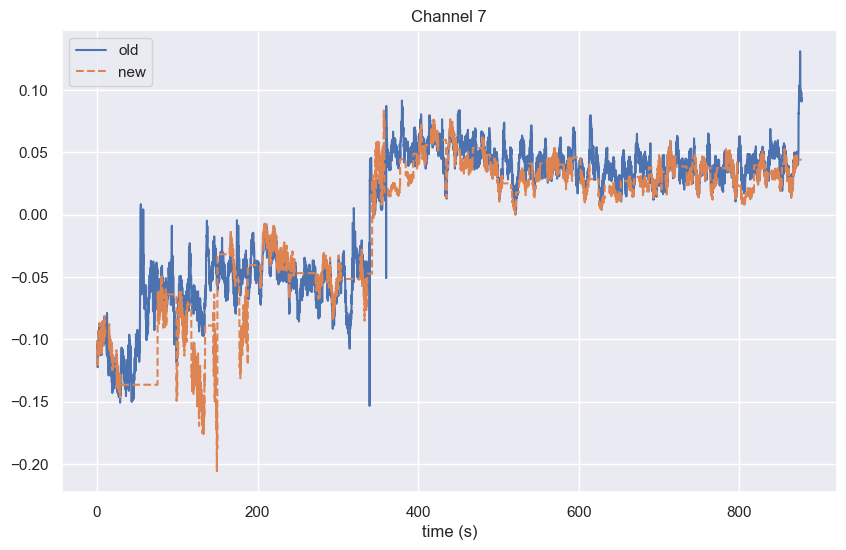

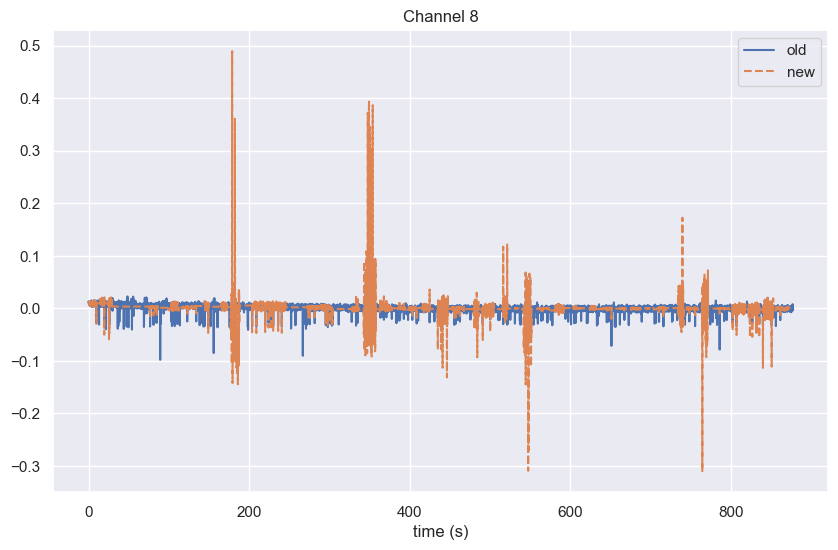

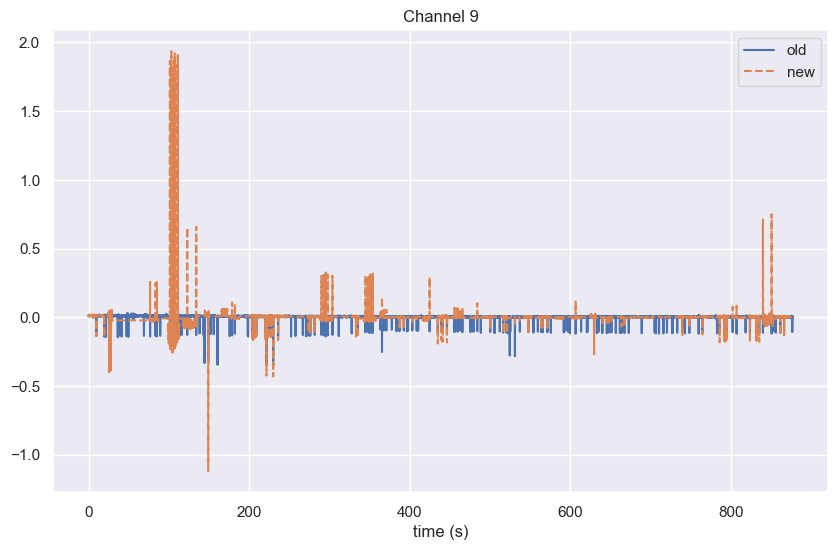

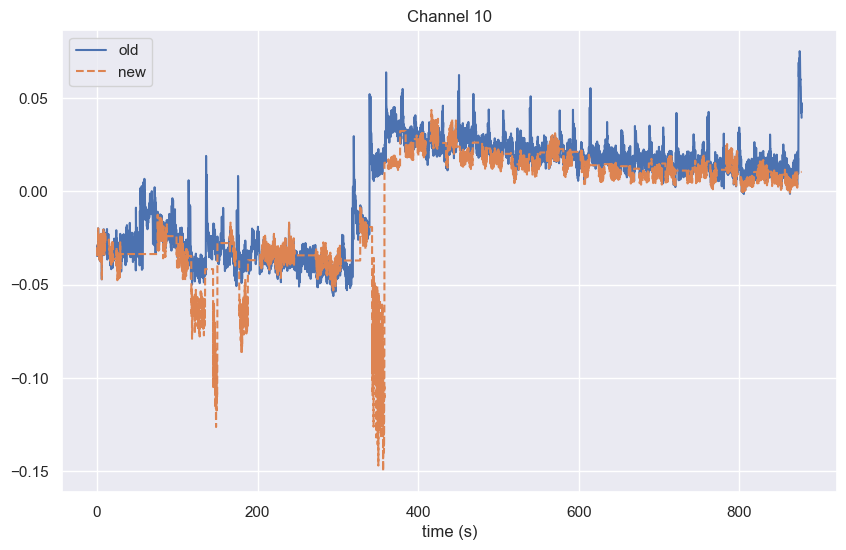

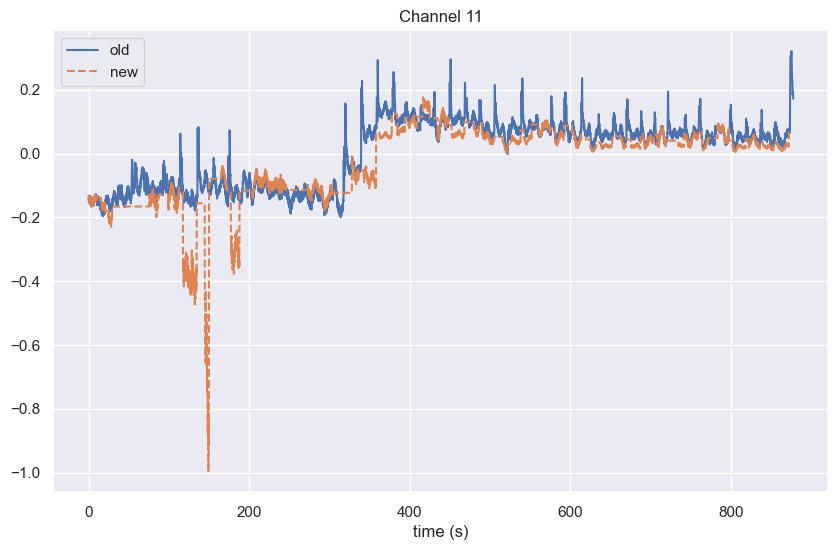

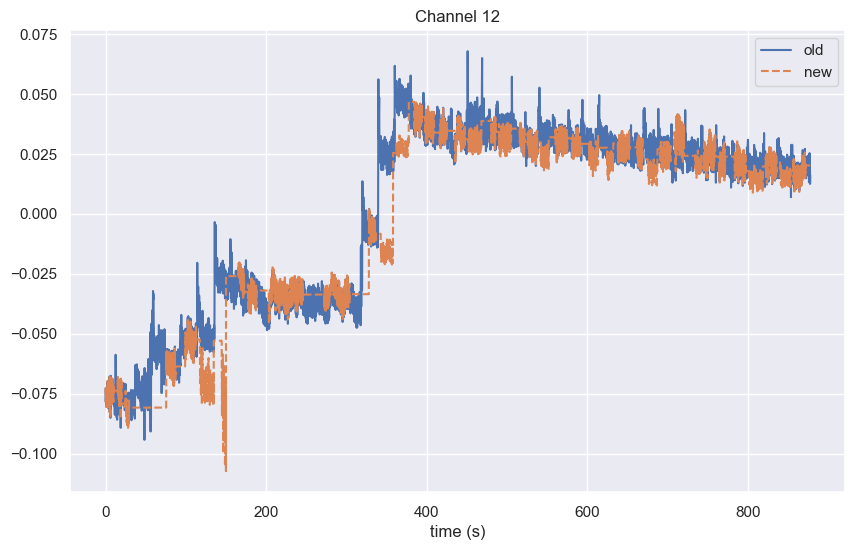

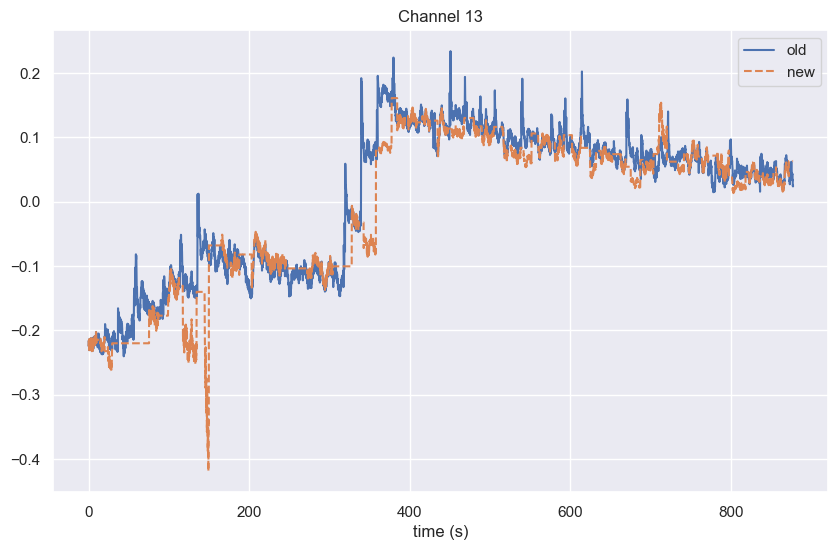

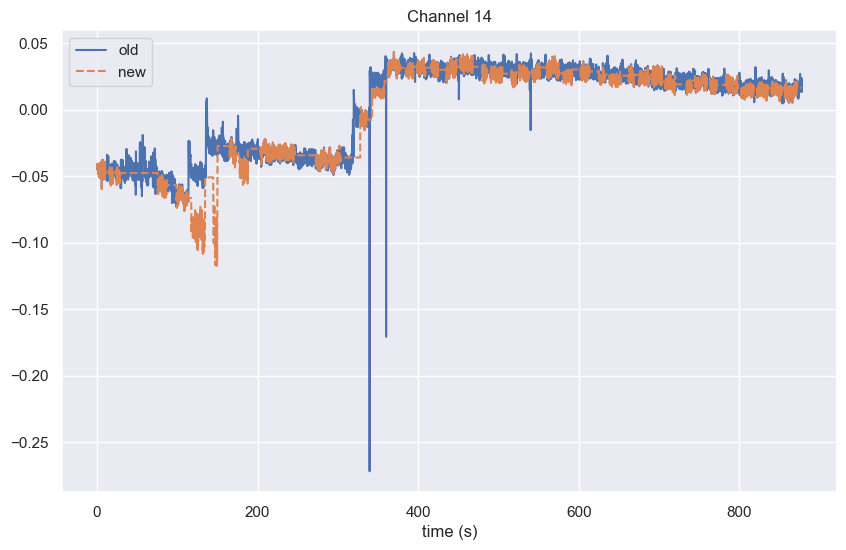

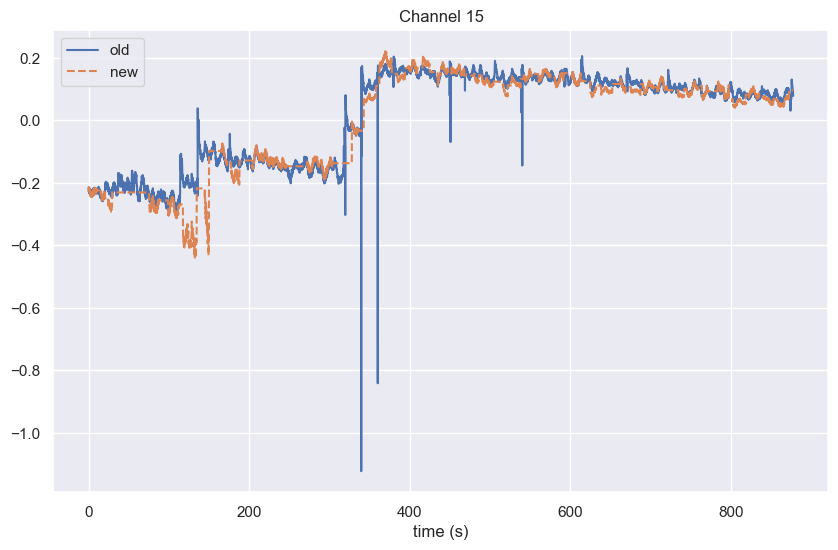

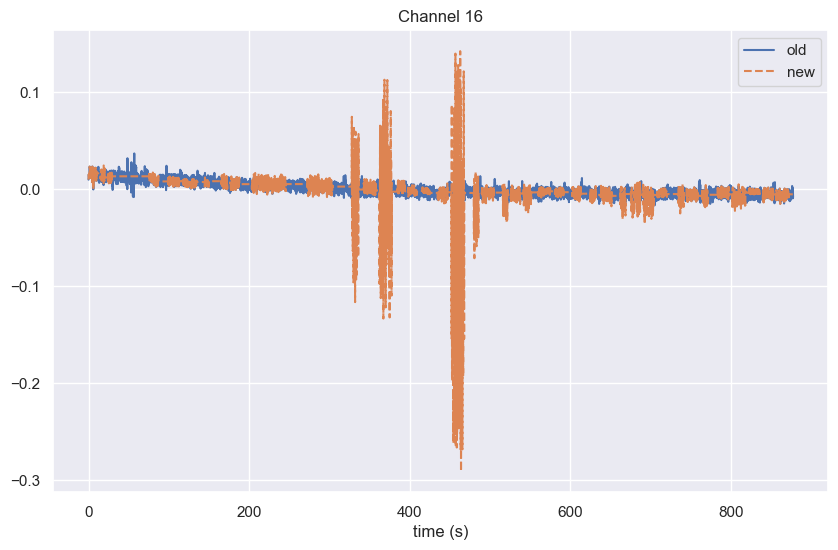

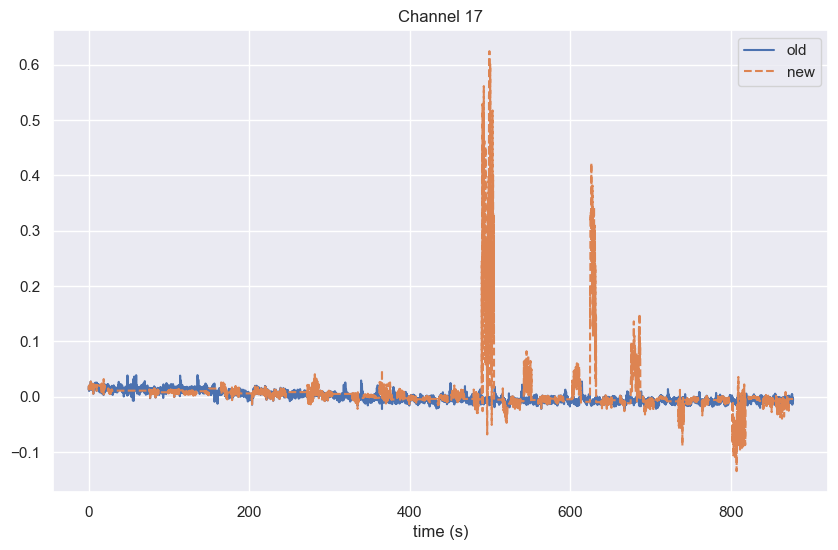

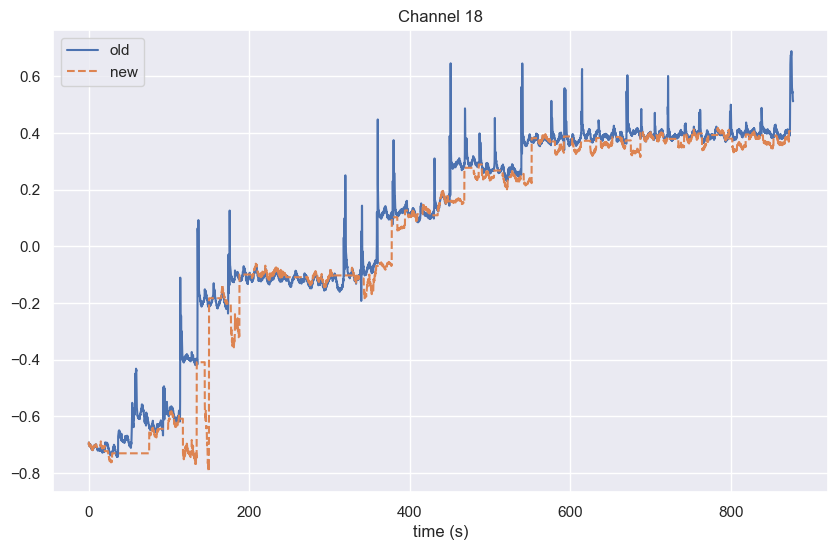

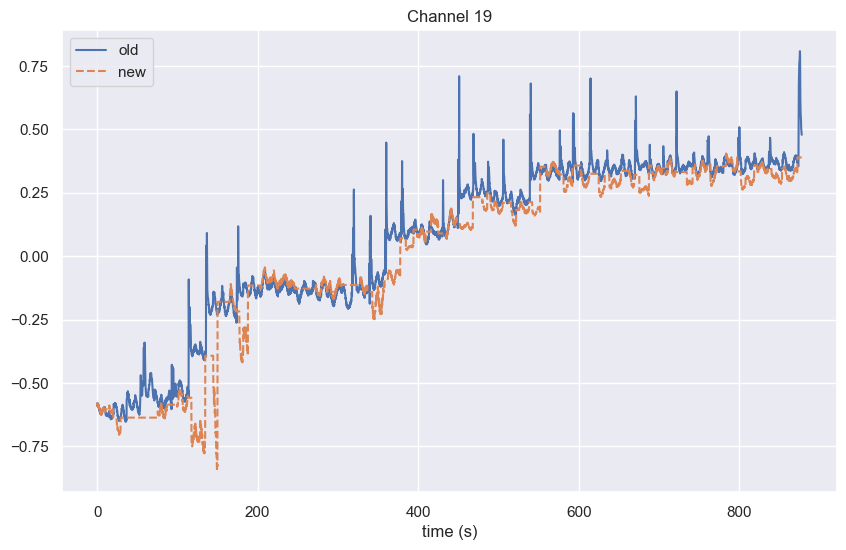

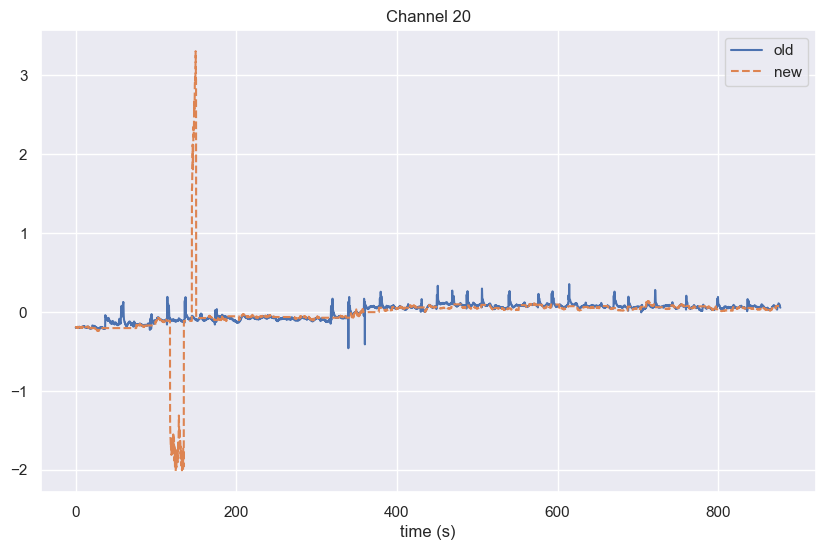

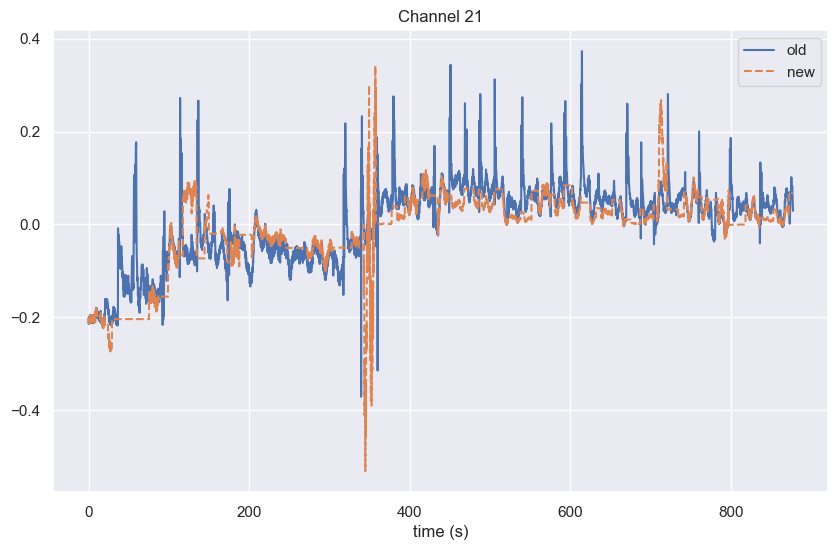

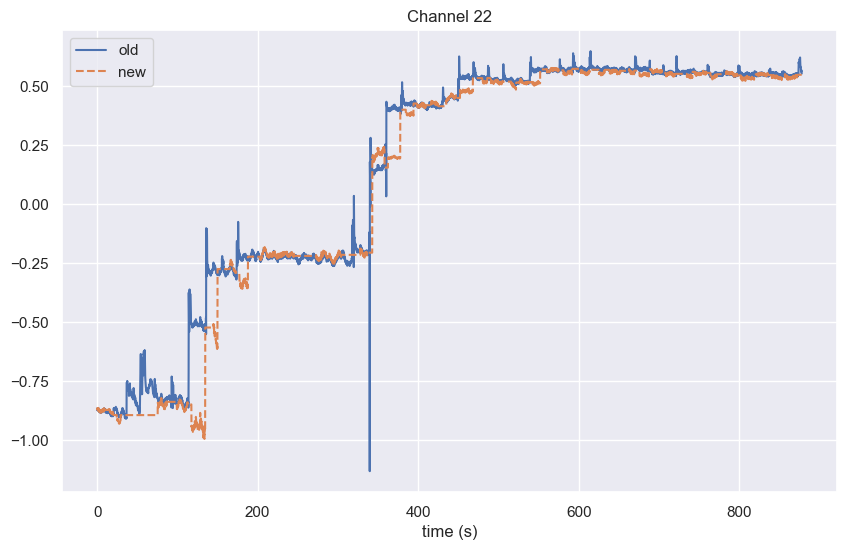

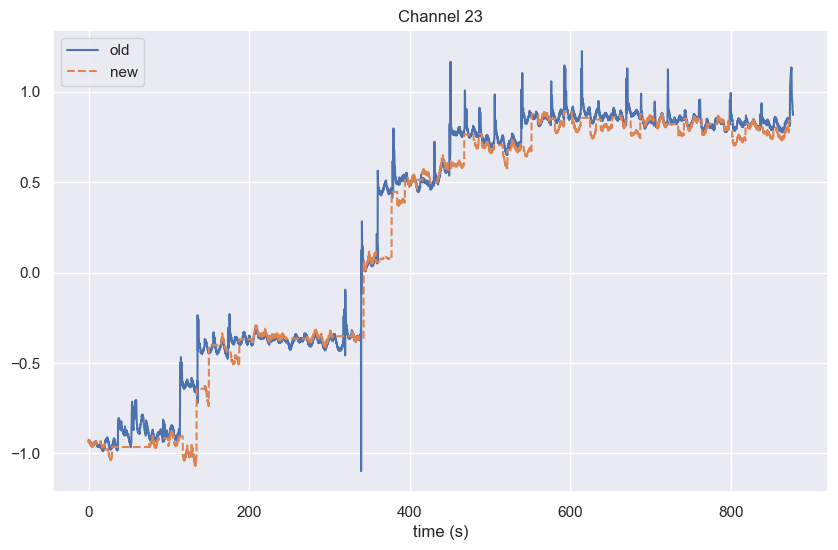

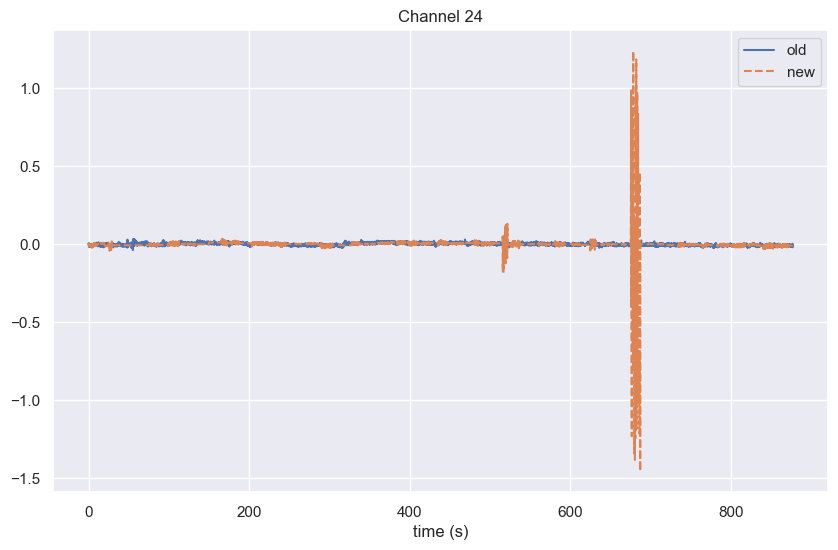

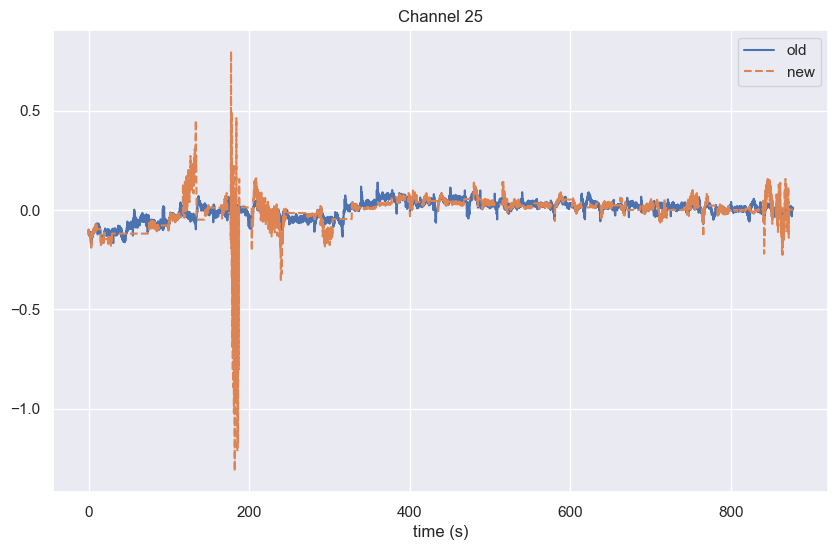

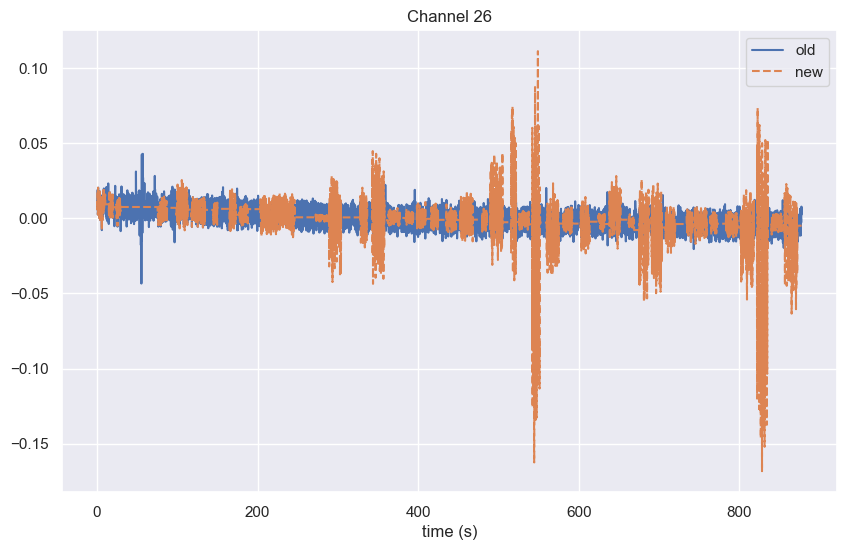

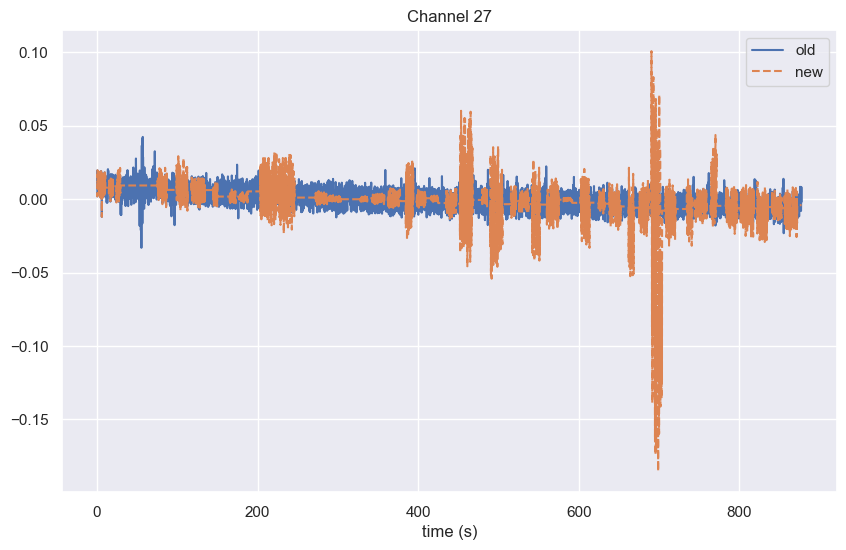

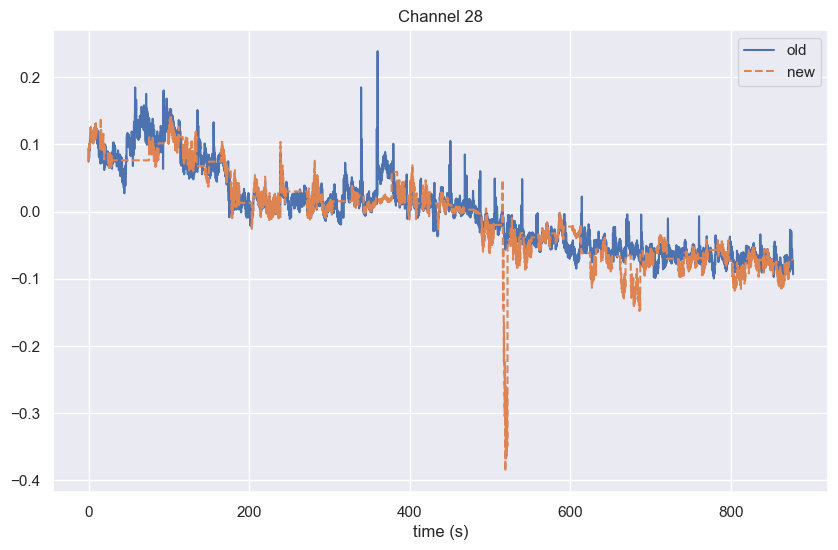

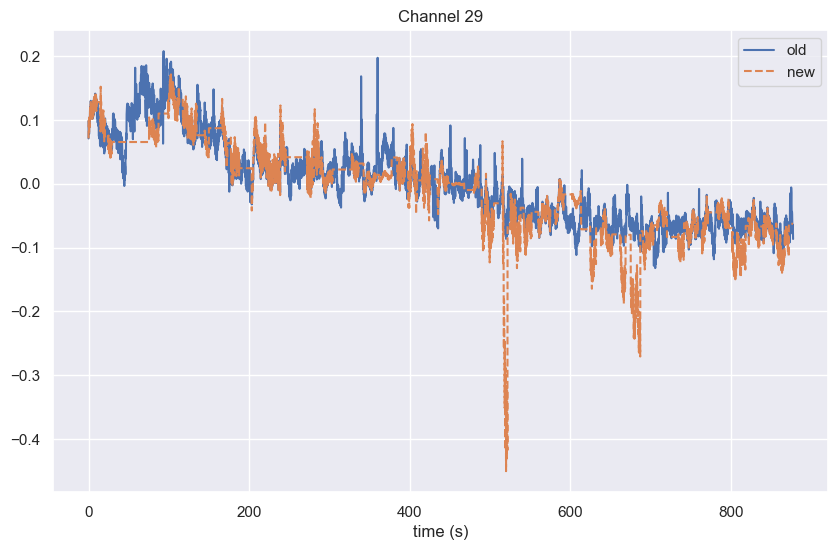

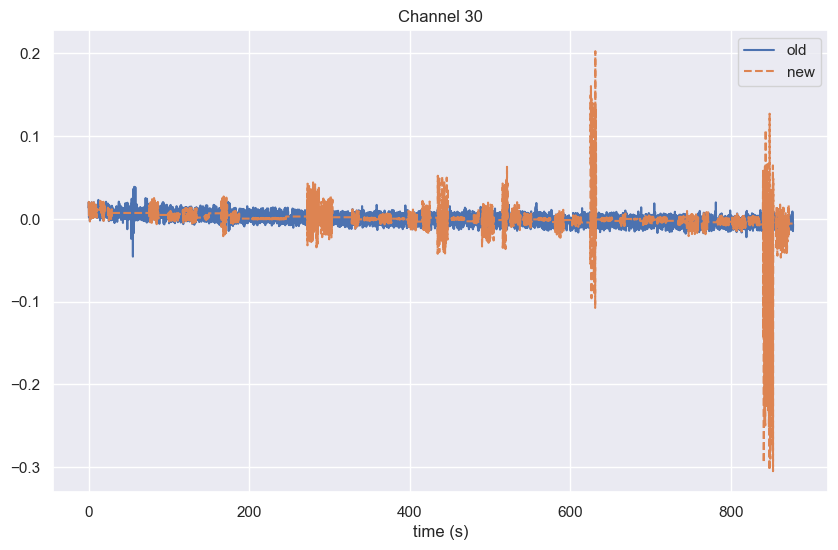

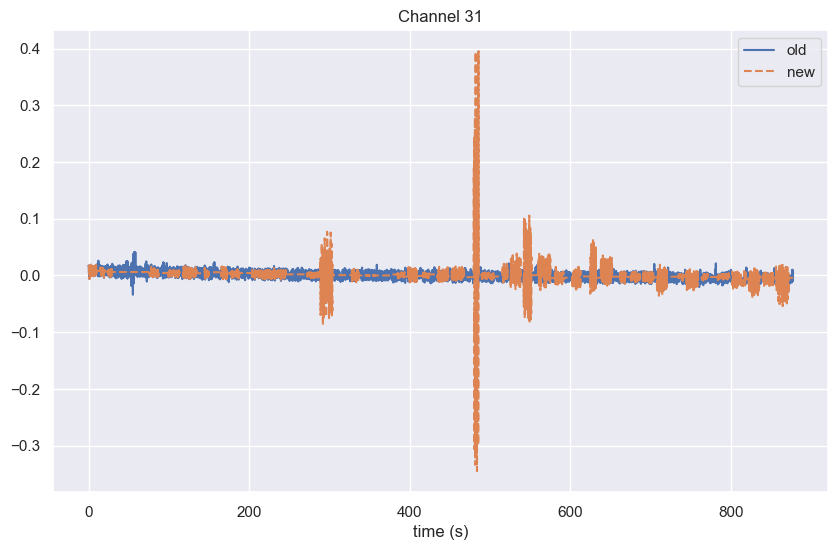

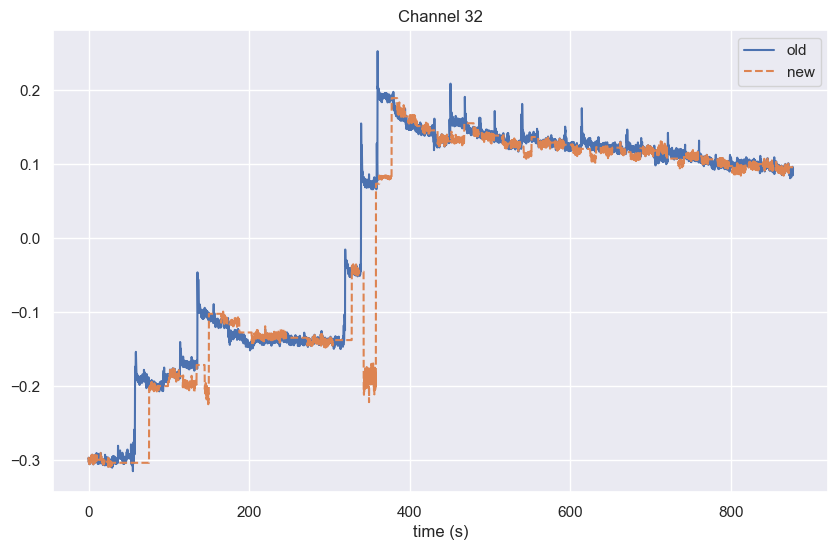

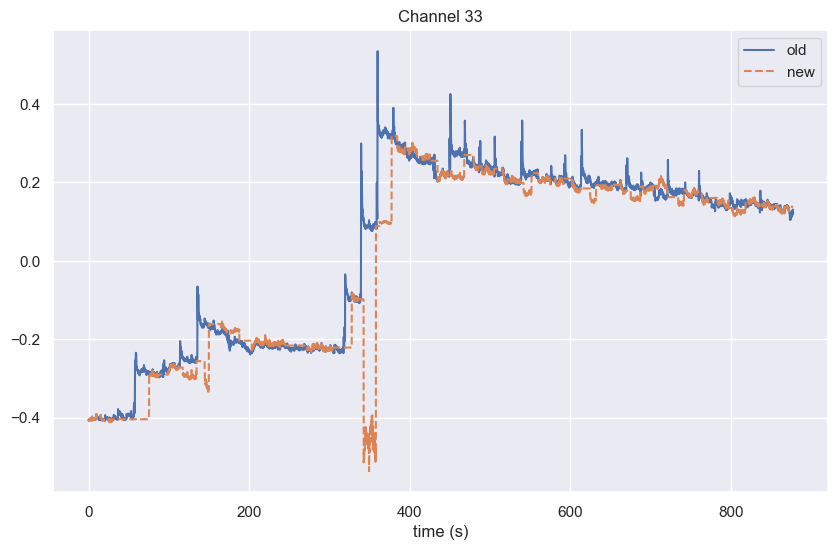

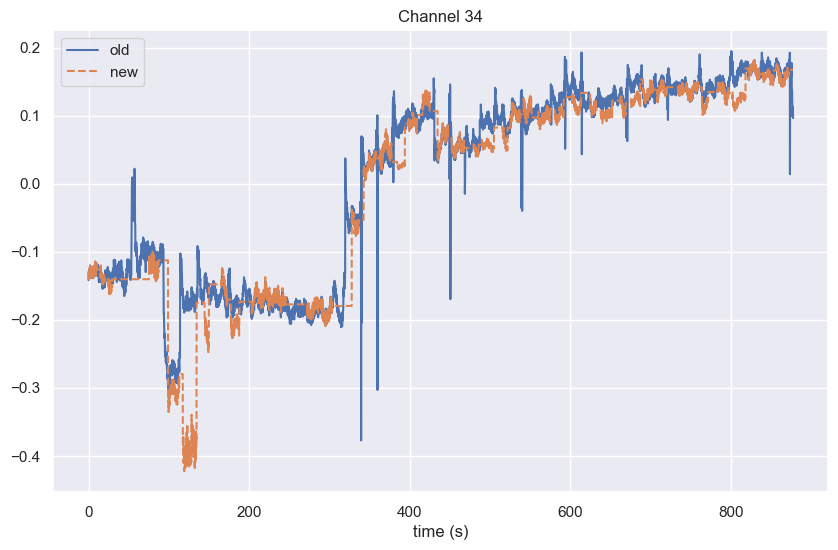

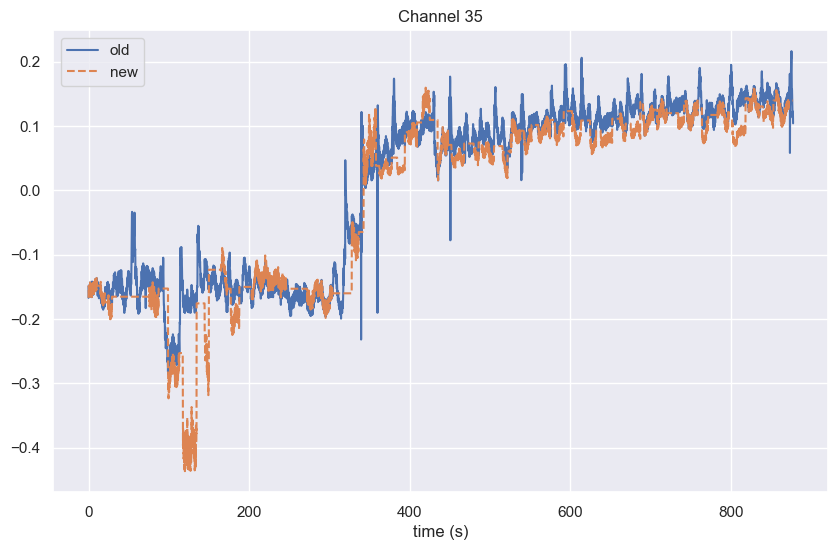

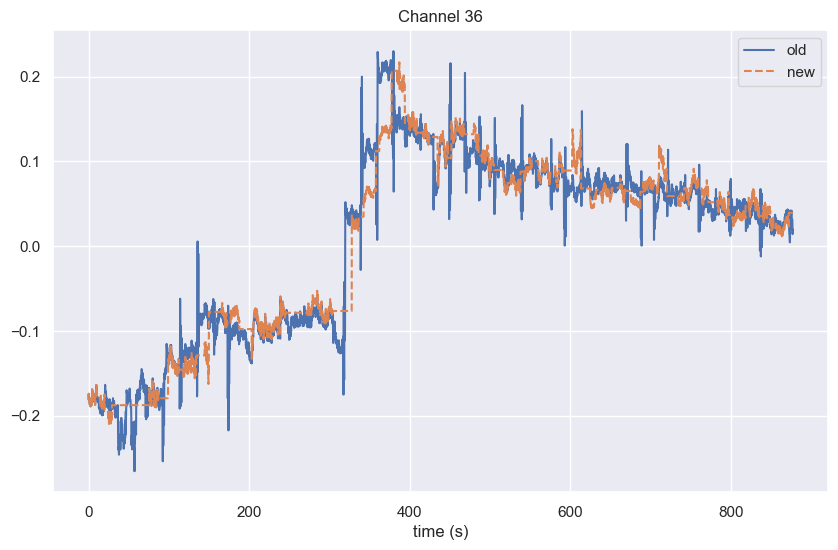

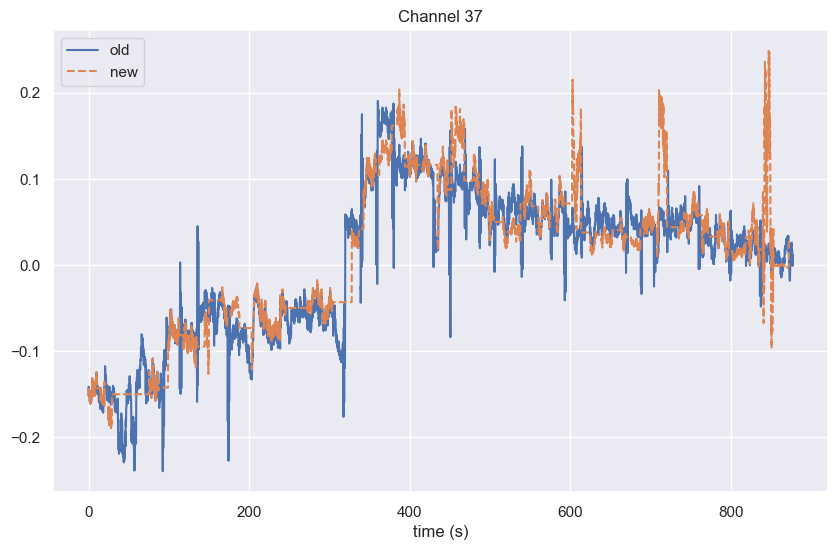

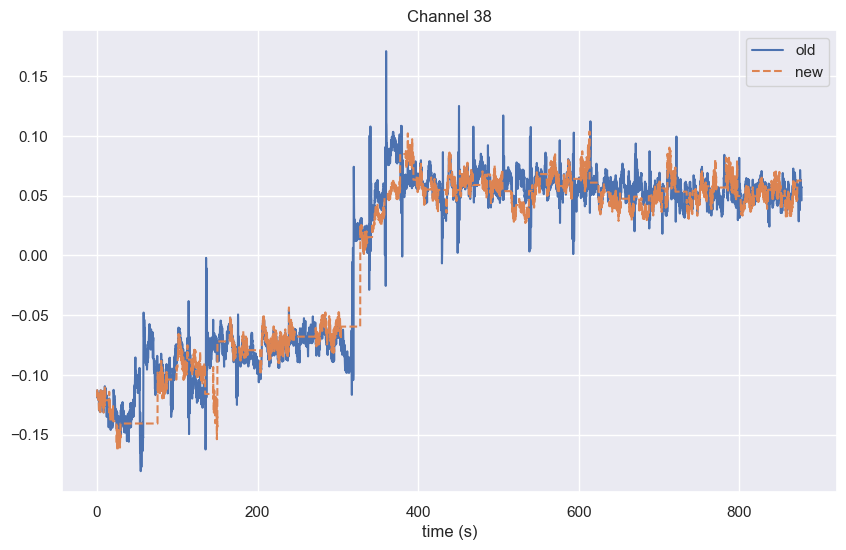

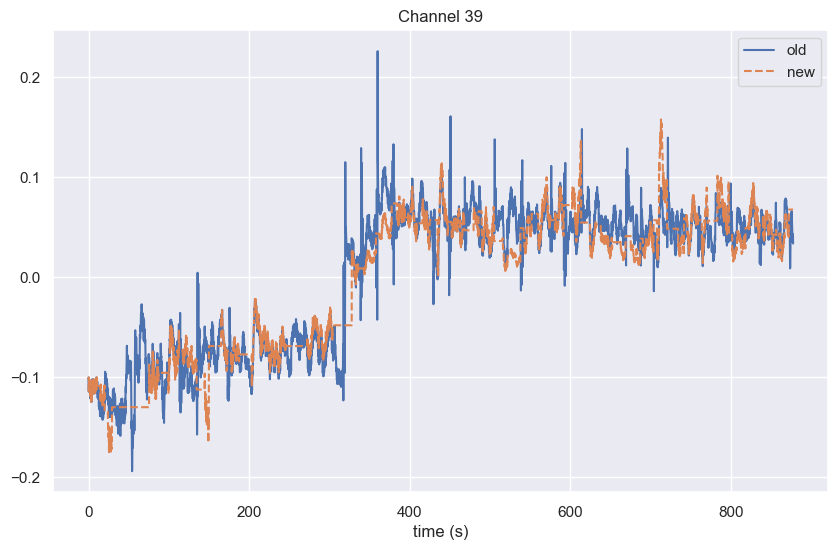

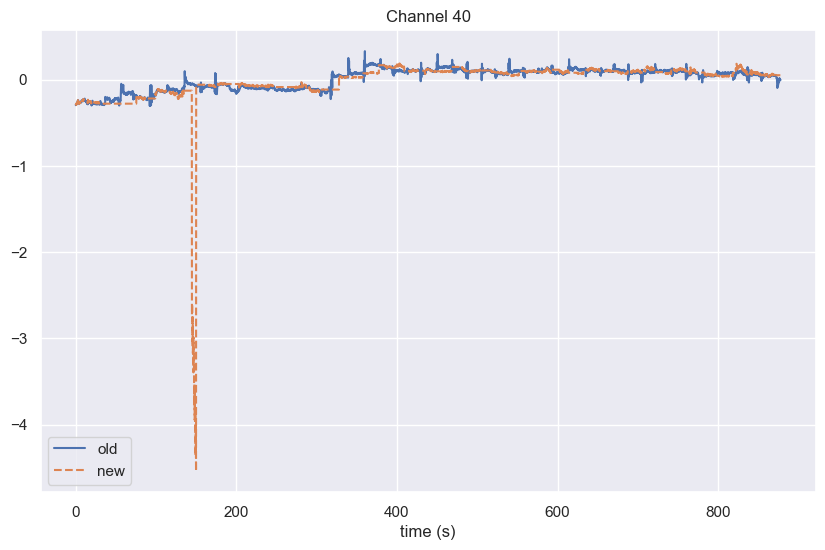

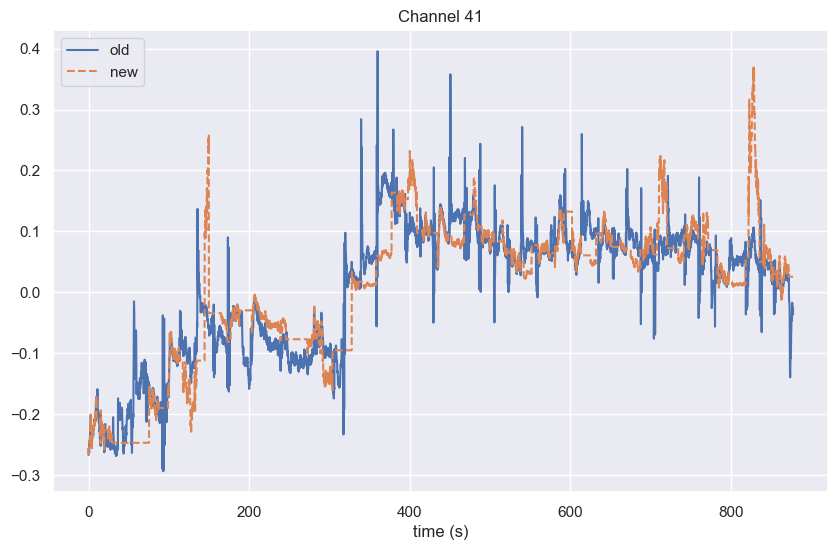

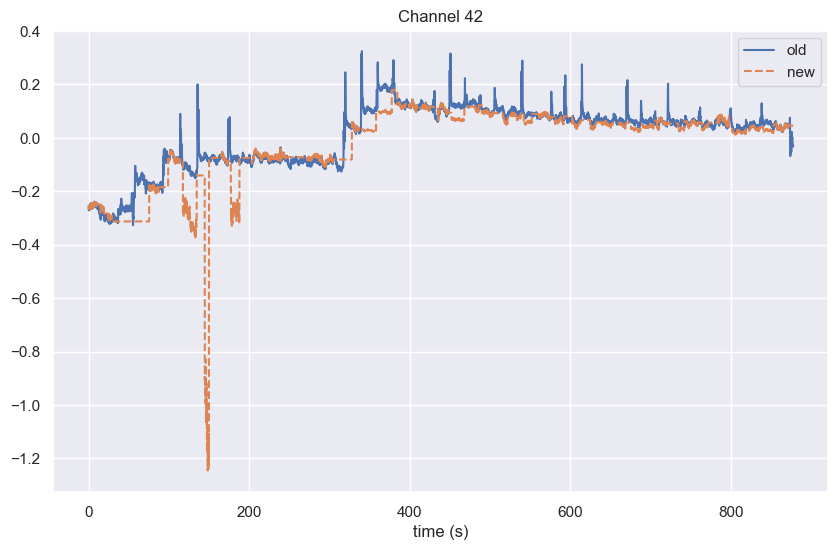

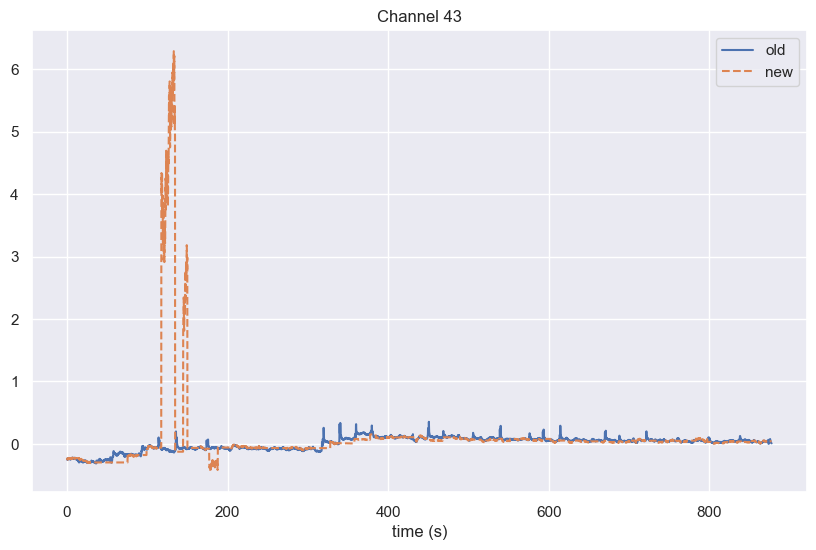

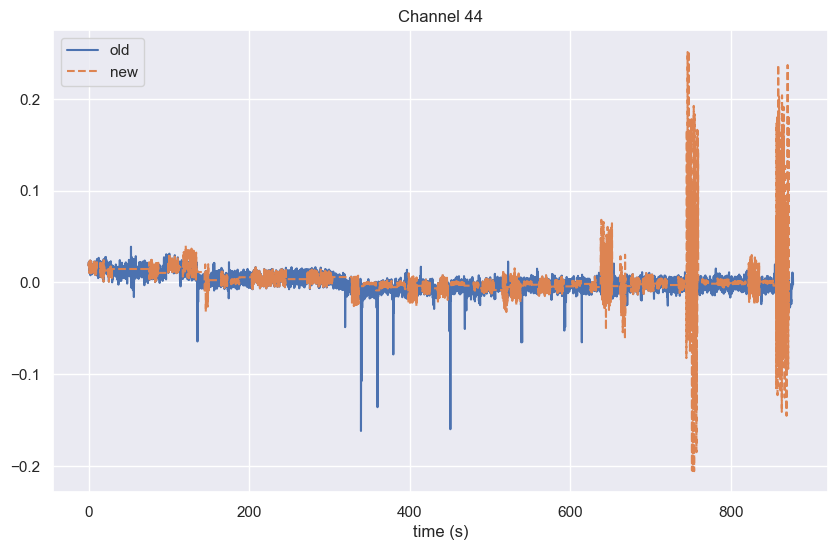

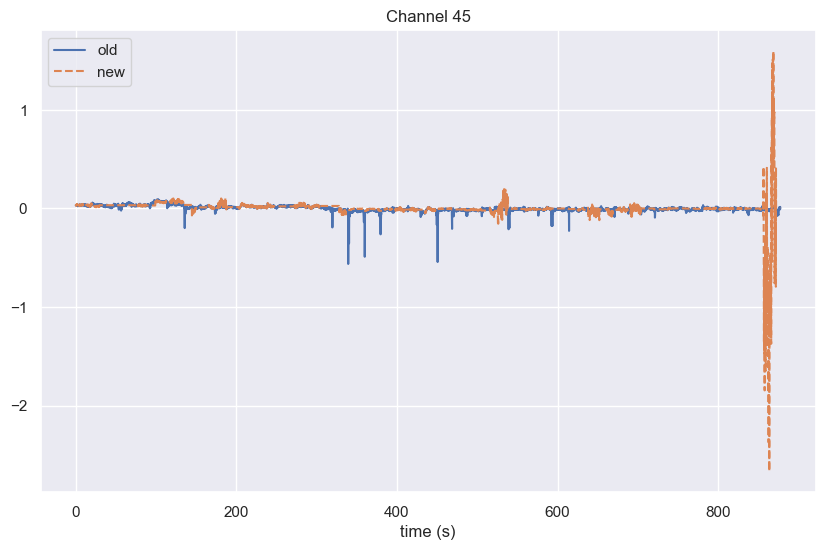

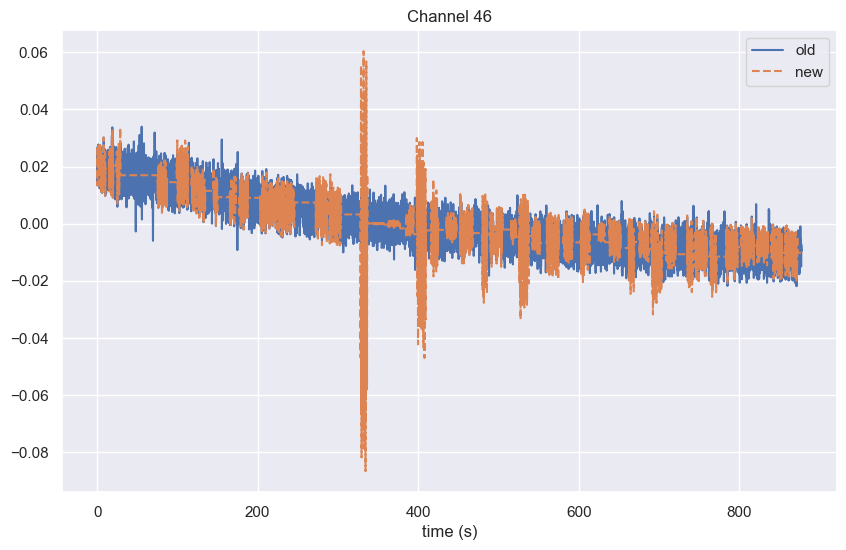

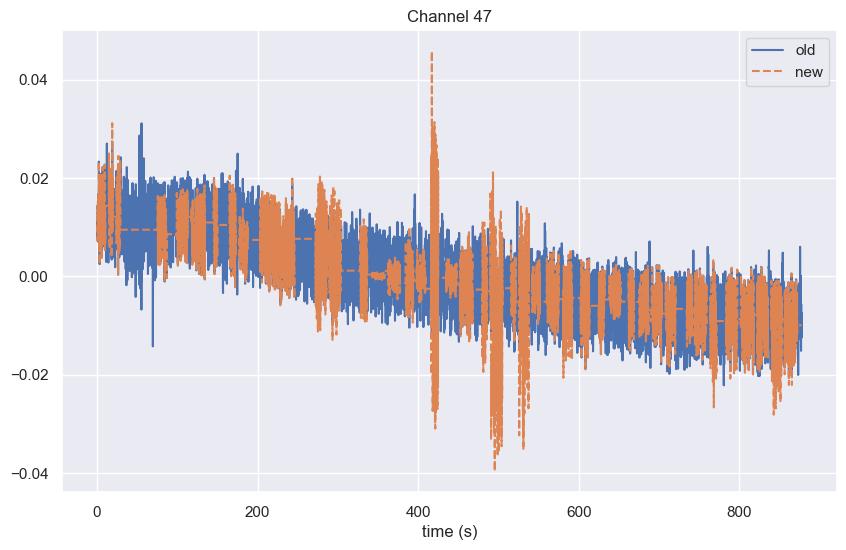

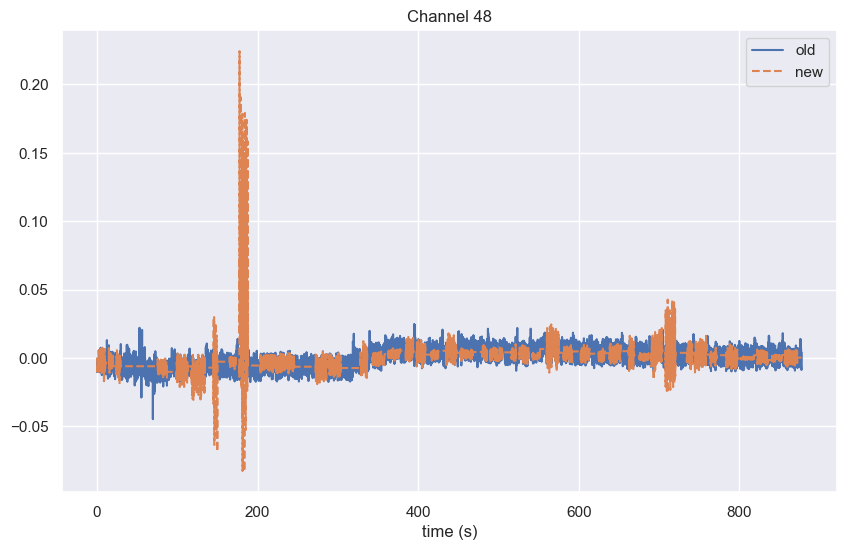

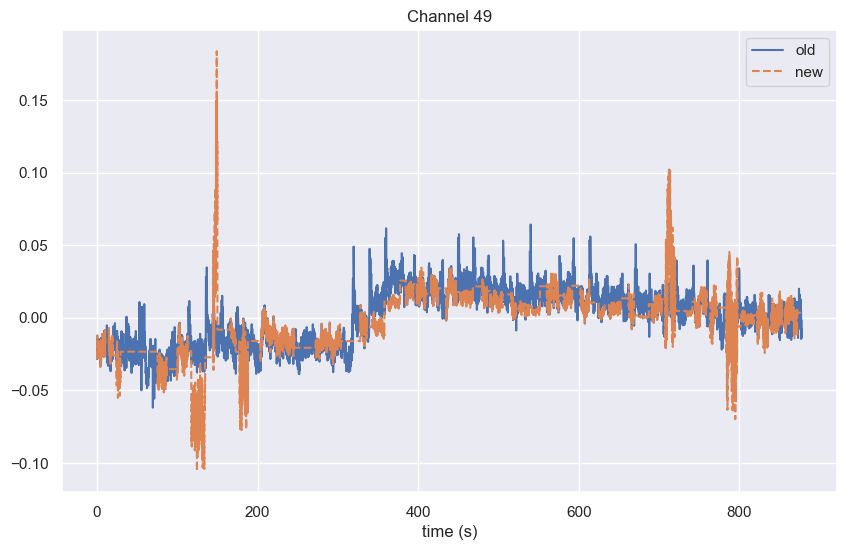

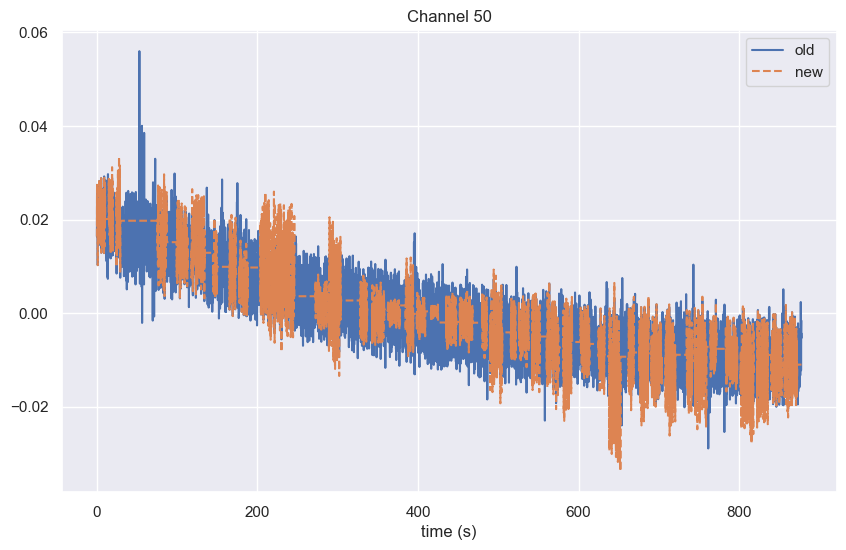

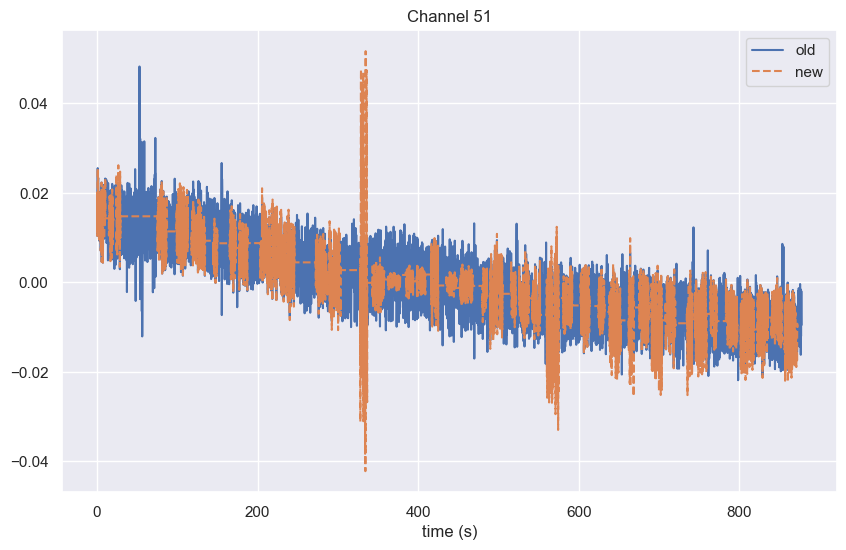

In [22]:
#tmin, tmax = 105, 195
# s_start = round(tmin*raw_MA_od.info['sfreq'])
# s_end = round(tmax*raw_MA_od.info['sfreq']) + 1
# a_x, a_y = acc_df.to_numpy().T[:2, s_start:s_end]/9.81 # Convert to g instead of m/s^2
a_x, a_y = acc_df.to_numpy().T[:2]/9.81
raw_MA_od_ABAMAR = raw_MA_od.copy()
Z = raw_MA_od_ABAMAR.get_data()
# Z = raw_MA_od.copy().crop(tmin, tmax).get_data()
fs = raw_MA_od.info['sfreq']
_, __ = find_ME(a_x, a_y, fs, plot = True)
Z_new = ABAMAR(Z, a_x, a_y, fs, plot = True)
raw_MA_od_ABAMAR._data = Z_new

In [23]:
raw_MA_od_ABAMAR

<RawSNIRF | romane_vorwald ma_22_20240508-133500.snirf, 52 x 5163 (877.5 s), ~2.1 MB, data loaded>

---
> *Remark:*
- a
- b
- c   
---

#### Active noise cancelation <a class="anchor" id="sub_section_1_3_2"></a>

Add text if works

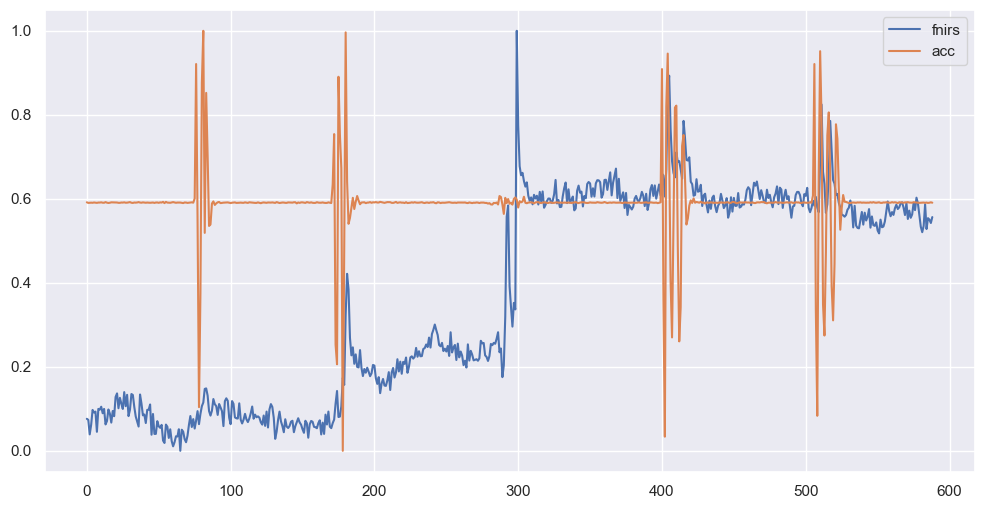

In [24]:
tmin, tmax = 400, 500
noisy_signal = raw_MA_od.copy().crop(tmin, tmax).get_data(picks = ['S8_D4 760'])[0]
s_start = round(tmin*raw_MA_od.info['sfreq'])
s_end = round(tmax*raw_MA_od.info['sfreq']) + 1
acc_data = acc_df.to_numpy().T[:, s_start:s_end][0]
# scale:
acc_data = (acc_data - np.min(acc_data))/(np.max(acc_data)-np.min(acc_data))
noisy_signal = (noisy_signal - np.min(noisy_signal))/(np.max(noisy_signal)-np.min(noisy_signal))
plt.figure(figsize=(12,6))
plt.plot(noisy_signal, label ='fnirs')
plt.plot(acc_data, label = 'acc')
plt.legend()
plt.show()

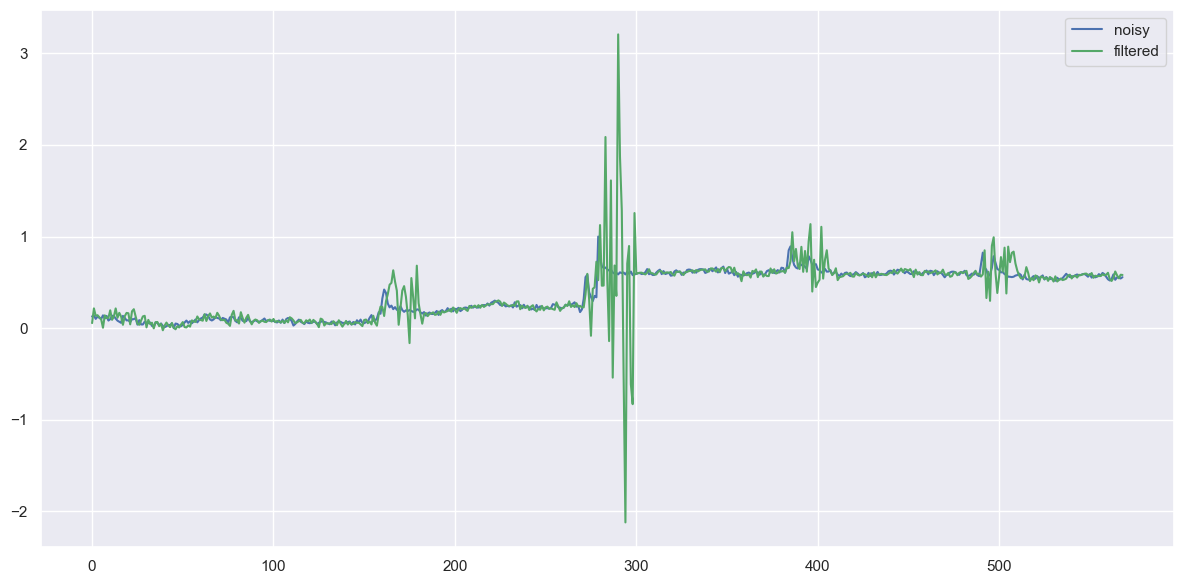

In [25]:
import padasip as pa
# signals creation: u, v, d

n = 20
v = acc_data
d = noisy_signal

# filtering
x = pa.input_from_history(d, n)[:-1]
d = d[n:]
f = pa.filters.FilterRLS(mu=0.9, n=n)
y, e, w = f.run(d, x)


# results
plt.figure(figsize=(12,6))
plt.plot(d, "b", label="noisy")
plt.plot(y, "g", label="filtered")
plt.legend()
plt.tight_layout()
plt.show()

---
> *Remark:*
- No good result
- Do not understand completely functioning
---

### Signal processing methods <a class="anchor" id="section_1_4"></a>

#### Wavelet filtering <a class="anchor" id="sub_section_1_4_1"></a>

Molavi and Dumont (2012) introduced the wavelet-based motion artifact removal technique, which operates on a channel-by-channel basis. According to Brigadoi et al. (2014), this method involves applying the discrete wavelet transform (DWT) to each channel's data series across various levels of decomposition, denoted by $L$, corresponding to the time series duration. At each level, a set of detail and approximation coefficients is generated.

The WF relies on the assumption that (1) coefficients associated with the evoked response will center around zero with minimal variance, while those significantly deviating from this Gaussian distribution typically represent MAs. Thus, identifying and neutralizing these outlier coefficients before reconstructing the signal using the inverse discrete wavelet transform (IDWT) should effectively remove the corresponding MAs from the temporal time-series. 

Outliers are pinpointed based on a probability threshold denoted by $\alpha$. If the probability associated with a specific wavelet detail coefficient falls below $\alpha$, it is considered to deviate from the Gaussian distribution and is therefore treated as an outlier, set to zero. Hence, the parameter $\alpha$ serves as the tuning parameter for WF and is often set to 0.1. This corresponds to categorizing coefficients with a probability of less than 10\% of being part of the haemodynamic signal as artifacts.

In [26]:
# Define wavelet function for a signle channel
def wavelet(data, fs, wavelet_type = 'db5', mode = 'symmetric', level = None, alpha = 0.1, plot = False):
    
    # Describe properties of a discrete wavelet
    wavelet = pywt.Wavelet(wavelet_type)
    
    # Calculate approximation and detail coefficients (cA (LF), cD (HF))
    coeff = pywt.wavedec(data, wavelet, mode=mode, level=level, axis=-1) 
    # Daubechies 5 (db5) wavelet, If level is None (default) then it will be calculated using the dwt_max_level function.
    # dwt_max_level stops decomposition when the signal becomes shorter than the FIR filter length for a given wavelet.
    # Structure of coeff: [cA_n, cD_n, cD_n-1, …, cD2, cD1]
    
    # Create empty new coefficient array and fill first element (Ac)
    coeff_new = []
    coeff_new.append(coeff[0])
    
    # Remove Ac element for wavelet filtering
    coeff.pop(0)
    n = len(coeff)

    # Create empty variance array and fill with median absolute deviation (MAD) (Hoaglin et al 1983)
    sigma = np.zeros(n)
    for i, coefficient in enumerate(coeff):
        sigma[i] = np.median(abs(coefficient))/0.6745 
    
    # Artifacts are treated as large outliers added to the desired coefficients∼ N(0,σ2).
    for i in range(n):
        prob = 2*(1 - norm.cdf(abs(coeff[i]/sigma[i])))
        coeff_new.append(np.where(prob > alpha, coeff[i], 0))
        
    # Perform inverse wavelet transform
    data_new = pywt.waverec(coeff_new, wavelet, mode=mode, axis=-1)

    if plot:
        # Plot original and new values
        %matplotlib inline
        time1 = np.arange(len(data))/fs
        time2 = np.arange(len(data_new))/fs
        plt.plot(time1, data, label = 'original')
        plt.plot(time2, data_new, label = 'filtered')
        plt.xlabel('time (s)')
        plt.legend()
        plt.show()

    return data_new

In [27]:
# Iterate over all channels and create new raw object
def wavelet_filter(raw, plot = False):
    
    raw = raw.copy()
    picks = _validate_nirs_info(raw.info)

    for pick in picks:
        raw._data[pick] = wavelet(raw._data[pick], raw.info["sfreq"], wavelet_type = 'db5', mode = 'symmetric', level = None, alpha = 0.1, plot = plot)

    return raw

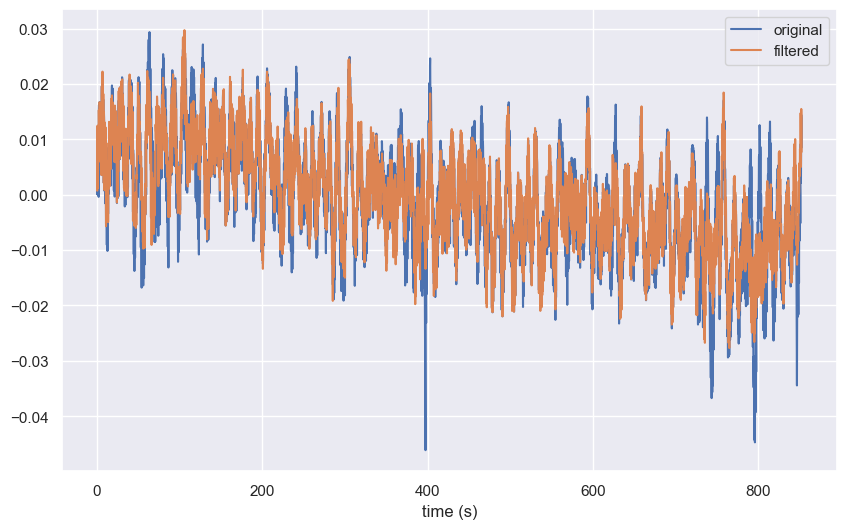

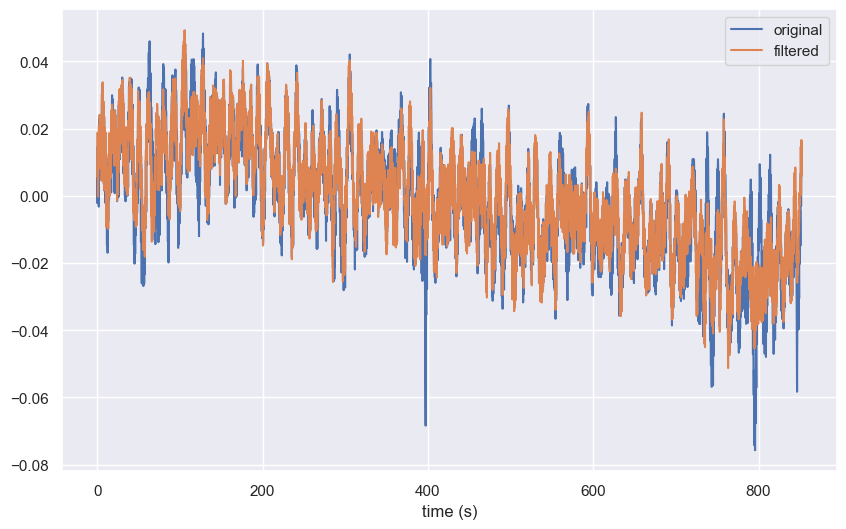

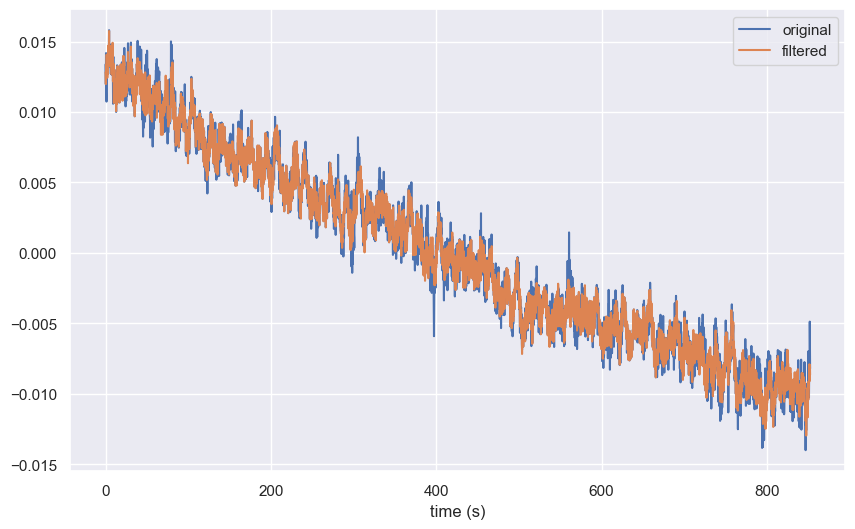

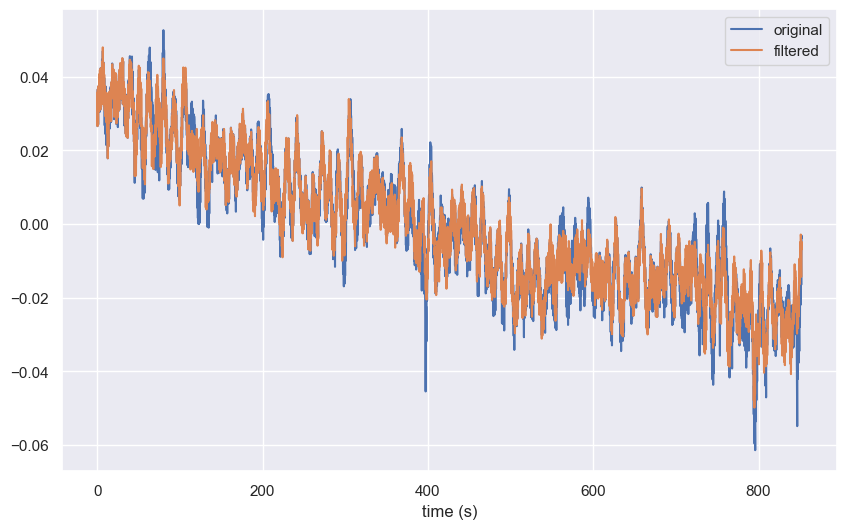

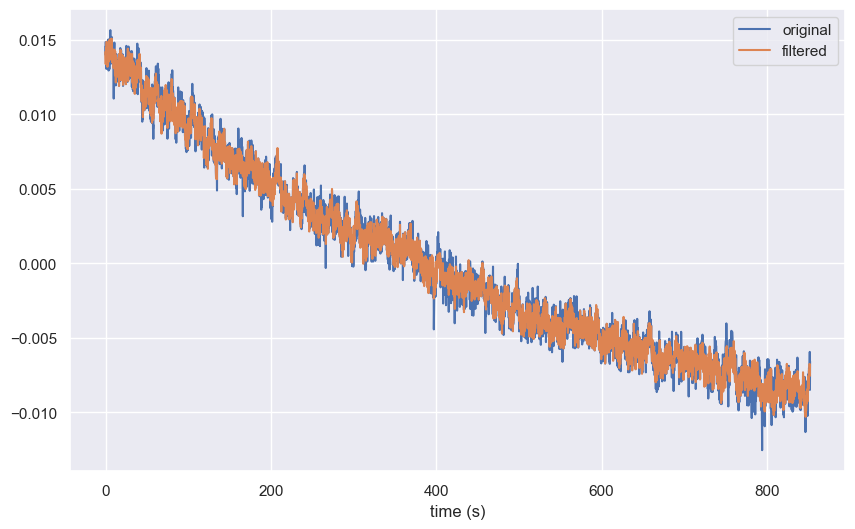

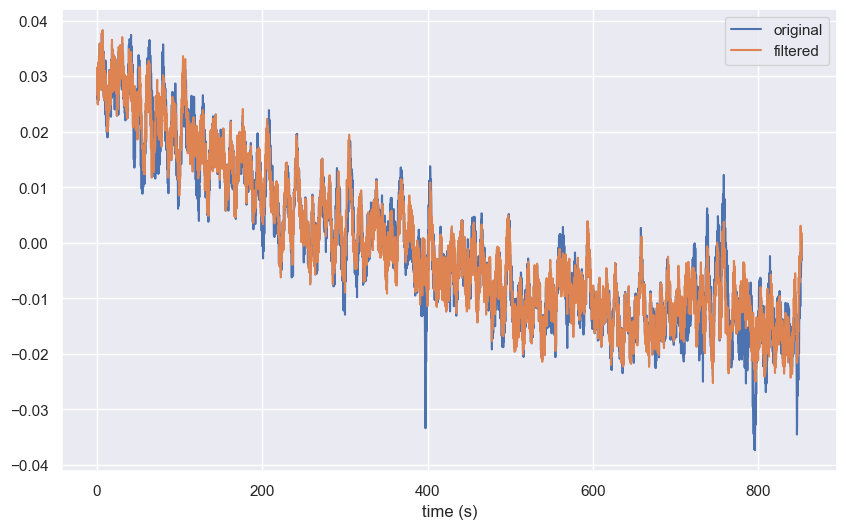

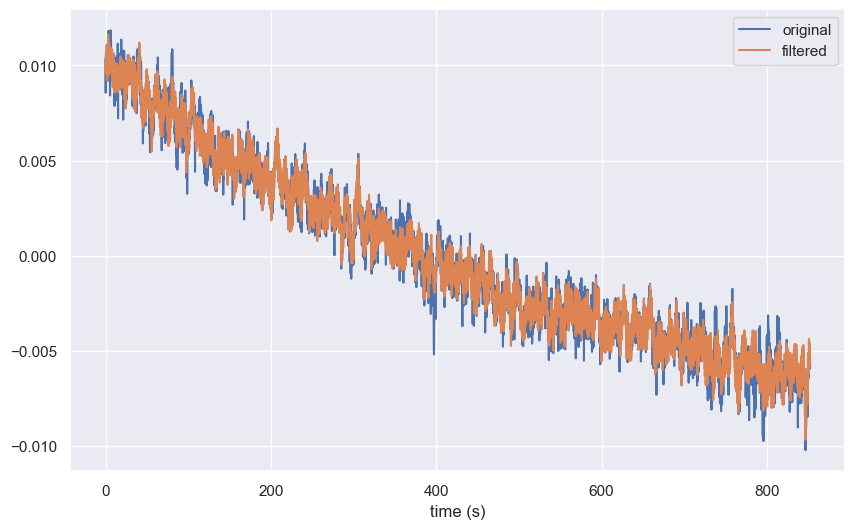

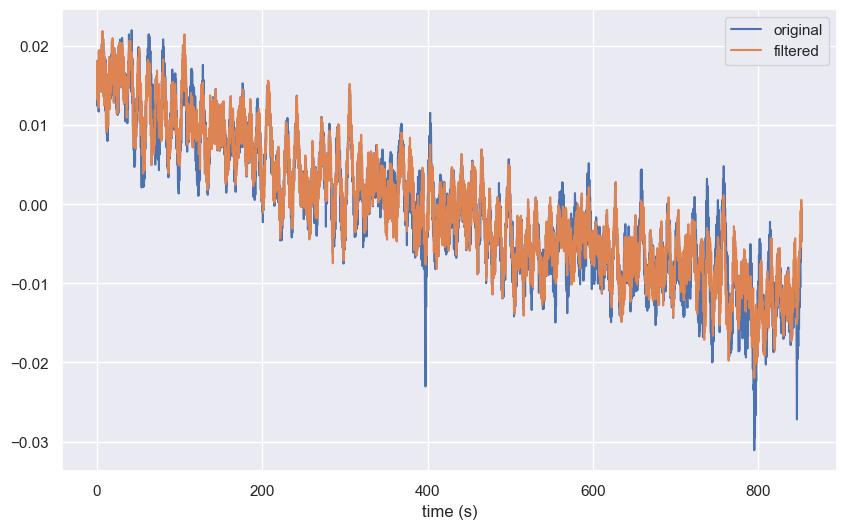

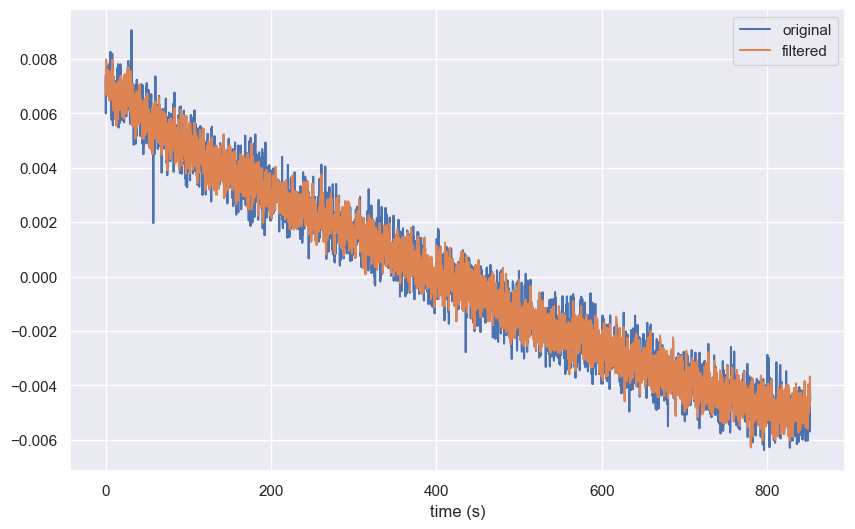

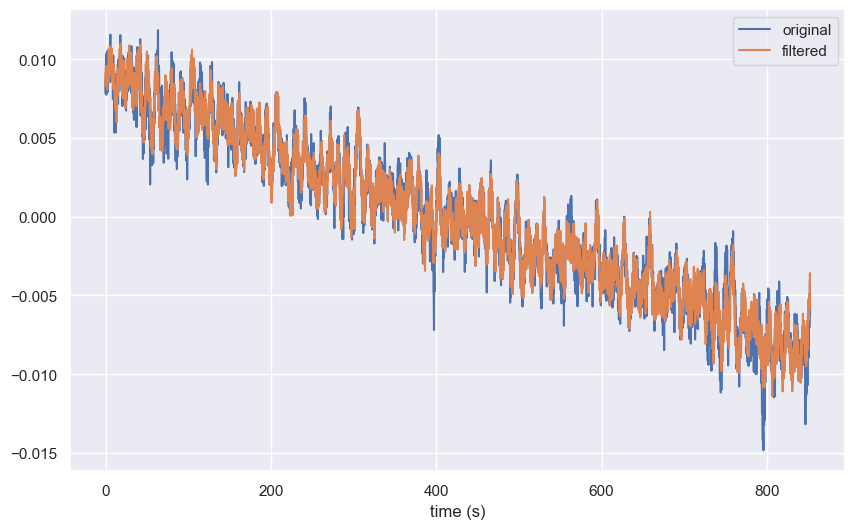

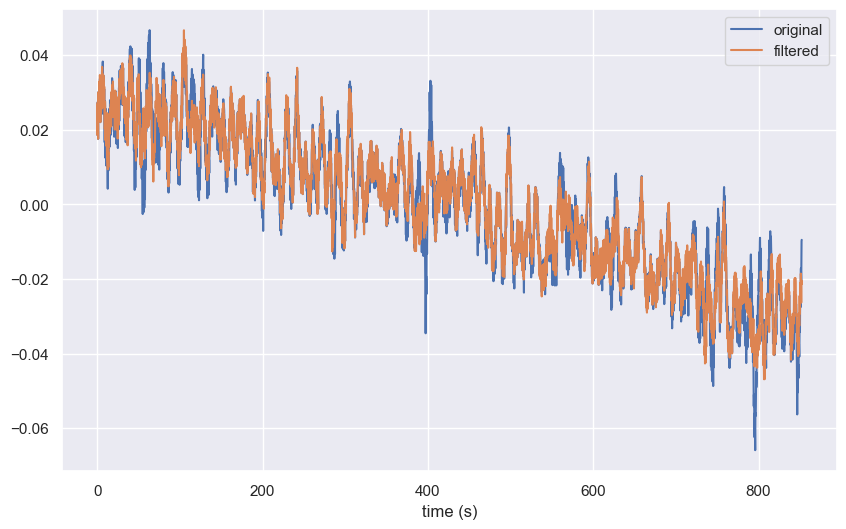

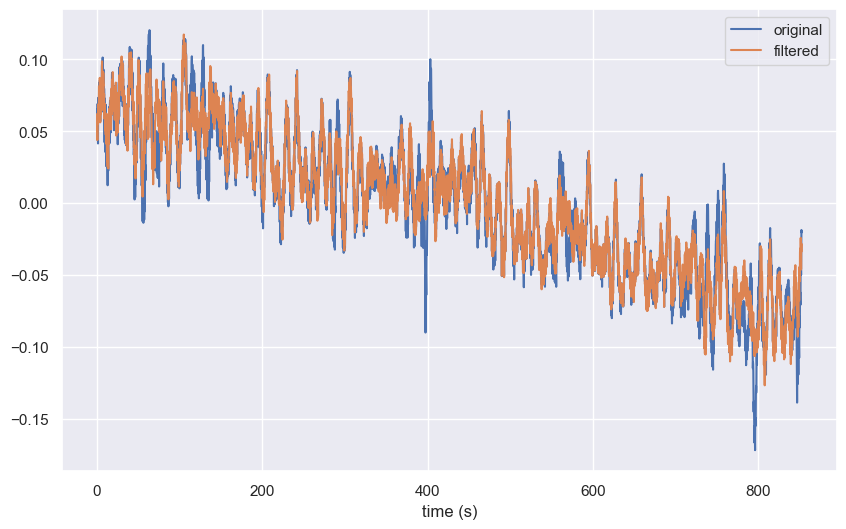

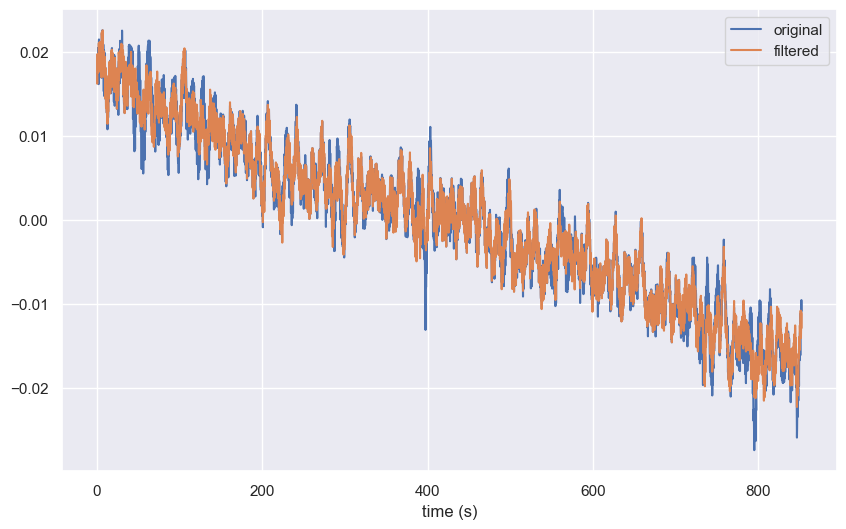

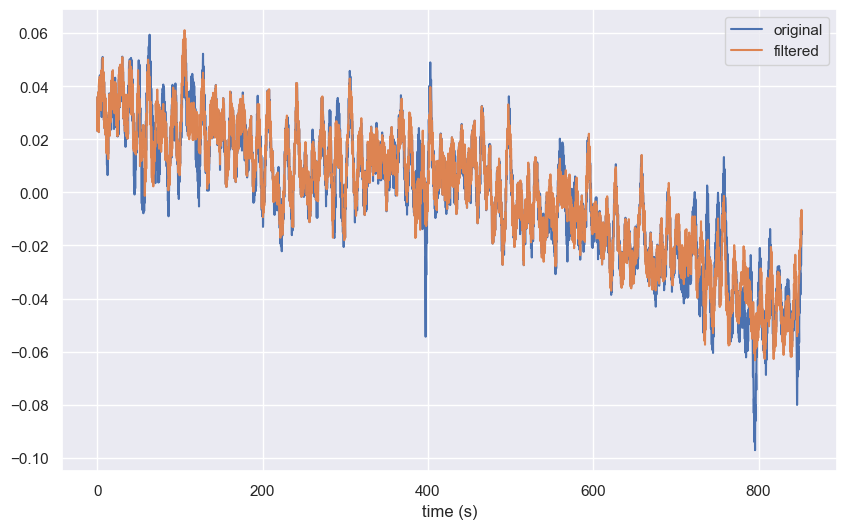

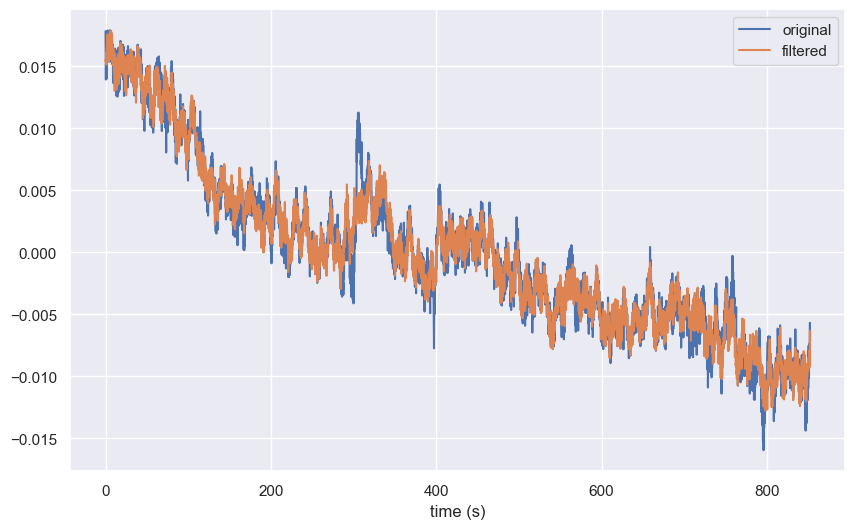

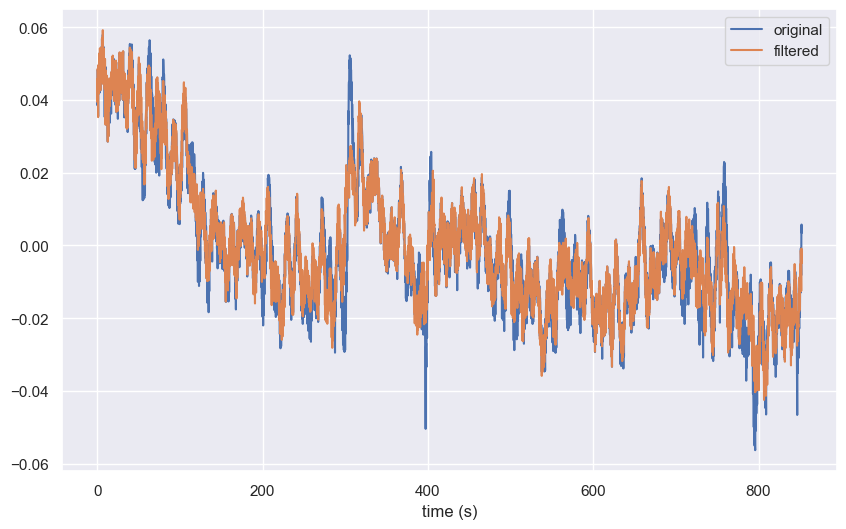

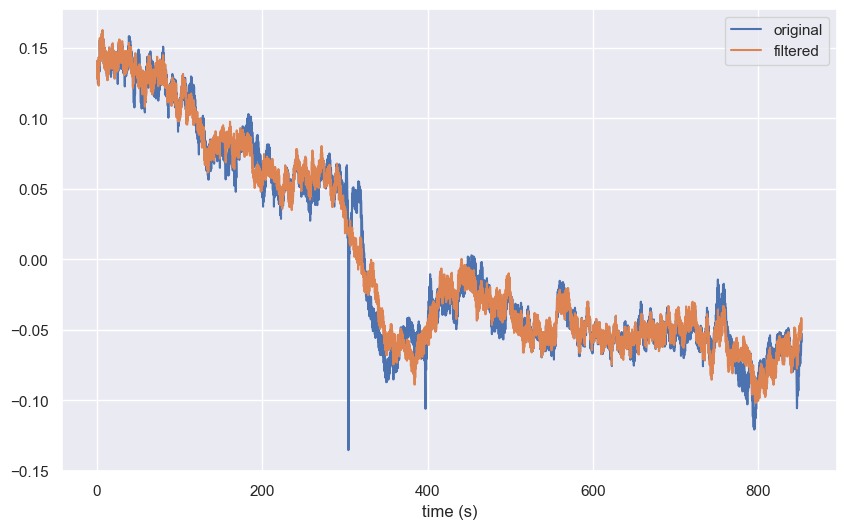

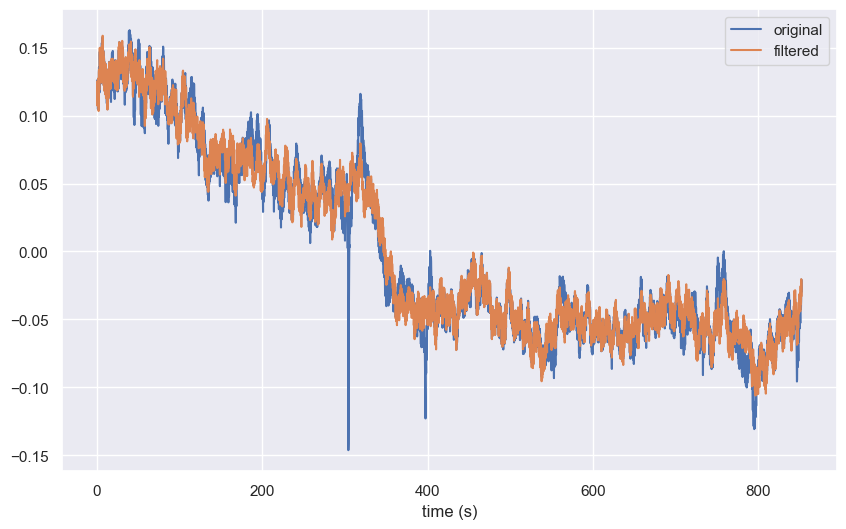

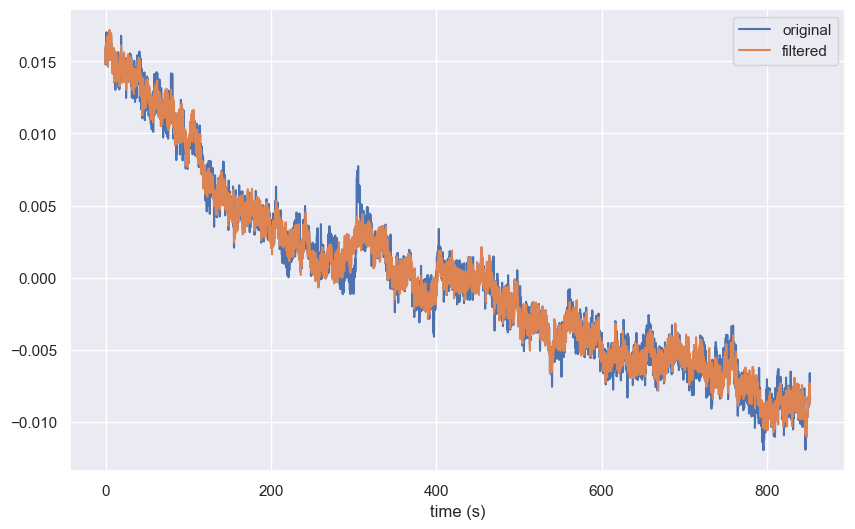

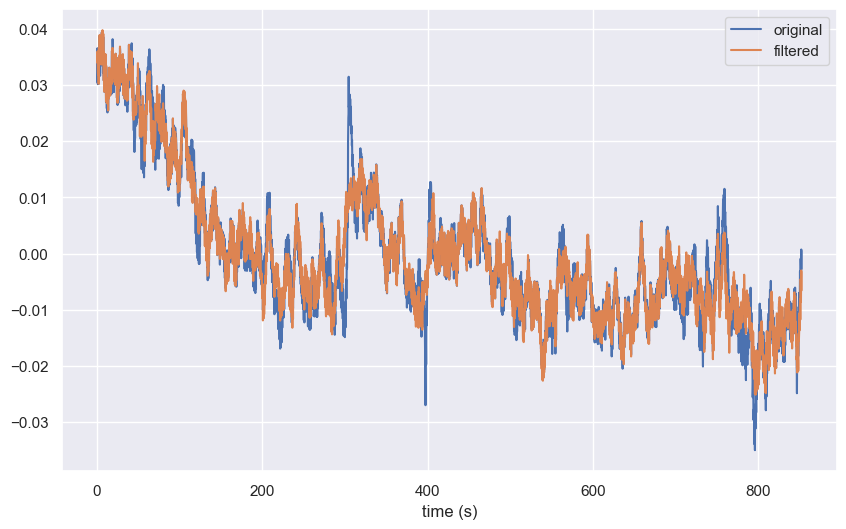

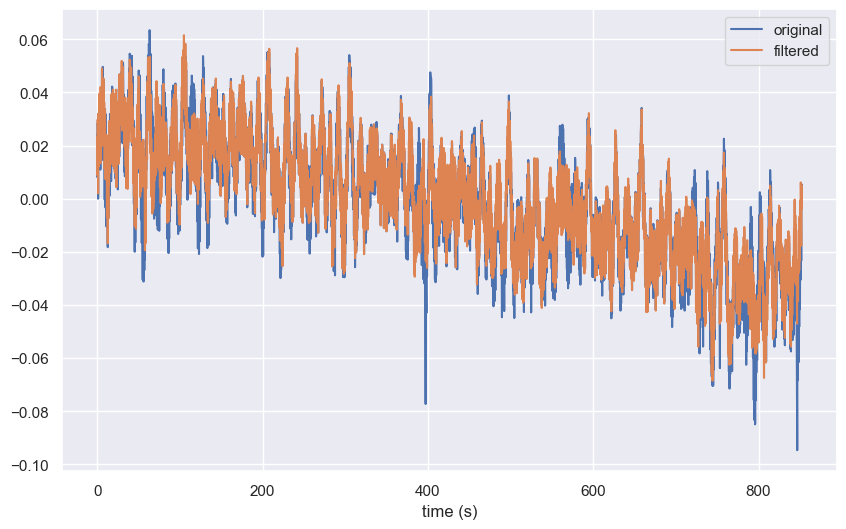

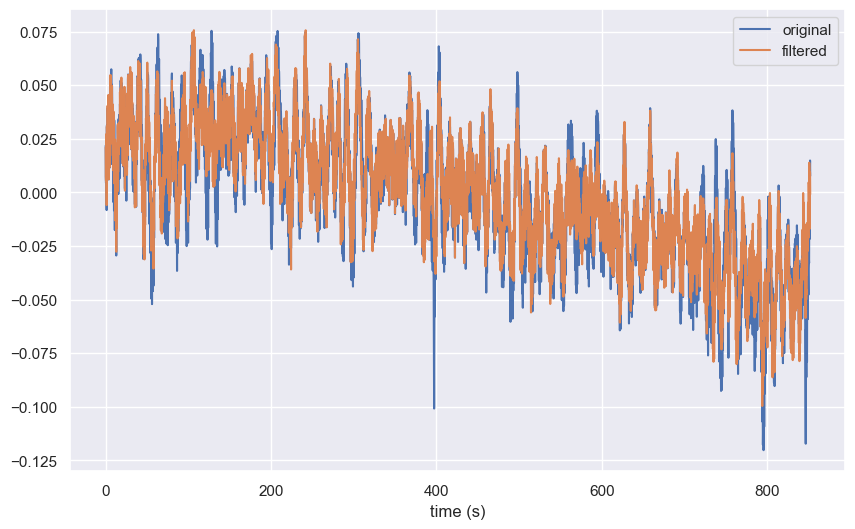

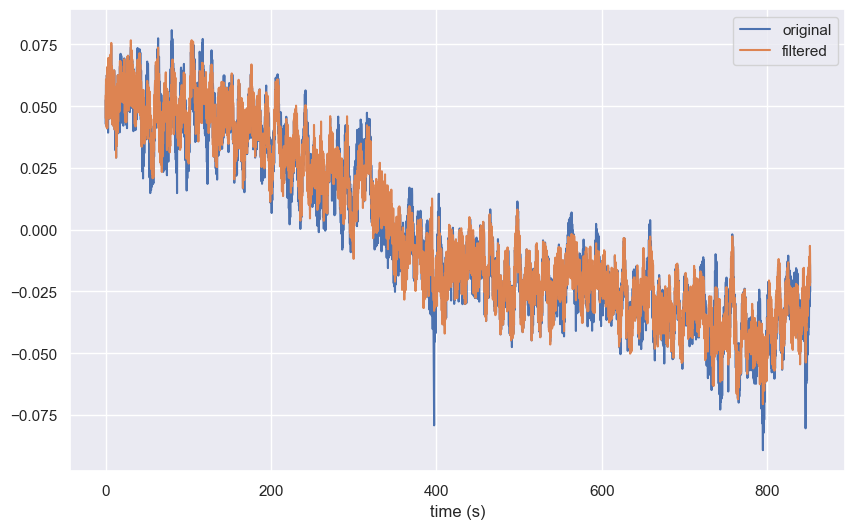

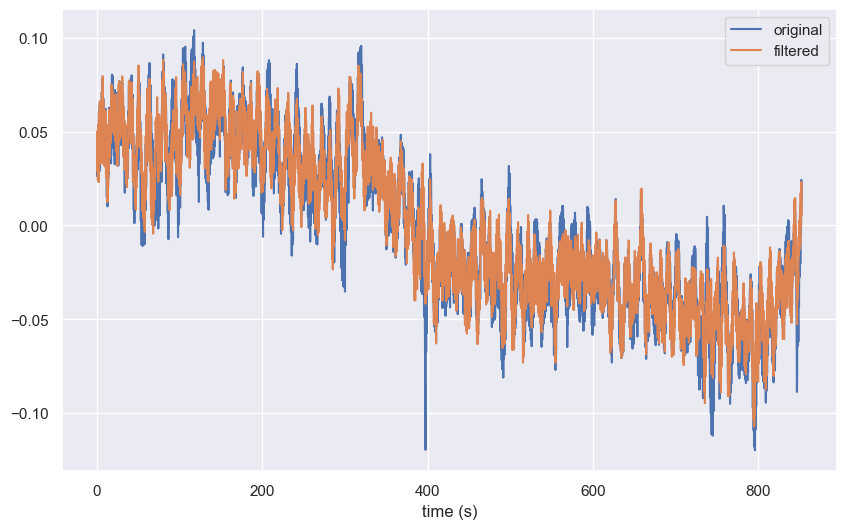

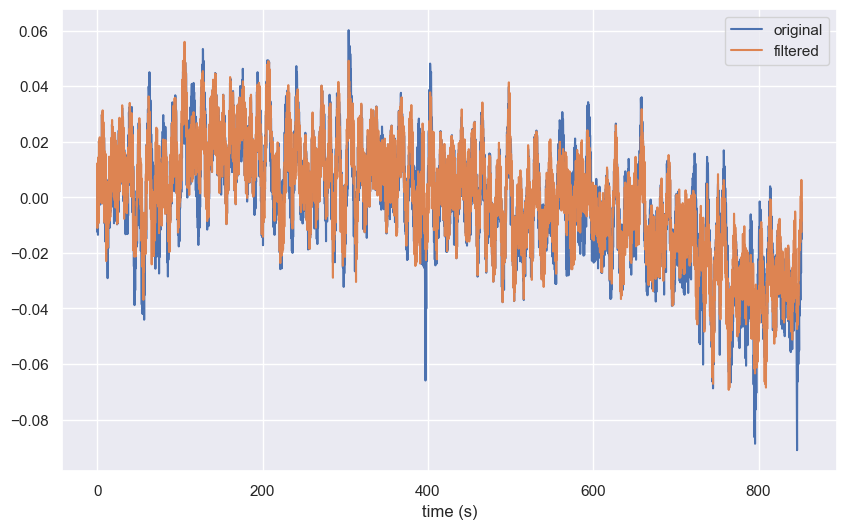

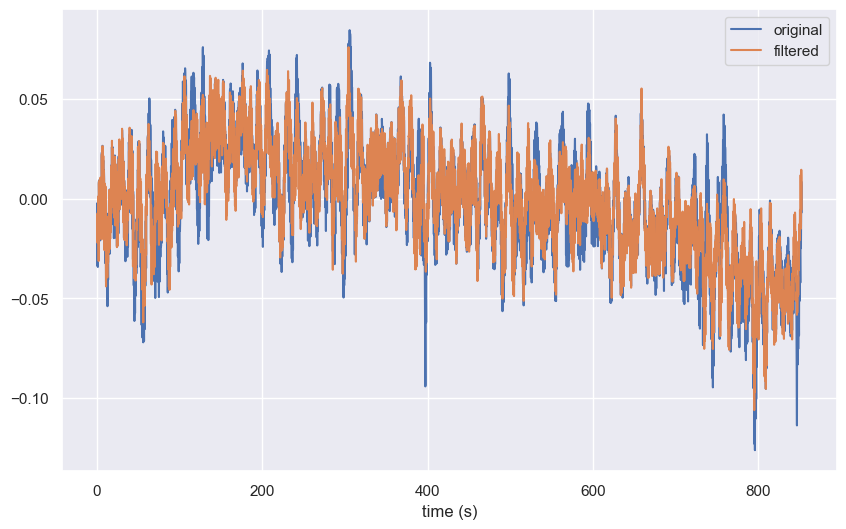

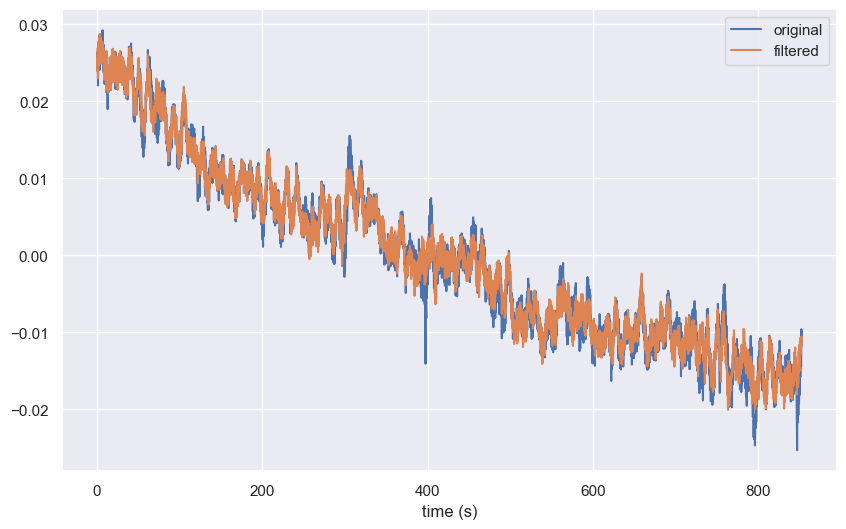

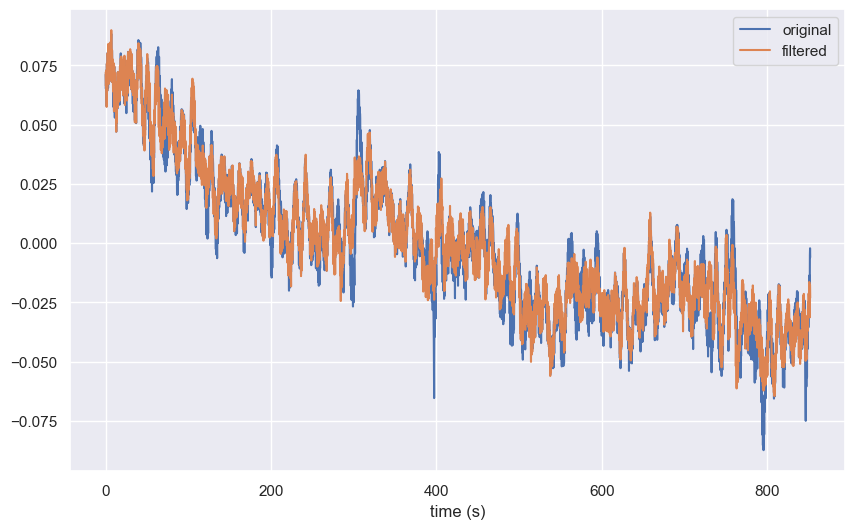

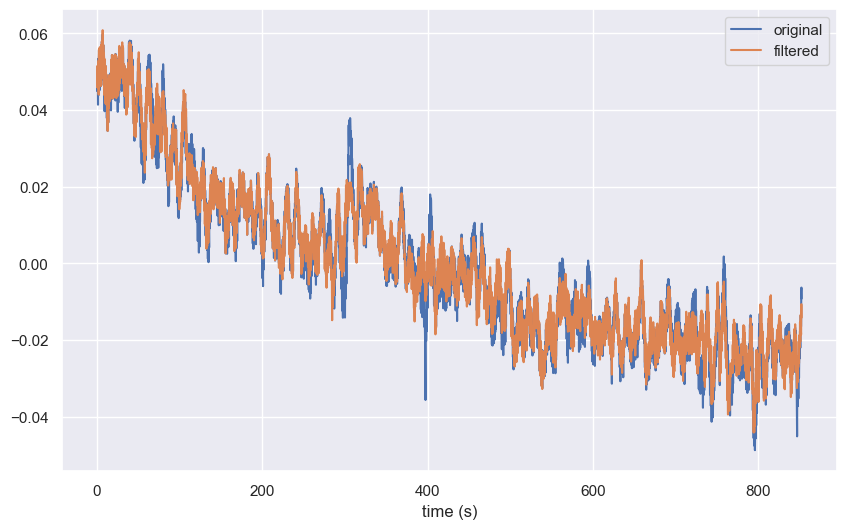

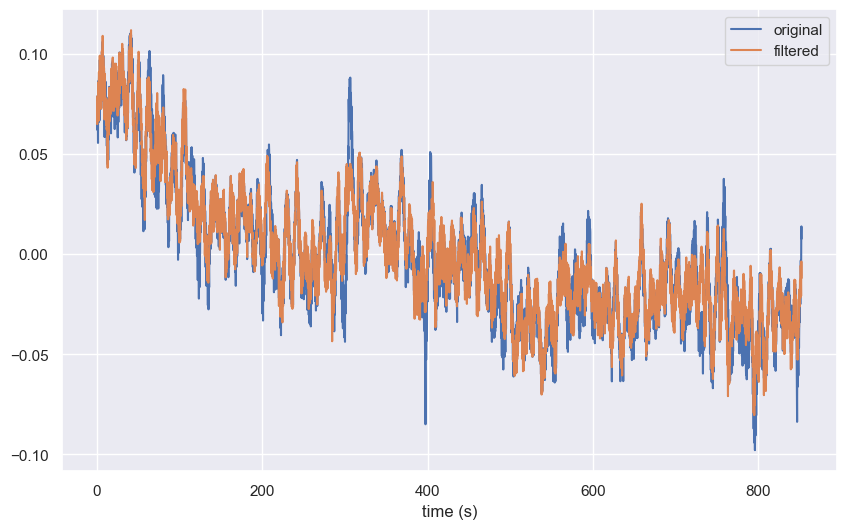

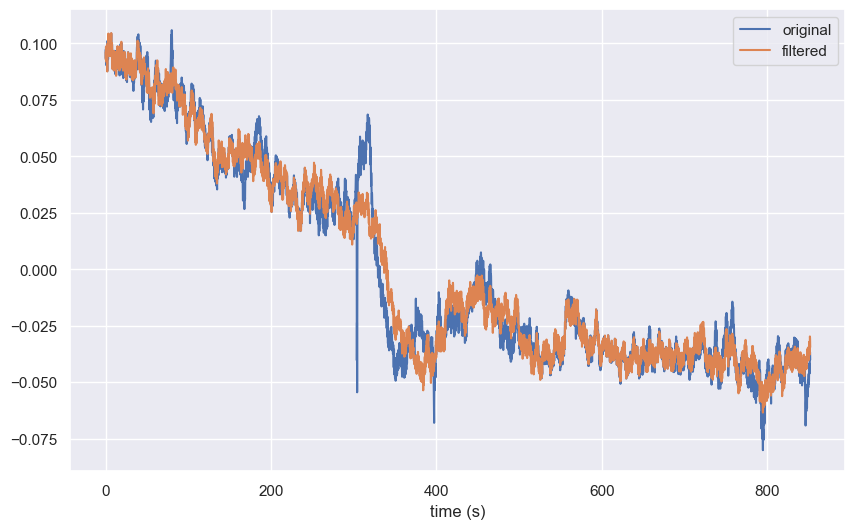

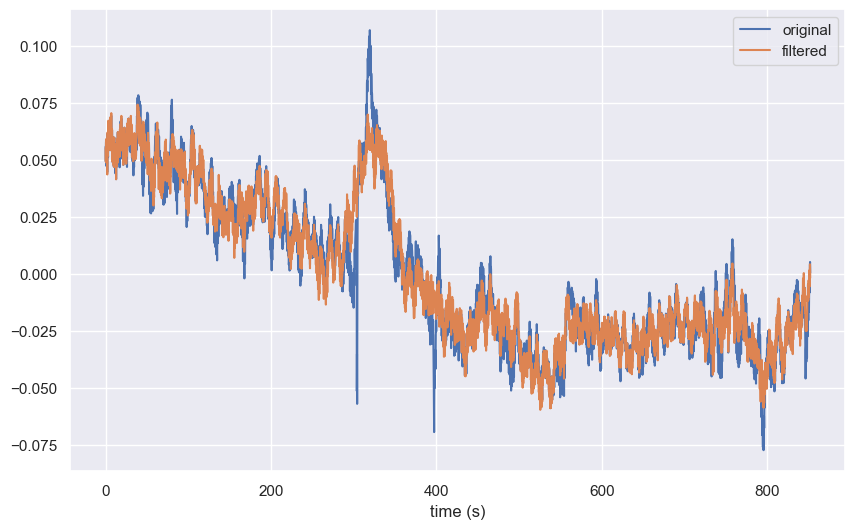

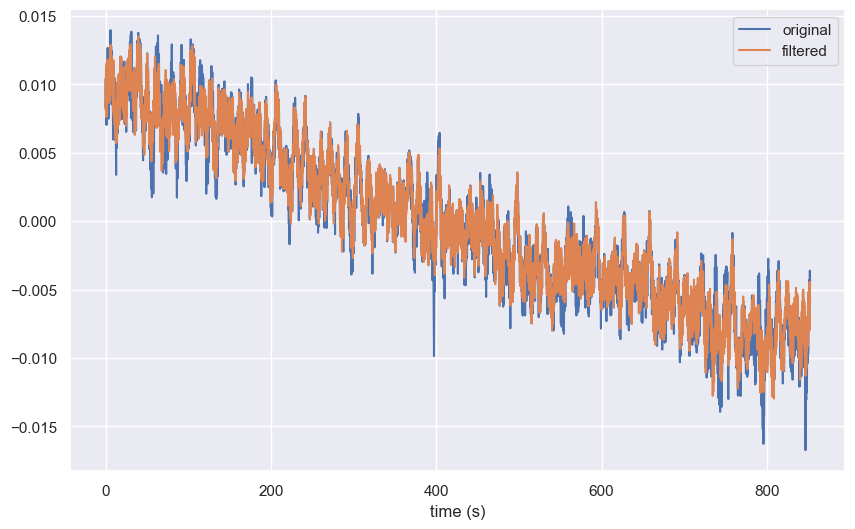

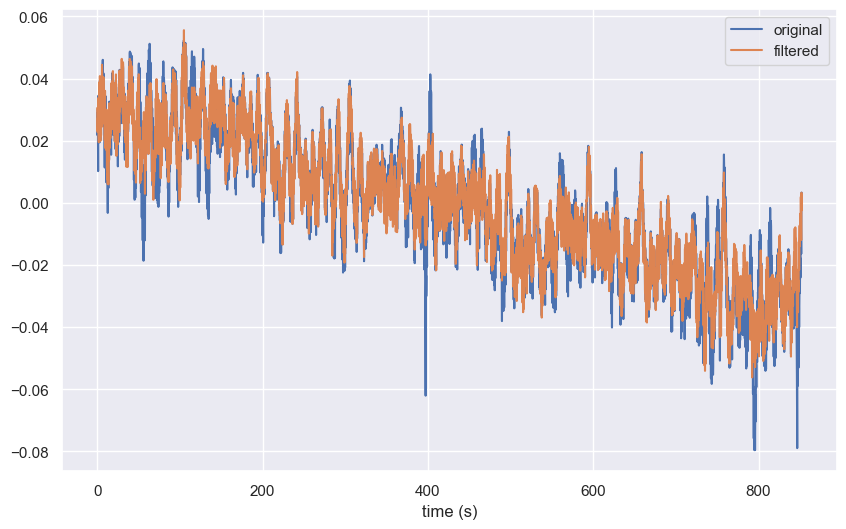

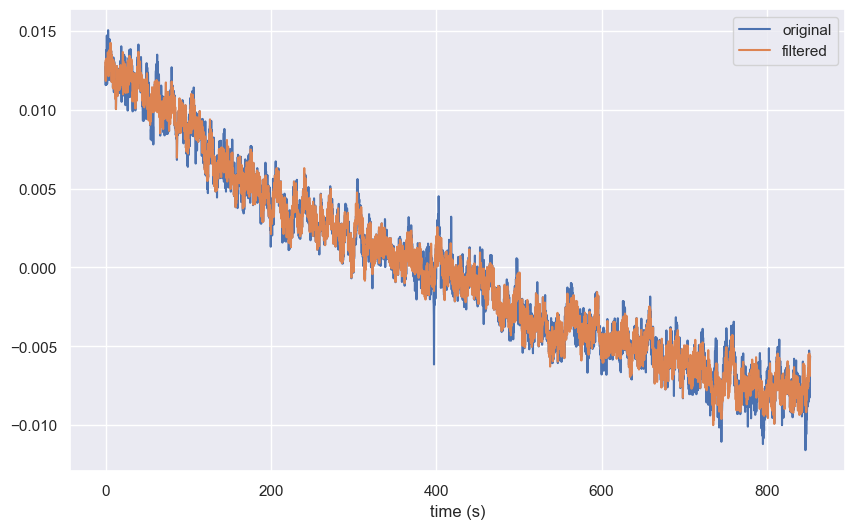

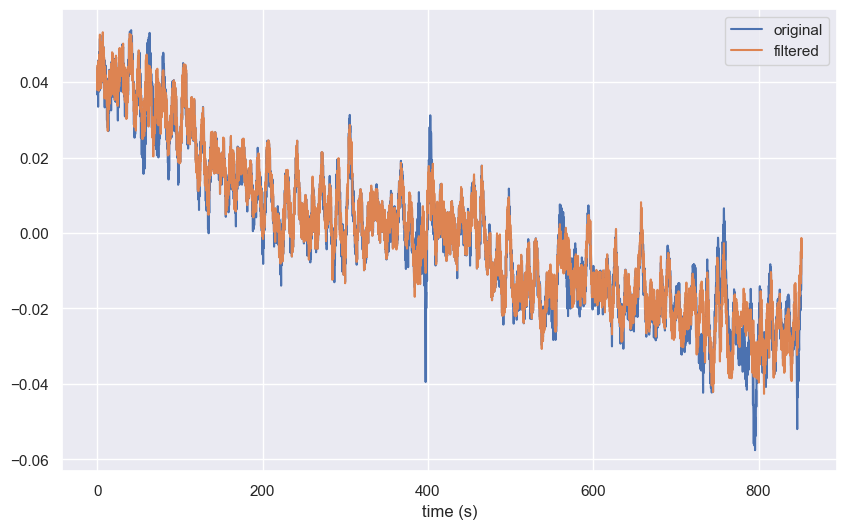

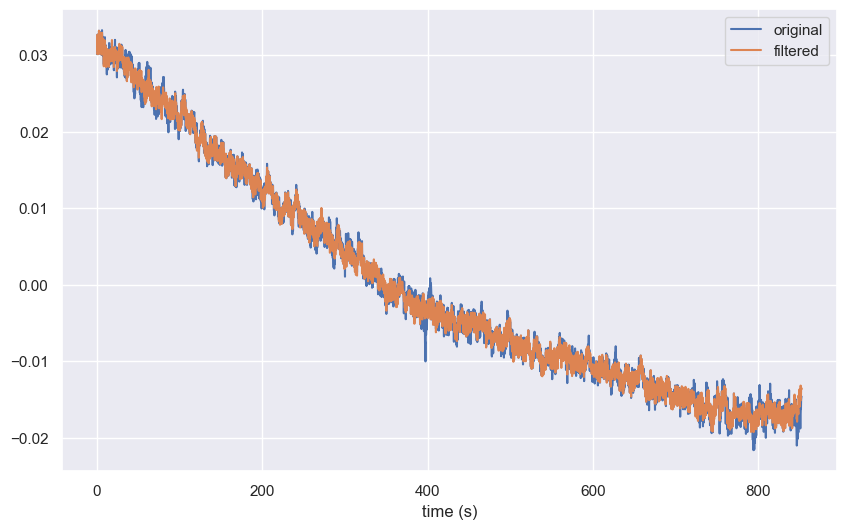

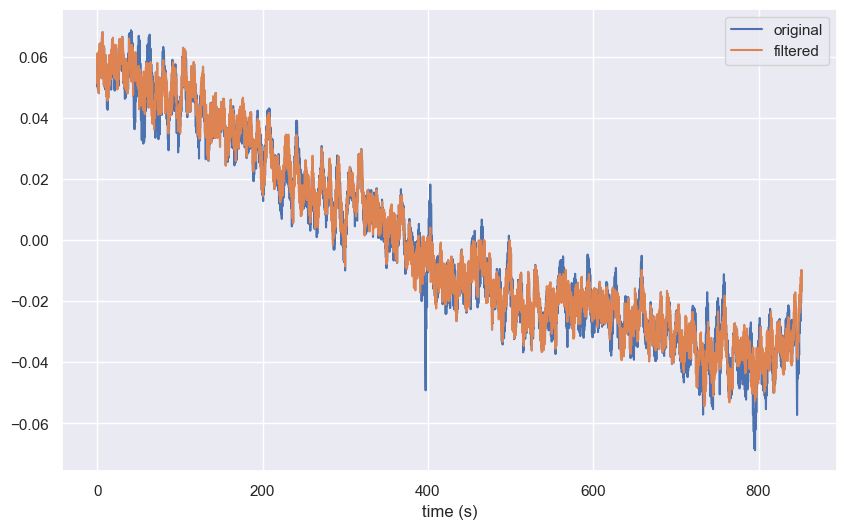

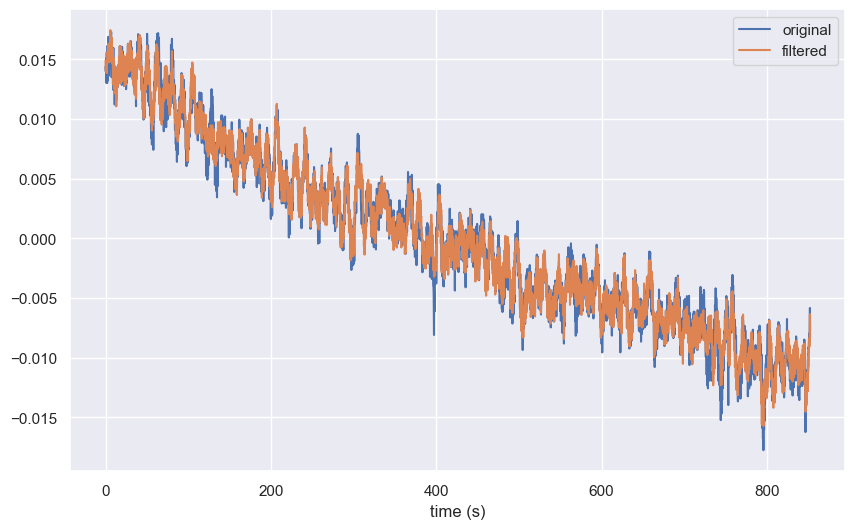

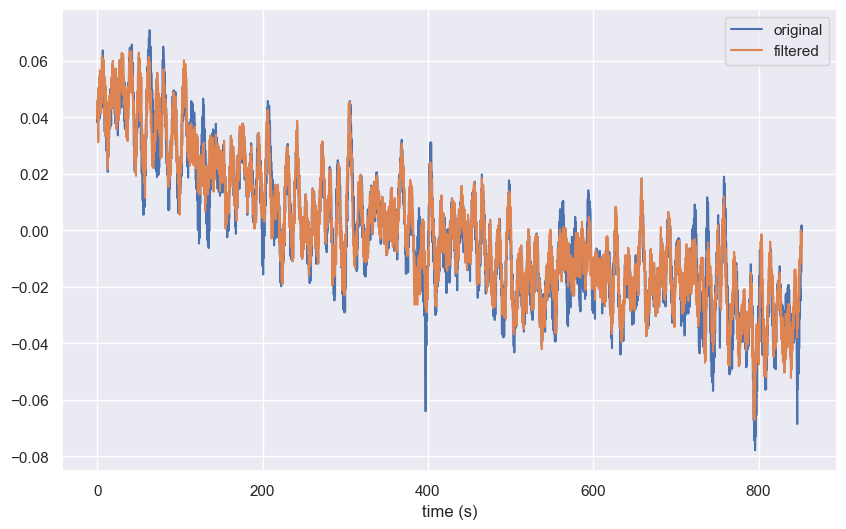

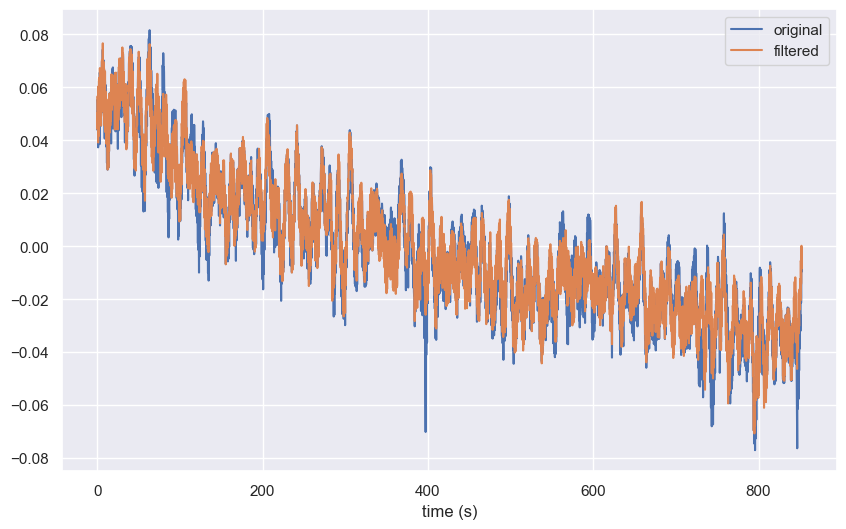

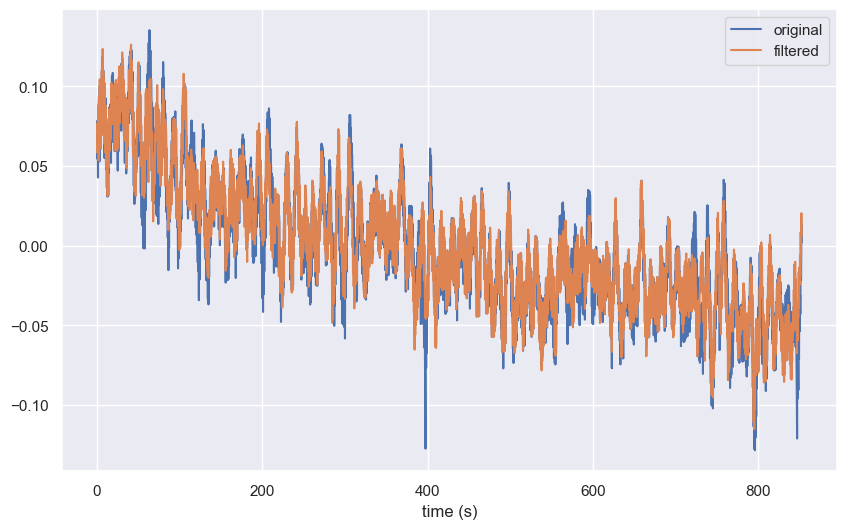

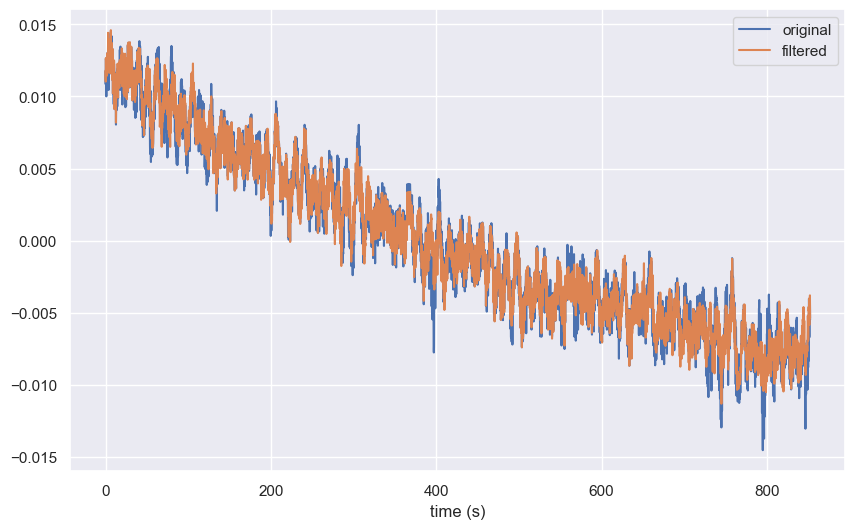

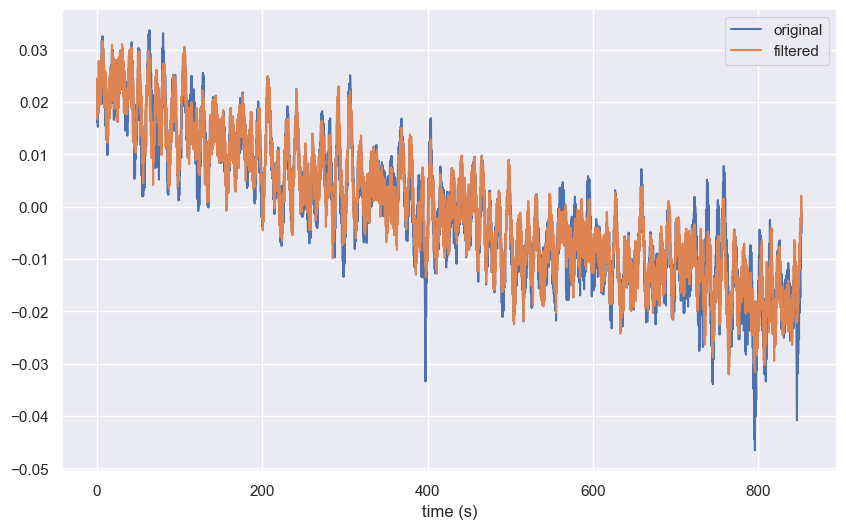

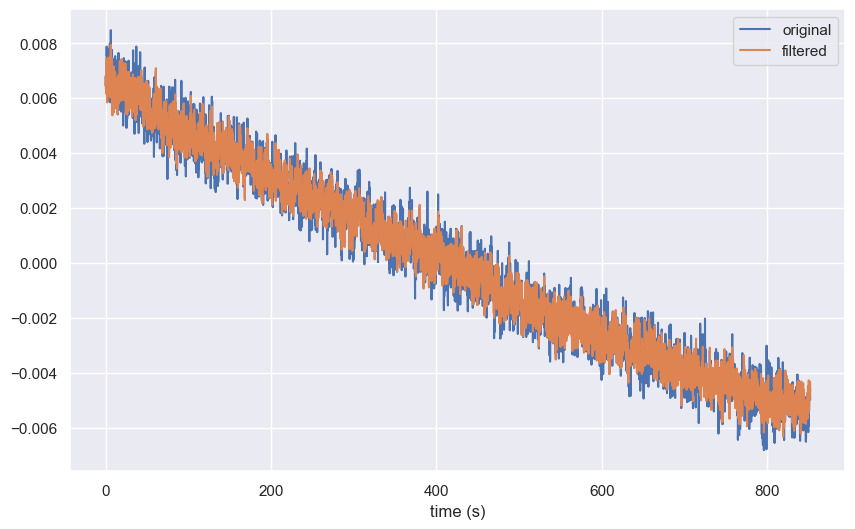

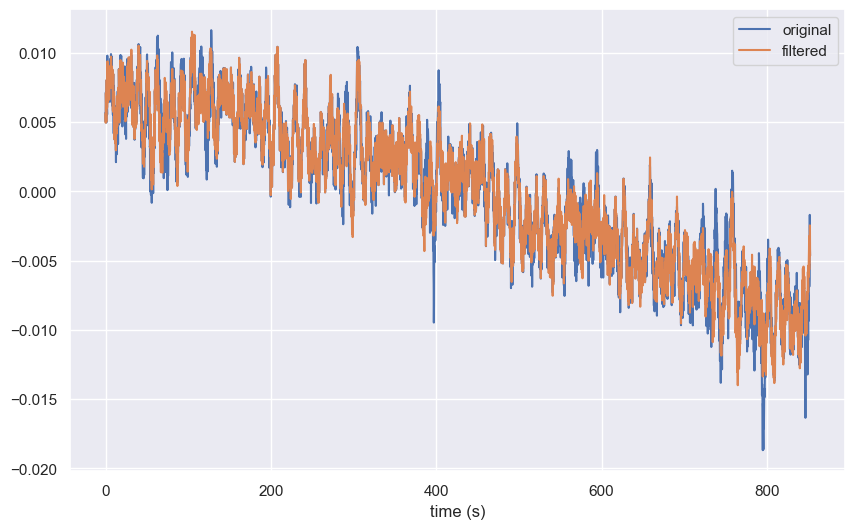

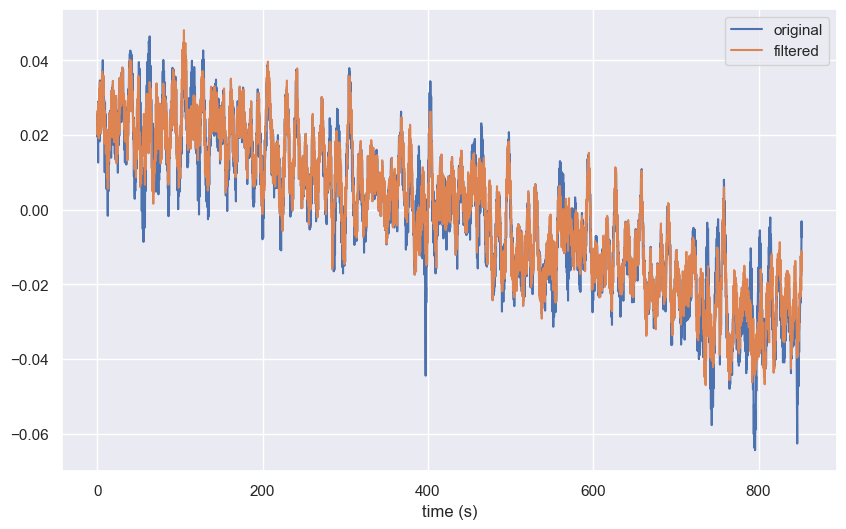

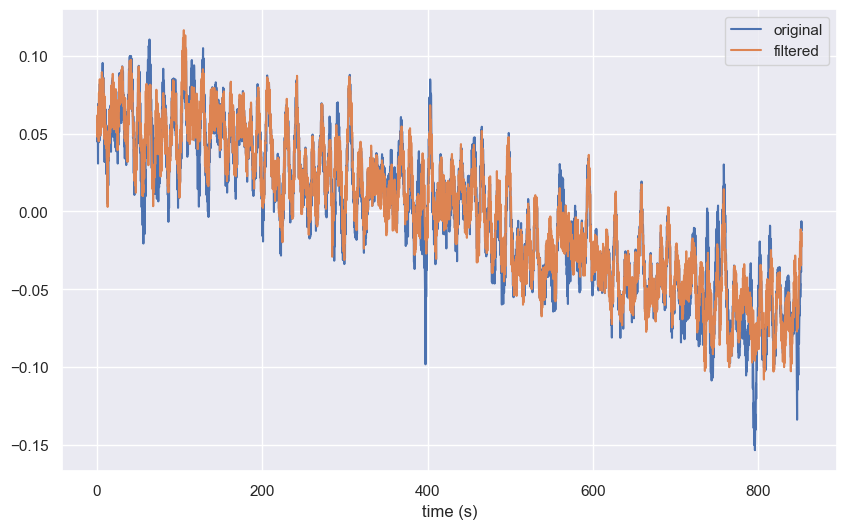

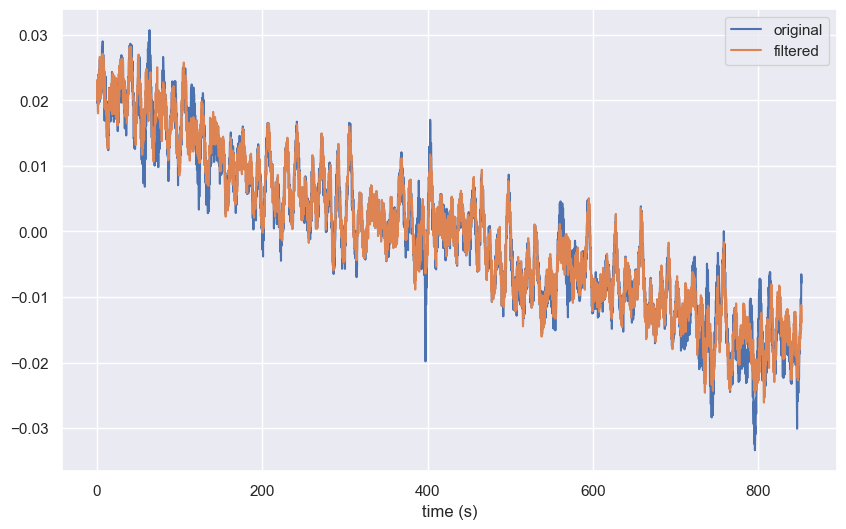

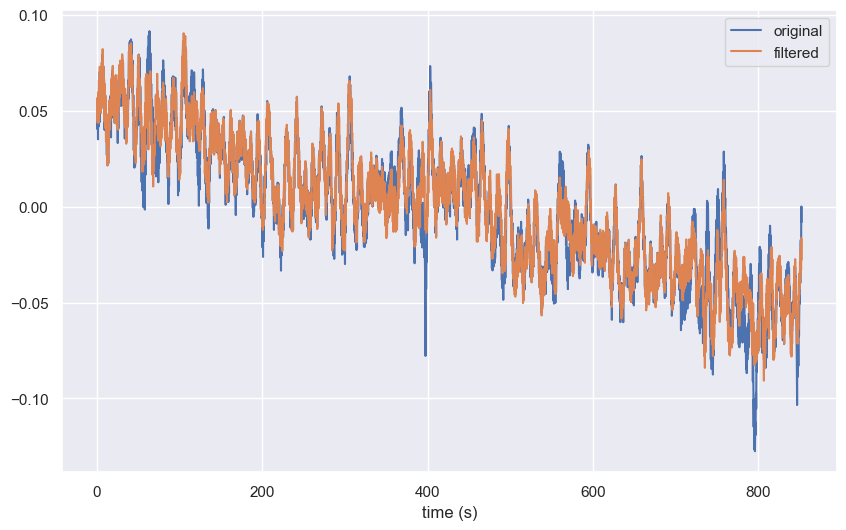

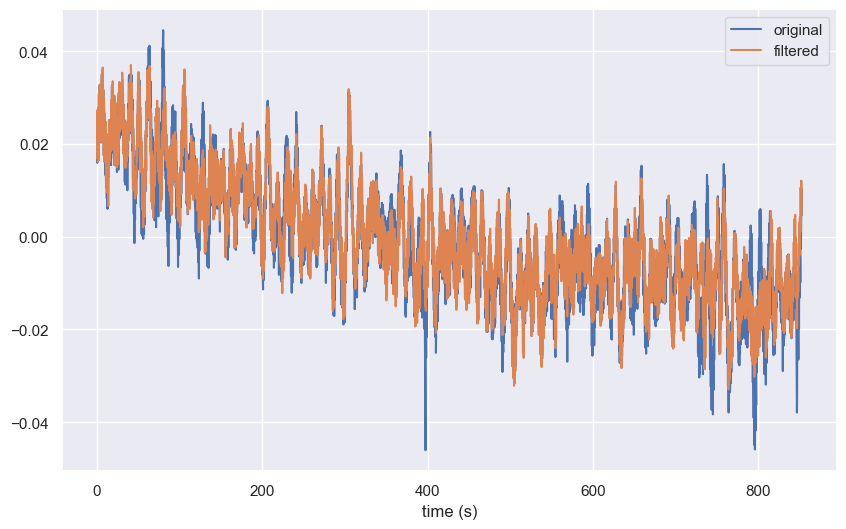

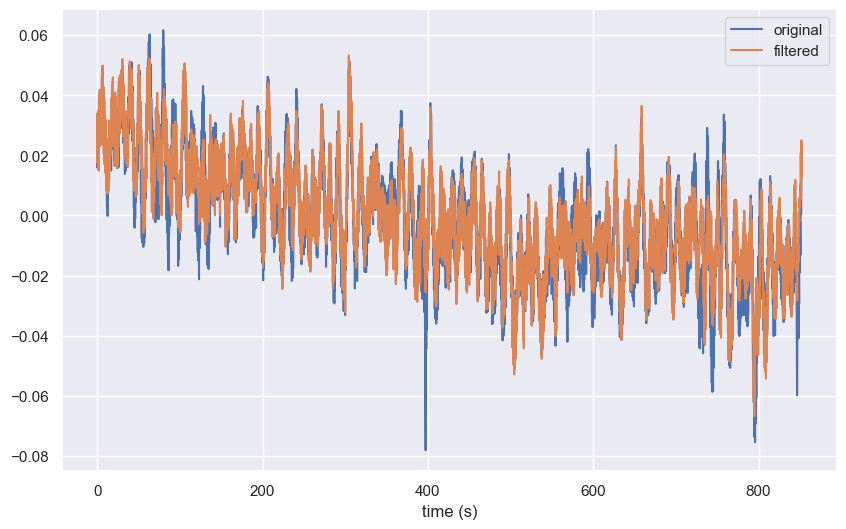

In [28]:
# Method relies on differences between artifacts and fNIRS signal in terms of duration and amplitude and is specifically designed for spike artifacts.
# DOI: 10.1088/0967-3334/33/2/259

raw_od_WF = wavelet_filter(raw_od, plot = True)

#### Kurtosis-based wavelet filtering <a class="anchor" id="sub_section_1_4_2"></a>

In WF, determining a threshold value ($\alpha$) is crucial for rejecting wavelet coefficients. It is worth noting that this parameter should adapt based on the frequency of artifacts present in the data. However, computing the frequency of artifacts necessitates setting a threshold, leading to circularity in threshold selection, resulting in the use of arbitrary fixed values. To mitigate this challenge, Chiarelli et al. (2015) proposed a novel approach for identifying artifactual wavelet coefficients. 

In the kurtosis-based Wavelet Filtering (kbWF) method, the DWT is again applied to the OD data of each channel. Next, a threshold for kurtosis is chosen for the distribution of wavelet coefficients. Chiarelli et al. (2015) suggest a kurtosis threshold value of 3.3 ($k = 3.3$). At the selected decomposition level, the kurtosis value of the coefficient distribution is computed, disregarding zero values. If the kurtosis surpasses the threshold, the highest coefficient (in absolute value) is set to 0. This process continues until the estimated kurtosis falls below the threshold. After scanning through all decomposition levels, the algorithm performs an inverse DWT to estimate the artifact-free time-course. 

In [29]:
# Define function for a single channel
def wavelet_k(data, fs, wavelet_type = 'db5', mode = 'symmetric', level = None, k = 3.3, plot = False):
    
    # Describe properties of a discrete wavelet
    wavelet = pywt.Wavelet(wavelet_type)
    
    # Calculate approximation and detail coefficients (cA (LF), cD (HF))
    coeff = pywt.wavedec(data, wavelet, mode=mode, level=level, axis=-1) 
    # Daubechies 5 (db5) wavelet, If level is None (default) then it will be calculated using the dwt_max_level function.
    # dwt_max_level stops decomposition when the signal becomes shorter than the FIR filter length for a given wavelet.
    # Structure of coeff: [cA_n, cD_n, cD_n-1, …, cD2, cD1]

    coeff_new = []
    
    for coefficient in coeff:
        # Ignore zero values
        zero_free = coefficient[coefficient != 0]

        while kurtosis(zero_free) > k:
            coefficient[np.argmax(np.absolute(coefficient))] = 0
            zero_free = coefficient[coefficient != 0]
        coeff_new.append(coefficient)
        
    #Perform inverse wavelet transform
    data_new = pywt.waverec(coeff_new, wavelet, mode=mode, axis=-1)

    if plot:
        # Plot original and new values
        %matplotlib inline
        time1 = np.arange(len(data))/fs
        time2 = np.arange(len(data_new))/fs
        plt.plot(time1, data, label = 'original')
        plt.plot(time2, data_new, '--', label = 'filtered')
        plt.xlabel('time (s)')
        plt.legend()
        plt.show()

    return data_new

In [30]:
# Iterate over all channels and create new raw object
def wavelet_filter_k(raw, plot = False):
    
    raw = raw.copy()
    picks = _validate_nirs_info(raw.info)

    for pick in picks:
        raw._data[pick] = wavelet_k(raw._data[pick], raw.info['sfreq'], wavelet_type = 'db5', mode = 'symmetric', level = None, k = 3.3, plot = plot)
    
    return raw

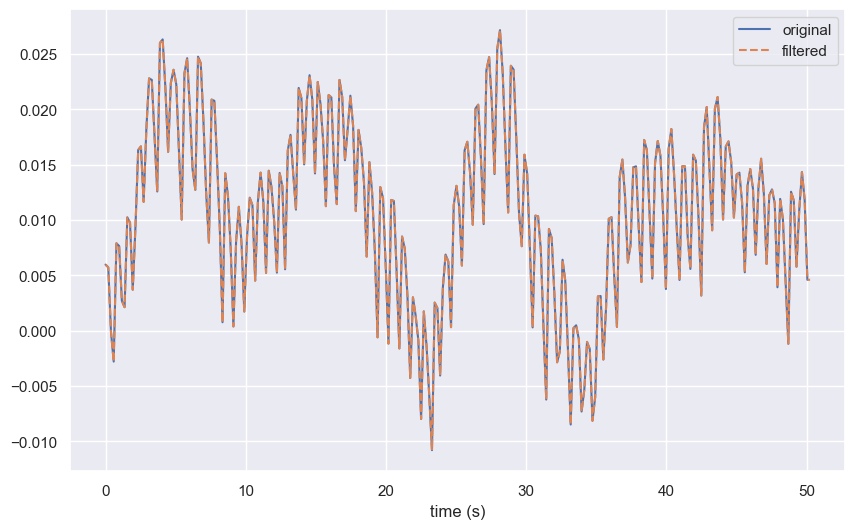

ValueError: could not broadcast input array from shape (260,) into shape (259,)

In [31]:
raw_od_kWF = wavelet_filter_k(raw_od.copy().crop(100,150), plot= True)

---
> *Remark:*
- Almost no effect
---

#### Spline interpolation  <a class="anchor" id="sub_section_1_4_3"></a>

Scholkmann et al. (2010) proposed to use moving standard deviation (MSD) and spline interpolation to respectively detect and reduce MAs in NIR imaging, and termed it MARA. Therefore, the algorithm consists of two individual steps. 

In the first step, the two-sided MSD ($s(t)$) of each channel ($x(t)$) is calculated and compared to a user chosen threshold value $T$. Values in \( s(t) \) below \( T \) are nullified, leaving segments of non-zero values that represent segments of \( x(t) \) affected by MAs. This information is then used to segment $x(t)$ in segments that contain MA and segments that do not. 

In the next step, spline interpolation is performed on the segments of $x(t)$ that contain MAs. Scholkman and associates use the cubic spline interpolation method (*csaps*) with a smoothing parameter value of $p=0.01$. A denoised segment is than produced by subtracting the spline interpolation function from the original MA-containing segments. However, this spline subtraction leads to different signal levels between MA- and non-MA-containing segments. Therefore, to ensure a continuous signal, a correction algorithm based on parallel-shifting with respect the mean value of the target MA-containing segments, and the mean value of the previous non-MA-containing segment, is performed. 

In [ ]:
# Define the MSD function
def MSD(x, k):
    w = 2*k+1
    N = len(x)
    msd = np.zeros_like(x)
    msd[:k] = np.NAN
    msd[-k:] = np.NAN
    for t in range(k,N-k):
        x_window = x[t-k:t+k+1]
        msd[t] = np.sqrt(np.sum(x_window**2)-np.sum(x_window)**2/w)/w
    return msd

In [ ]:
# Define a fucntion that detects the start and end points of the MAs
# First segment is lower than threshold!
def detection_start_end(x, k, T = None, n = 3):
    s = MSD(x, k)

    if T == None:
        T = np.nanmean(s) + n * np.nanstd(s)
        
    non_zeros_id = np.where(s > T)[0]
    split = [non_zeros_id[0]]
    for i, id in enumerate(non_zeros_id[1:]):
        if id != (non_zeros_id[i] + 1):
            split.append(int(non_zeros_id[i] + 1))
            split.append(id)
    split.append(non_zeros_id[-1]+1)
    split = list(np.array(split)+k)
    
    x_segmented = np.split(x, split)
    if x_segmented[0].size > 0:
        print('First segment lower than threshold')
        first_element = 0
    else:
        print('First segment higher than threshold')
        s_segmented = s_segmented[1:]
        first_element = 1
    if x_segmented[-1].size > 0:
        print('last segment lower than threshold')
    else:
        print('last segment higher than threshold')
        x_segmented = x_segmented[:-1]
    return x_segmented, first_element

In [ ]:
# Define spline interpolation function
# --> each segment containing an MA is spline interpolated

def spline_int(raw, t_start, t_stop, channel, k, T, n = None, p = 0.01, plot = False):
    x = raw.copy().crop(t_start, t_stop).get_data(picks = channel)[0]
    x_org = x.copy()
    x_segmented, first_element = detection_start_end(x, k, T, n)
    
    for i, segment in enumerate(x_segmented):
        if (i%2 != first_element) and (len(segment) > 1):
            x = np.arange(len(segment))
            xs = np.arange(0, len(segment), 0.1)
            yi = csaps(x, segment, xs, smooth = p) # See scholkmann 2010 p = 0.01
            ps = csaps(x, segment, smooth = p)

            corrected_segment = segment - ps(x)
            x_segmented[i] = corrected_segment
        
            if plot:
                plt.plot(x/raw.info['sfreq'], segment, 'o-', label='data')
                plt.plot(xs/raw.info['sfreq'], yi, label="S")
                plt.plot(x/raw.info['sfreq'], corrected_segment, 'x-', label = 'corrected data')
                plt.legend(loc='lower left', ncol=2)
                plt.title('Interpolation of segment ' + str(i))
                plt.show()
    x_corrected = np.concatenate(x_segmented)
    
    if plot:
        t = np.arange(len(x_org))/raw.info['sfreq']
        plt.plot(t, x_org, 'o-', label='data')
        plt.plot(t, x_corrected, 'x-', label = 'corrected data')
        plt.legend(loc='lower left', ncol=2)
        plt.title('Comparison original and MA corrected signal')
        plt.show()
    return x_segmented, first_element
        

In [ ]:
# W should be similar to the period of spikes that users aimed to identify. see Zhao2021
t_spike = 1
samples_spike = t_spike*raw_MA_od.info['sfreq']
k = int(samples_spike//2)
x = raw_MA_od.copy().crop(530,570).get_data(picks = 25)[0]
#T = np.nanmean(MSD(x, k)) + np.nanstd(MSD(x, k))
T = None
plt.plot(x)

In [ ]:
x_segmented, first_element = spline_int(raw_MA_od, 530, 570, 25, k, T, n = 2, p = 0.01, plot = True)

In [ ]:
# A lot of coding!! see scholkman 2010
# Step 4: Reconstruction of the whole time series
if not first_element:
    x_segmented_new = []
else:
    x_segmented_new = [x_segmented[0]]
alpha = round(raw_MA_od.info['sfreq']/3)
beta = round(raw_MA_od.info['sfreq']/2)
for i in range(0,int(len(x_segmented)-1)):
    if i%2 == first_element:
        x_segmented_new.append(x_segmented[i])
        lambda_1 = len(x_segmented[i])
        lambda_2 = len(x_segmented[i+1])
        theta_1 = np.ceil(lambda_1/10)
        theta_2 = np.ceil(lambda_2/10)
        if lambda_1 <= alpha:
            if lambda_2 <= alpha:
                a = np.sum(x_segmented[i])
                b = np.sum(x_segmented[i+1])
            elif lambda_2 >= beta:
                a = np.sum(x_segmented[i])
                b = np.sum(x_segmented[i+1][:int(theta_2+1)])
            else:
                a = np.sum(x_segmented[i][:int(theta_1+1)])
                b = np.sum(x_segmented[i+1][:int(alpha+1)])
        elif lambda_1 >= beta:
            if lambda_2 <= alpha:
                a = np.sum(x_segmented[i][int(lambda_1-theta_1):int(lambda_1+1)])
                b = np.sum(x_segmented[i+1][:lambda_2])
            elif lambda_2 >= beta:
                a = np.sum(x_segmented[i][int(lambda_1-theta_1):int(lambda_1+1)])
                b = np.sum(x_segmented[i+1][:int(theta_2+1)])
            else:
                a = np.sum(x_segmented[i][int(lambda_1-theta_1):int(lambda_1+1)])
                b = np.sum(x_segmented[i+1][:int(alpha+1)])
        else:
            if lambda_2 <= alpha:
                a = np.sum(x_segmented[i][int(lambda_1-alpha):int(lambda_1+1)])
                b = np.sum(x_segmented[i+1][:lambda_2])
            elif lambda_2 >= beta:
                a = np.sum(x_segmented[i][int(lambda_1-alpha):int(lambda_1+1)])
                b = np.sum(x_segmented[i+1][:int(theta_2+1)])
            else:
                a = np.sum(x_segmented[i][int(lambda_1-alpha):int(lambda_1+1)])
                b = np.sum(x_segmented[i+1][:int(alpha+1)])
        theta_m = a - b
        segment_shifted = x_segmented[i+1] + theta_m
        x_segmented_new.append(segment_shifted)
x_new = np.concatenate(x_segmented_new)
plt.plot(x_new, '--', label = 'filtered')
plt.plot(x, label = 'orginal')
plt.legend()
plt.show()
    

---
> *Remark:*
- No done
---

#### Principal component analysis <a class="anchor" id="sub_section_1_4_4"></a>

Zhang et al. (2005) introduced a spatial filtering technique called targeted PCA (tPCA), which relies on eigenvectors. tPCA is capable of eliminating spike-like MAs as well as baseline shifts. However, its effectiveness may diminish if MAs are not detected across multiple channels.

To implement the method, four different matrices need to be created. For each type of chromophore, HbO and HbR, two matrices are filled with the datapoints of respectively the baseline and stimulation period. From both baseline matrices $\mathbf{H_{base,hbo}}$ and $\mathbf{H_{base,hbr}}$, a spatial correlation matrix $\mathbf{C_{base}}$ is created and subsequently an  eigendecomposition is performed to reveice the orthogonal matrix $\mathbf{U_{base}}$ with columns $\mathbf{u_i}$ referring to the baseline spatial eigenvectors. Additionally, the eigenvalues are calculated. 

$$\mathbf{C_{base}}= \frac{1}{N_t} \cdot \mathbf{H_{base} \cdot H_{base}}^T = \mathbf{U_{base} \cdot \Sigma_{base} \cdot U_{base}}^T $$

Where $N_t$ is the number of data points at different time instants.

In the subsequent step, it is assumed that the initial spatial eigenvectors of the baseline concentration correlation matrices primarily capture interference patterns and contain the majority of the overall energy. Consequently, projecting the stimulus data onto the orthogonal nullspace of these eigenvectors enables the extraction of a more localized response. 
Therefore, a new matrix is created from the first $r$ eigenvectors,  $\mathbf{U_{base,r} = [u_1, ... ,u_r]}$, and then the clean data matrix $\mathbf{H_{stim, clean}}$ is obtained by projecting the original stimulus data onto the orthogonal subspace of $\mathbf{U_{base,r}}$. 
$$   \mathbf{H_{stim, clean} = (I - U_{base,r} \cdot U_{base,r}}^T) \cdot \mathbf{H_{stim}}$$
Where $\mathbf{I}$ is the identity matrix. 

This process is performed for both chromophores and finally the SNR is improved through block-averaging of the trials. 

In [ ]:
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2761652/

In [ ]:
# Define PCA function
def PCA_Zhang(raw, controls_id, trials_id, r, plot = False, xlim = None):
    events, _ = mne.events_from_annotations(raw)

    start_trials = []
    if type(trials_id) != list:
        raise Exception("Event ids must be in list format")
    for id in trials_id:
        start_trials += list(events[events[:,2] == id][:,0]/raw.info['sfreq'])
    start_trials = np.sort(np.array(start_trials))

    start_controls = []
    if type(controls_id) != list:
        raise Exception("Event ids must be in list format")
    for id in controls_id:
        start_controls += list(events[events[:,2] == id][:,0]/raw.info['sfreq'])
    start_controls = np.sort(np.array(start_controls))
    
    Z_stim = raw.copy().crop(tmin=start_trials[0], tmax=(start_trials[-1]+raw.annotations.duration[0])).get_data()
    
    #Z_base = np.zeros((len(raw.ch_names), len(start_controls), len_trial))
    Z_base = raw.copy().crop(tmin=start_controls[0], tmax=(start_controls[-1]+raw.annotations.duration[0])).get_data()

    # removing the mean and scaling to unit variance
    Z_stim = StandardScaler().fit_transform(Z_stim)
    Z_base = StandardScaler().fit_transform(Z_base)
    
    if raw.ch_names[0][-3:] == 'hbo':
        Z_base_hbo = Z_base[::2,:]
        Z_base_hbr = Z_base[1::2,:]

        Z_stim_hbo = Z_stim[::2,:]
        Z_stim_hbr = Z_stim[1::2,:]
    else:
        Z_base_hbo = Z_base[1::2,:]
        Z_base_hbr = Z_base[::2,:]

        Z_stim_hbo = Z_stim[1::2,:]
        Z_stim_hbr = Z_stim[::2,:]

    N_base = Z_base.shape[1]
    
    C_base_hbo = np.matmul(Z_base_hbo, Z_base_hbo.T)/N_base
    C_base_hbr = np.matmul(Z_base_hbr, Z_base_hbr.T)/N_base

    eigenvalues_hbo, eigenvectors_hbo = np.linalg.eig(C_base_hbo)
    eigenvalues_hbr, eigenvectors_hbr = np.linalg.eig(C_base_hbr)

    # Sort eigenvalues
    id_hbo = eigenvalues_hbo.argsort()[::-1] 
    eigenvalues_hbo = eigenvalues_hbo[id_hbo]
    eigenvectors_hbo = eigenvectors_hbo[:,id_hbo]
    id_hbr = eigenvalues_hbr.argsort()[::-1]
    eigenvalues_hbr = eigenvalues_hbr[id_hbr]
    eigenvectors_hbr = eigenvectors_hbr[:,id_hbr]
    
    variance_explained_hbo = []
    for eigenvalue in eigenvalues_hbo:
        variance_explained_hbo.append((eigenvalue/sum(eigenvalues_hbo))*100)
    variance_explained_hbr = []
    for eigenvalue in eigenvalues_hbr:
        variance_explained_hbr.append((eigenvalue/sum(eigenvalues_hbr))*100)

    if r < 1:
        r = 100*r # Convert to percentage
        sum_variance = 0
        for i in range(len(variance_explained_hbo)):
            sum_variance += variance_explained_hbo[i]
            if sum_variance >= r:
                r = i + 1
                print('The PCA is performed with ' + str(r) + ' component(s), representing ' + str(sum_variance) + '% of the variance.')
                break
                
    U_hbo_r = eigenvectors_hbo[:,:r] # Select r first columns corresponding to largest eigenvalues
    U_hbr_r = eigenvectors_hbr[:,:r]

    Z_stim_hbo_new = np.matmul((np.eye(int(len(raw.ch_names)/2)) - np.matmul(U_hbo_r, U_hbo_r.T)), Z_stim_hbo)
    Z_stim_hbr_new = np.matmul((np.eye(int(len(raw.ch_names)/2)) - np.matmul(U_hbr_r, U_hbr_r.T)), Z_stim_hbr)

    new_start_trials = start_trials - start_trials[0]
    new_end_trials = new_start_trials + raw.annotations.duration[0]
    
    %matplotlib inline
    if plot:
        t = np.arange(Z_stim_hbo.shape[1])/raw.info['sfreq']
        for i in range(int(len(raw.ch_names)/2)):
            plt.plot(t, Z_stim_hbo[i], label = 'Stimulus trials hbo')
            plt.plot(t, Z_stim_hbo_new[i], '--', label = 'Stimulus trials hbo filtered')
            ymin, ymax = np.min(Z_stim_hbo[i])*1.5, np.max(Z_stim_hbo[i])*1.5
            plt.vlines(new_start_trials, ymin, ymax, 'g')
            plt.vlines(new_end_trials, ymin, ymax, 'r')
            plt.legend()
            plt.xlabel('time (s)')
            plt.title('Comparison hbo channel ' + str(i+1))
            if xlim != None:
                plt.xlim(xlim)
            plt.show()
    
        for i in range(int(len(raw.ch_names)/2)):
            plt.plot(t, Z_stim_hbr[i], label = 'Stimulus trials hbr')
            plt.plot(t, Z_stim_hbr_new[i], '--', label = 'Stimulus trials hbr filtered')
            ymin, ymax = np.min(Z_stim_hbr[i])*1.5, np.max(Z_stim_hbr[i])*1.5
            plt.vlines(new_start_trials, ymin, ymax, 'g')
            plt.vlines(new_end_trials, ymin, ymax, 'r')
            plt.legend()
            plt.xlabel('time (s)')
            plt.title('Comparison hbr channel ' + str(i+1))
            if xlim != None:
                plt.xlim(xlim)
            plt.show()
    
    Z_stim_new = np.zeros_like(Z_stim)
    if raw.ch_names[0][-3:] == 'hbo':
        Z_stim_new[::2,:] = Z_stim_hbo_new
        Z_stim_new[1::2,:] = Z_stim_hbr_new
    else:
        Z_stim_new[1::2,:] = Z_stim_hbo_new
        Z_stim_new[::2,:] = Z_stim_hbr_new

    raw_out = raw.copy().crop(tmin=start_trials[0], tmax=(start_trials[-1]+raw.annotations.duration[0]))
    picks = _validate_nirs_info(raw_out.info)

    for pick in picks:
        raw_out._data[pick] = Z_stim_new[pick]
    return raw_out


In [ ]:
raw_haemo_PCA = PCA_Zhang(raw_haemo, [1], [2,3], 0.95, plot = True, xlim = (0,350))

##### Examine PCA components

In [ ]:
X = raw_haemo_PCA.get_data().T
# removing the mean and scaling to unit variance
x_scaled = StandardScaler().fit_transform(X)

pca = PCA() # iets invulen of niet dan?
 
# Fit and transform data
pca_features = pca.fit_transform(x_scaled)

In [ ]:
# Scree Plot
# Bar plot of explained_variance
plt.bar(range(1,len(pca.explained_variance_)+1), pca.explained_variance_)

plt.plot(range(1,len(pca.explained_variance_ )+1), np.cumsum(pca.explained_variance_), c='red', label='Cumulative Explained Variance')

plt.legend(loc='upper left')
plt.xlabel('Number of components')
plt.ylabel('Explained variance (eignenvalues)')
plt.title('Scree plot filtred data')

plt.show()

In [ ]:
X = raw_haemo.get_data().T
# removing the mean and scaling to unit variance
x_scaled = StandardScaler().fit_transform(X)

pca = PCA() # iets invulen of niet dan?
 
# Fit and transform data
pca_features = pca.fit_transform(x_scaled)

In [ ]:
# Scree Plot
# Bar plot of explained_variance
plt.bar(range(1,len(pca.explained_variance_)+1), pca.explained_variance_)

plt.plot(range(1,len(pca.explained_variance_ )+1), np.cumsum(pca.explained_variance_), c='red', label='Cumulative Explained Variance')

plt.legend(loc='upper left')
plt.xlabel('Number of components')
plt.ylabel('Explained variance (eignenvalues)')
plt.title('Scree plot filtred data')

plt.show()

#### Independent component analysis <a class="anchor" id="sub_section_1_4_5"></a>

ICA is a blind source separation technique utilized to decompose fNIRS data into multiple source components and their associated weights (Zhao et al., 2021). Prior to applying ICA, a prewhitening stage is executed using PCA to mitigate the risk of over-fitting and to reduce the computational cost. Subsequently, ICA disentangles the fNIRS signals into a weighted summation of multiple independent sources.

The prevalent ICA algorithms in fNIRS literature include FastICA and SOBI, leveraging high-order statistics (HOS) and sample dependence (SOS), respectively. Following this, the separated sources undergo manual selection based on spatial and temporal characteristics, aided by quantitative metrics such as the MSD, the coefficient of spatial uniformity (CSU) or the correlation with an external input (CEI). 

The CEI assesses sources by correlating their time courses with those recorded by external devices like accelerometers, physiological instruments or short channels, using Pearson’s correlation coefficient. Meanwhile, CSU quantifies the spatial map of sources, calculated by the ratio of the mean to the standard deviation of the spatial map of each source. 
$$CSU(i) = |\frac{\overline{c_i}}{\sigma ( c_i ) }|$$
In the final stage of the ICA process, noise sources are discarded to reconstruct the clean fNIRS signals, which are then susceptible to analysis using conventional techniques. 

ICA operates on the assumption that the source signals are statistically independent and can be applied to optical intensities, optical densities, and concentration changes. 


In [ ]:
# Using ICA interface in MNE-Python (similar to the interface in scikit-learn)
def ICA2(raw, tmin = 0.0, tmax = None, n_components = 0.99, method = 'fastica', score_method = 'MSD', plot = True, filename_txt = None):
    # Crop if required 
    raw = raw.copy().crop(tmin, tmax)
    # 'Before we run the ICA, an important step is filtering the data to remove low-frequency drifts'
    # --> Not feasable as important information is under 1 Hz

    # Scaling to unit variance and whitened using PCA 
    ica = ICA(n_components = n_components, method = method) # Components for PCA to remain 99% variance
    ica.fit(raw)
    print(ica)

    # Plot ICA sources
    if plot:
        %matplotlib qt
        ica.plot_sources(raw, show_scrollbars = True);

    # Get sources data for score calculation
    ica_sources = ica.get_sources(raw).get_data()

    if score_method == 'MSD':
        # Perform MSD
        # W = 2*k + 1 should be similar to the period of spikes that users aimed to identify. See Zhao et al. (2021)
        t_spike = 1
        samples_spike = t_spike*raw.info['sfreq']
        k = int(samples_spike//2)
        n = 3 # Threshold 3 std from the mean
        
        scores = []
        for i in range(ica_sources.shape[0]):
            s = MSD(ica_sources[i], k)
            T = np.nanmean(s) + n*np.nanstd(s)
            score = np.sum(np.where(s > T, 1, 0))
            scores.append(score)
        scores = np.array(scores)
        
    # elif score_method == 'CSU':
    #     # Perfom coefficient of spatial uniformity (CSU)
    #     scores = []
    #     for i in range(ica_sources.shape[0]):
    #         spatial_map = ? # Depends on tica/sica and how to retract?
    #         csu = np.abs(np.mean(spatial_map)/np.std(spatial_map))

    elif score_method == 'CEI':
        # Perform correlation with external input
        # Need IMU data
        IMU_df, acc_df, gyro_df = get_IMU_data(filename_txt)
        IMU = IMU_df.to_numpy().T
        # crop IMU
        s_start = round(tmin*raw.info['sfreq'])
        if tmax != None:
            s_end = round(tmax*raw.info['sfreq']) + 1
            IMU = IMU[:, s_start:s_end]
        else:
            IMU = IMU[:, s_start:]
        scores = []
        for i in range(ica_sources.shape[0]):
            corr_xyz = []
            for j in range(6): # x, y and z acc + 3 gyro recorded
                corr = pearsonr(ica_sources[i], IMU[j])
                corr_xyz.append(corr)
            # Take mean?
            score = np.mean(np.array(corr_xyz))
            scores.append(score)
    if plot: 
        # Plot scores
        ica.plot_scores(scores);

    # Remove source with highest score
    ica.exclude = [np.argmax(np.array(scores))]

    # Reconstruct to get clean fNIRS
    # ICA apply() does:
        # 1) Unmixes the data with the unmixing_matrix
        # 2) Includes ICA components based on ica.include and ica.exclude
        # 3) Re-mixes the data with mixing_matrix_
        # 4) Restores any data not passed to the ICA algorithm, i.e., the PCA components between n_components and n_pca_components
    reconst_raw = raw.copy()
    ica.apply(reconst_raw)
    
    if plot:
        reconst_raw.plot();

    return reconst_raw

In [ ]:
tmin = events[10, 0]/raw_od.info['sfreq'] - 15
tmax = events[-1, 0]/raw_od.info['sfreq'] + 30

In [ ]:
raw_ICA = ICA2(raw_od, tmin, tmax, n_components = 0.99, method = 'fastica', score_method = 'MSD', plot = True)

In [ ]:
raw_ICA = ICA2(raw_MA_od, tmin, tmax, n_components = 0.99, method = 'fastica', score_method = 'CEI', plot = True, filename_txt = 'romane_vorwald ma_22_20240508-133500.txt')

#### Temporal derivative distribution repair <a class="anchor" id="sub_section_1_4_6">

The TDDR method was introduced by Fishburn et al. in 2019. It offers both online and offline filtering approaches based on the temporal derivative of fNIRS signals, requiring no user-defined parameters. Moreover, it is applicable to concentration changes, optical intensities, and optical densities (Huang et al., 2022).

This method operates under specific assumptions: (1) non-motion-related fluctuations follow a normal distribution, (2) the majority of fluctuations are unrelated to motion artifacts, and (3) MA derivatives dominate in the derivatives of fNIRS signals during their presence.

The algorithm comprises five distinct steps. For an in-depth description of each step, please consult Fishburn et al. (2019).

In [ ]:
# This approach corrects baseline shift and spike artifacts without the need for any user-supplied parameters (Fishburn Et Al., 2019)
# doi:10.1016/j.neuroimage.2018.09.025
raw_od_tddr = temporal_derivative_distribution_repair(raw_od)

#### Correlation-based signal improvement <a class="anchor" id="sub_section_1_4_7"></a>

The CBSI method, introduced by Cui et al. (2010), operates on a channel-by-channel basis. It operates under the assumption that under normal conditions, changes in HbO and HbR levels exhibit a negative correlation during functional activation. However, in the presence of motion artifacts, this correlation tends to become more positive. The measured signals for HbO and HbR, denoted as $x$ and $y$ respectively, consist of the true HbO and HbR signals to be estimated ($x_0$ and $y_0$), along with the motion artifact $F$, which affects both chromophores equally (with a constant weighting $\alpha$), and high-frequency white noise. 
$$
    \begin{cases}
      x = x_0 + \alpha * F + Noise \\
      y = y_0 + F + Noise
    \end{cases}       
$$
Assuming that (1) the correlation between $x_0$ and $y_0$ is approximately -1, (2) the correlation between the artifact $F$ and the true signal $x_0$ is close to 0, (3) the ratio between HbO and HbR remains consistent regardless of artifact presence and (4) the high-frequency noise can be removed with a low-pass filter, the true HbO and HbR signals can be derived using the following equation:
$$
    \begin{cases}
      x_0 = (x - \alpha * y)/2 \\
      y_0 = -(1/\alpha)*x
    \end{cases}  
$$
with $\alpha = \frac{std(x)}{std(y)} $ where $std(x)$ is the standard deviation of $x$. 

As this method is based on the relation between HbO and HbR, the MA correction needs to be employed after the optical densities are converted to haemoglobin concentrations with the MBLL.

In [ ]:
raw__haemo_CBSI = mne_nirs.signal_enhancement.enhance_negative_correlation(raw_haemo)